# EV Load Simulation Framework - v10.6

# **AI-Generated Overview:**

---

Welcome to the **EV Charging Load Simulation** model, designed to estimate and assess electric vehicle (EV) charging demand in Banff based on real traffic, environmental, and infrastructure variables. This notebook simulates the hourly charging load imposed by EVs under various scenarios using a Monte Carlo approach.

---

## **Notebook Overview**

This simulation assumes:
- Each incoming EV attempts to charge upon arrival.
- EVs may be either **Day** visitors (use only public chargers) or **Overnight** visitors (can access both public and private chargers).
- Charging preferences, SOC behavior, port availability, power throttling, and queue dynamics are all modeled.

---

## **Structure & Key Components**

| Section | Description |
|--------|-------------|
| `EVCalculator` | Computes number of EVs from total traffic using a stochastic penetration model. |
| `EV` | Defines EV behavior: SOC, charger selection, power throttling, wait time, and charging profile. |
| `EVChargingSimulation` | Runs a single simulation iteration: manages port states, queues, and EV processing. |
| `MonteCarloSimulator` | Aggregates multiple simulation runs and computes averaged metrics. |
| Scenario Blocks | Define parameterized cases (baseline, stress tests, etc.) to explore system behavior. |

---

## **Outputs of Interest**

- **Energy Delivered** by charger level.
- **Power Load Profile** and **Peak Demand**.
- **Utilization and Idle Time** of charging infrastructure.
- **Queue Formation** and **Waiting Times**.
- **Failed EV Charges**: Vehicles that leave due to wait limits.

---

## Tips for Reviewers

- Functions and methods needing further explanation are marked with `TODO`.
- Logging setup is minimal by default — uncomment handlers for debug output if needed.
- The system is modular — key behaviors can be adjusted via scenario parameters.

---


## Version 10.6 – Changelog & Scenario Parameters

This version introduces support for flexible scenario analysis and Monte Carlo convergence tracking. Users can now externally control several key simulation factors to model a wide range of realistic and extreme charging load scenarios.

---

### Controllable Simulation Parameters

| Factor | Description |
|--------|-------------|
| **Visitor Volume** | Modify the vehicle traffic dataframe to simulate changes in visitation rates. |
| **Vehicle Arrival Distribution** | Adjust the temporal distribution of vehicle entries to reflect more clustered or spread-out arrivals. |
| **EV Penetration** | Manipulate the proportion of EVs in the fleet using the EV dataframe. |
| **Ambient Temperature** | Modify the external temperature data to simulate effects of cold or hot weather on charging behavior. |
| **Charging Point Availability** | Simulate outages or expansions by varying public/private charging capacity over time. |
| **Power Availability** | Apply a dynamic power reduction factor to simulate constrained grid conditions. |
| **Overnight vs. Day Visitor Ratio** | Set the proportion of overnight visitors using a configurable ratio. |
| **State of Charge (SOC) at Arrival** | Clip arrival SOC values to simulate cases where EVs arrive low on charge (e.g., [0.0–0.5]). |
| **Charging Preferences** | Dynamically adjust charger level preferences (e.g., favoring L2 over L3) to model behavior shifts over time. |

---

These parameters can be toggled or scaled within scenario blocks to simulate everything from baseline to stress-test conditions.


## Classes & Other Precursors

Everything that comes before the analyses.

In [59]:
# Core libraries
import pandas as pd
import numpy as np
import random
import math
import time
import datetime
import copy
import warnings
import os

# Data handling
import pickle
import csv
import json

# Progress bar for loops
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt

# Probability distributions
from scipy.stats import beta, chi2, truncnorm, norm

# Queue handling
from collections import deque

# Parallel processing
import joblib

# Optional: suppress warnings if needed
# warnings.filterwarnings('ignore')

### EV Calculator Class

In [60]:
class EVCalculator:
    """
    A class to calculate EV penetration and generate EV arrival data.
    """
    def __init__(self, ev_pen, method='beta'):
        if not 0 <= ev_pen <= 1:
            raise ValueError("EV Penetration must be between 0 and 1.")
        self.ev_pen = ev_pen
        self.method = method
        self.df_copy = None  # Will hold the modified DataFrame

    def calculate_ev(self, df):
        """
        Calculate the number of EVs arriving based on EV penetration rate.

        Parameters:
        df (pd.DataFrame): Input DataFrame with 'In' column representing total vehicles arriving.

        Returns:
        pd.DataFrame: Modified DataFrame with 'EV In' column representing EV arrivals.
        """
        df_copy = df.copy()

        if self.method == 'beta':
            # Parameters for the beta distribution
            n = 20 * (1 - self.ev_pen) * self.ev_pen
            var = (self.ev_pen * (1 - self.ev_pen)) / (n + 1)
            a = ((1 - self.ev_pen) / var - 1 / self.ev_pen) * self.ev_pen ** 2
            b = a * (1 / self.ev_pen - 1)
            samples = beta.rvs(a, b, size=len(df_copy))
            df_copy['EV Pen'] = samples

        elif self.method == 'uni':
            df_copy['EV Pen'] = self.ev_pen

        elif self.method == 'chi2':
            df_copy['EV Pen'] = np.clip(chi2.rvs(self.ev_pen * 800, size=len(df_copy)) / 800, 0, 1)

        else:
            raise ValueError(f"Unsupported method '{self.method}'. Choose from 'beta', 'uni', or 'chi2'.")

        # Calculate 'EV In' using vectorized operations
        ev_in_values = df_copy['EV Pen'] * df_copy['In']
        ev_in_int = np.floor(ev_in_values)
        ev_in_frac = ev_in_values - ev_in_int
        random_values = np.random.rand(len(df_copy))
        ev_in = ev_in_int + (random_values < ev_in_frac)

        df_copy['EV In'] = ev_in.astype(int)
        df_copy = df_copy.drop(columns=['In', 'Out', 'EV Pen'])
        self.df_copy = df_copy  # Store the modified DataFrame
        return df_copy

    def plot_evs_in(self):
        """
        Plot the number of EVs arriving over time.
        """
        if self.df_copy is None:
            raise ValueError("Data not calculated yet. Call 'calculate_ev' first.")

        plt.figure(figsize=(20, 8))
        plt.plot(self.df_copy['TimeStamp'], self.df_copy['EV In'], label='EV In')
        plt.xlabel('TimeStamp')
        plt.ylabel('Number of EVs Arriving')
        plt.title('EV Arrivals Over Time')
        plt.legend()
        plt.show()

### EV Agent Class
UNITS:
* Charging time: hours
* Waiting time: minutes

In [61]:
# Function: Fast truncated normal distribution
def fast_truncnorm(mean, std, low, high, size=None):
    """Approximate truncated normal: draw from normal, then clip."""
    x = np.random.normal(loc=mean, scale=std, size=size)
    return np.clip(x, low, high)

In [62]:
class EV:
    """
    A class representing an Electric Vehicle (EV) arriving at the charging station.
    """

    MIN_BATTERY_CAPACITY = 21.3  # kWh
    MAX_BATTERY_CAPACITY = 123   # kWh
    ENERGY_CONSUMPTION = 0.188   # kWh/km
    CHARGER_EFFICIENCY_MEANS = {
        'Level 1': 0.84,
        'Level 2': 0.89,
        'Level 3': 0.93
    }
    POWER_MEANS = {
        'Level 1': [1.4, 1, 1.8],
        'Level 2': [11.1, 3, 19.2],
        'Level 3': [195, 30, 360]
    }

    def __init__(self, available_ports, charger_weights, power_throttle, soc, visit_ratio=[0.63, 0.37]):
        self.battery_capacity = self.get_battery_capacity()
        #self.soc = self.get_soc()
        self.soc = soc
        self.visit_type = np.random.choice(['Day', 'Overnight'], p=visit_ratio)
        self.power_throttle = power_throttle
        self.charger_efficiency = self.CHARGER_EFFICIENCY_MEANS
        self.station_power = {'Level 1':0,'Level 2':0,'Level 3':0}
        self.max_power, self.reduced_power = self.get_charging_powers()
        self.min_soc = self.get_min_soc()
        self.level_1_status = self.get_level_1_status()
        self.delay = self.get_delay()
        self.target_soc = self.get_target_soc()
        self.charging_power = None 
        self.charging_time = None
        self.waiting_time = 0
        self.charge = self.battery_capacity * (1 - self.soc)
        self.charger_weights_means = charger_weights
        self.charger_weights = self.get_charger_weights()
        self.charger_prefs = self.charger_preference(available_ports)
        self.charger_level = None
        self.max_waiting_time = self.get_max_waiting_time()

    def get_battery_capacity(self):
        """Randomly select a battery capacity within defined range."""
        a, b = self.MIN_BATTERY_CAPACITY, self.MAX_BATTERY_CAPACITY
        mu = 73.4
        sigma = 20.5
        return truncnorm.rvs((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)
    
    def get_soc(self):
        """Sample SOC of arriving vehicle from a normal distribution."""
        """
        a, b = 0, 1
        mu = 0.5137
        sigma = 0.1772
        return truncnorm.rvs((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)
        """
        
    def get_charging_powers(self):
        max_power = {}
        reduced_power = {}
        for charger_level in ['Level 1', 'Level 2', 'Level 3']:
            a, b = self.POWER_MEANS[charger_level][1], self.POWER_MEANS[charger_level][2]
            mu = self.POWER_MEANS[charger_level][0]
            sigma = self.POWER_MEANS[charger_level][0] / 6
            self.station_power[charger_level] = truncnorm.rvs((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma) * (1-self.power_throttle)
            max_power[charger_level] = self.station_power[charger_level] * self.charger_efficiency[charger_level] 
            self.power_reduction = 2 / 3  # Reduced power after 50% SOC
            reduced_power[charger_level] = max_power[charger_level] * self.power_reduction
        return max_power, reduced_power
    
    def get_min_soc(self):
        a, b = 25*self.ENERGY_CONSUMPTION/self.battery_capacity, 127*self.ENERGY_CONSUMPTION/self.battery_capacity
        mu = 0.117
        sigma = 0.04
        min_soc = truncnorm.rvs((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)
        return np.random.uniform(a, b)
    
    def get_level_1_status(self):
        """Get the EV's level 1 charging cable status/willingness, and calculate target SOC based on charging time"""
        timed_soc = 0
        if self.visit_type == 'Day':
            level_1_status = np.random.choice([0,1], p=[0.85,0.15])
            if level_1_status == 1:
                a, b = 0, 14 # hr
                mu = 4 # hr
                sigma = 1 # hr
                self.charge_time = truncnorm.rvs((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)
                timed_soc = self.soc + self.charge_time * (self.max_power['Level 1']) / self.battery_capacity # SOC = [hr]*[kW]/[kWh]
        elif self.visit_type == 'Overnight':
            #level_1_status = np.random.choice([0,1], p=[0.5,0.5])
            level_1_status = 1 # Assuming every overnight EV is willing (or wants) to charge at level 1
            if level_1_status == 1:
                a, b = 0, 24 # hr
                mu = 8 # hr
                sigma = 2 # hr
                self.charge_time = truncnorm.rvs((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)
                timed_soc = self.soc + self.charge_time * (self.max_power['Level 1']) / self.battery_capacity
        
        self.lvl_1_soc = max(self.min_soc, timed_soc, self.soc)

        return level_1_status
    
    def get_delay(self):
        """Randomly select a delay time in minutes."""
        return random.choice(range(0, 60, 5))    

    def get_target_soc(self):
        """Sample target SOC using the defined distribution."""
        F_soc = self.soc ** 4.352
        u = np.random.uniform(F_soc, 1)
        target_soc = u ** (1 / 4.352)
        return target_soc

    def get_charger_efficiency(self, charger_efficiency_means):
        """Randomly select charger efficiency from range"""
        a, b = 0, 1
        sigma = 0.02
        mu1, mu2, mu3 = charger_efficiency_means['Level 1'], charger_efficiency_means['Level 2'], charger_efficiency_means['Level 3']
        charger_efficiency = {
            'Level 1': truncnorm.rvs((a-mu1)/sigma, (b-mu1)/sigma, loc=mu1, scale=sigma),
            'Level 2': truncnorm.rvs((a-mu2)/sigma, (b-mu2)/sigma, loc=mu2, scale=sigma),
            'Level 3': truncnorm.rvs((a-mu3)/sigma, (b-mu3)/sigma, loc=mu3, scale=sigma)
        }
        return charger_efficiency

    def get_charger_weights(self):
        """Randomly select charger weights from range"""
        if self.visit_type == 'Day':
            a, b = 0.1, 1
            sigma = 0.02
            mu2, mu3 = self.charger_weights_means['Level 2'], self.charger_weights_means['Level 3']
            charger_weights = {
                'Level 2': truncnorm.rvs((a-mu2)/sigma, (b-mu2)/sigma, loc=mu2, scale=sigma),
                'Level 3': truncnorm.rvs((a-mu3)/sigma, (b-mu3)/sigma, loc=mu3, scale=sigma)
            }
        elif self.visit_type == 'Overnight':
            a, b = 0.1, 1
            sigma = 0.02
            mu1, mu2, mu3 = self.charger_weights_means['Level 1'], self.charger_weights_means['Level 2'], self.charger_weights_means['Level 3']
            charger_weights = {
                'Level 1': truncnorm.rvs((a-mu1)/sigma, (b-mu1)/sigma, loc=mu1, scale=sigma),
                'Level 2': truncnorm.rvs((a-mu2)/sigma, (b-mu2)/sigma, loc=mu2, scale=sigma),
                'Level 3': truncnorm.rvs((a-mu3)/sigma, (b-mu3)/sigma, loc=mu3, scale=sigma)
            }
        return charger_weights
    
    def get_max_waiting_time(self):
        """Get the EV driver's maximum waiting time before leaving, in minutes"""
        a, b = 0, np.inf
        mu = 120
        sigma = 30
        return truncnorm.rvs((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)

    def charger_preference(self, available_ports):
        """
        Get the preference for charger level based on available chargers.
        
        Parameters:
        available_ports (dict): Dictionary indicating available charger levels.
        
        Returns:
        list: Ordered list of charger levels based on preference.
        """
        if self.visit_type == 'Day':
            levels = [level for level in ['Level 2', 'Level 3'] if available_ports['public'].get(level, 0) > 0]
        elif self.visit_type == 'Overnight':
            levels = [level for level in ['Level 1', 'Level 2', 'Level 3'] 
                    if available_ports['public'].get(level, 0) > 0 or available_ports['private'].get(level, 0) > 0]
        else:
            levels = []
            
        # If no levels are available, return a default ordering (or you can return an empty list)
        if not levels:
            return ['Level 1', 'Level 2', 'Level 3']
        
        # Ensure weights are proper Python floats.
        weights = [float(self.charger_weights[level]) for level in levels]
        
        ordered_levels = random.choices(levels, weights=weights, k=len(levels))
        unique_order = sorted(set(ordered_levels), key=lambda x: ordered_levels.index(x))
        missing_levels = [level for level in levels if level not in unique_order]
        random.shuffle(missing_levels)
        return unique_order + missing_levels


    def assign_charger(self, accessible_ports, charge_reduction):
        """
        Assign a charger to the EV based on availability and charger power.
        """
        reduction_threshold = 90  # Define rejection threshold for level 3 charging
        for charger_level in self.charger_prefs:
            if accessible_ports.get(charger_level, 0) > 0:
                self._set_charging_power(charger_level, charge_reduction)
                if charger_level == 'Level 3' and charge_reduction[0] > reduction_threshold:
                    continue # or break, depending on logic
                self.charger_level = charger_level
                return charger_level
            
        # Fallback to Level 1 if no preferred chargers are available
        if accessible_ports.get('Level 1', 0) > 0 and self.level_1_status == 1:
            self._set_charging_power('Level 1', charge_reduction)
            self.charger_level = 'Level 1'
            return 'Level 1'
        #elif charge_reduction[0] > reduction_threshold:
        #    self.charger_level = 'Fail'  # EV refuses to charge

        return None

    def _set_charging_power(self, charger_level, charge_reduction):
        """
        Set the EV's charging power and calculate charging time.

        Parameters:
        power (dict): Dictionary containing charger power ranges.
        charger_level (str): Level of charger assigned to the EV.
        """
        if charger_level == 'Level 3':
            temp_multiplier = (100-charge_reduction[0])/100
        else:
            temp_multiplier = (100-charge_reduction[1])/100

        self.max_power[charger_level] *= temp_multiplier # POWER THE EV RECEIVES
        max_power = self.max_power[charger_level]
        self.station_power[charger_level] *= temp_multiplier # POWER THE GRID SEES
        ### Fix so EVs have decreased power, but station/grid still sees full power

        if charger_level == 'Level 1':
            self.target_soc = self.lvl_1_soc

        self.kWh_to_charge = self.battery_capacity * (self.target_soc - self.soc)

        # Calculate charging time based on SOC and charger level
        if charger_level in ['Level 2', 'Level 3']:
            if self.soc <= 0.5 and self.target_soc > 0.5:
                half_charge = (0.5 - self.soc) * self.battery_capacity / max_power
                remaining_charge = (self.target_soc - 0.5) * self.battery_capacity / (self.power_reduction * max_power)
            elif self.target_soc <= 0.5:
                half_charge = (self.target_soc - self.soc) * self.battery_capacity / max_power
                remaining_charge = 0
            else:  # self.soc > 0.5
                half_charge = 0
                remaining_charge = (self.target_soc - self.soc) * self.battery_capacity / (self.power_reduction * max_power)
        else:  # 'Level 1'
            half_charge = (0.5 - self.soc) * self.battery_capacity / max_power if self.soc < 0.5 else 0
            remaining_charge = (self.target_soc - max(self.soc, 0.5)) * self.battery_capacity / max_power

        self.charging_time = half_charge + remaining_charge  # Total charging time in hours

### EV Charging Simulator Class

In [63]:
class EVChargingSimulation:
    """
    A class to simulate EV charging behavior at a charging station.
    """

    POWER = {
        'Level 1': [1.4, 1, 1.8],
        'Level 2': [11.1, 3, 19.2],
        'Level 3': [195, 30, 360]
    }
    LVL1PORTS = 100
    INTERVAL_MINUTES = 5
    INTERVALS_PER_HOUR = 60 // INTERVAL_MINUTES\

    def __init__(self, df_in, ev_pen, level_pub, level_pri, charger_weights, chg_red_df, disable_tqdm=True, log=False):
        if not isinstance(df_in, pd.DataFrame):
            raise ValueError("'df' must be a Pandas DataFrame.")
        if not isinstance(chg_red_df, pd.DataFrame):
            raise ValueError("'chge_red_df' must be a Pandas DataFrame.")
        # Reduce overhead
        self.log = log
        self.disable_tqdm = disable_tqdm

        # Store a copy of df_in (with vehicle counts) for later use
        self.df_orig = df_in.copy()

        calculator = EVCalculator(ev_pen, 'chi2')
        self.df = calculator.calculate_ev(df_in)
        #print(f'Total number of vehicles arriving: {self.df_orig["In"].sum()}')
        #print(f'Total number of EVs arriving: {self.df["EV In"].sum()}')
        self.chge_red_df = chg_red_df
        # Ensure timestamps are in datetime format
        self.df['TimeStamp'] = pd.to_datetime(self.df['TimeStamp'])
        chg_red_df['TimeStamp'] = pd.to_datetime(chg_red_df['TimeStamp'])
        # Merge the % charging reduction based on timestamps
        self.df = self.df.merge(chg_red_df[['TimeStamp', '% Reduction Level 3', '% Reduction Slow Charge']], on='TimeStamp', how='left')
        self.df['% Reduction Level 3'].fillna(0, inplace=True)
        self.df['% Reduction Slow Charge'].fillna(0, inplace=True)

        self.charger_weights = charger_weights
        self.total_power = np.zeros(len(self.df) * self.INTERVALS_PER_HOUR, dtype=np.float64)  # Grid power
        self.ev_total_power = np.zeros(len(self.df) * self.INTERVALS_PER_HOUR, dtype=np.float64)  # Power EVs actually receive
        self.waiting_times = []
        self.available_ports_over_time = []
        self.evs_processed_over_time = []
        self.charging_times = []
        self.total_evs_arrived = 0
        self.ev_counter = 0
        self.ev_data = []
        self.ev_left_without_charging = 0
        self.ev_left_data = []
        self.total_times_by_charger = {'Level 1': [], 'Level 2': [], 'Level 3': []}

        self.ports = {
            'public': {
                'Level 1': self.LVL1PORTS,
                'Level 2': level_pub[1],
                'Level 3': level_pub[0]
            },
            'private': {
                'Level 1': self.LVL1PORTS,
                'Level 2': level_pri[1],
                'Level 3': level_pri[0]
            }
        }
        self.total_ports = {
            'Level 2': self.ports['public']['Level 2']+self.ports['private']['Level 2'],
            'Level 3': self.ports['public']['Level 3']+self.ports['private']['Level 3']
        }
        self.available_ports = {
            'public': {
                'Level 1': self.LVL1PORTS,
                'Level 2': level_pub[1],
                'Level 3': level_pub[0]
            },
            'private': {
                'Level 1': self.LVL1PORTS,
                'Level 2': level_pri[1],
                'Level 3': level_pri[0]
            }
        }
        self.charging_station_usage = {
            'public': {
                'Level 1': np.full(self.LVL1PORTS, -1, dtype=np.int64),
                'Level 2': np.full(self.ports['public']['Level 2'], -1, dtype=np.int64),
                'Level 3': np.full(self.ports['public']['Level 3'], -1, dtype=np.int64)
            },
            'private': {
                'Level 1': np.full(self.LVL1PORTS, -1, dtype=np.int64),
                'Level 2': np.full(self.ports['private']['Level 2'], -1, dtype=np.int64),
                'Level 3': np.full(self.ports['private']['Level 3'], -1, dtype=np.int64)
            }
        }
        self.port_usage_time = {
            'public': {
                'Level 1': np.zeros(self.LVL1PORTS, dtype=np.int64),
                'Level 2': np.zeros(self.ports['public']['Level 2'], dtype=np.int64),
                'Level 3': np.zeros(self.ports['public']['Level 3'], dtype=np.int64)
            },
            'private': {
                'Level 1': np.zeros(self.LVL1PORTS, dtype=np.int64),
                'Level 2': np.zeros(self.ports['private']['Level 2'], dtype=np.int64),
                'Level 3': np.zeros(self.ports['private']['Level 3'], dtype=np.int64)
            }
        }
        self.energy_delivered = {
            'Level 1': [],
            'Level 2': [],
            'Level 3': []
        }
        self.idle_times = {
            'public': {
                'Level 1': [[] for _ in range(self.LVL1PORTS)],
                'Level 2': [[] for _ in range(level_pub[1])],
                'Level 3': [[] for _ in range(level_pub[0])]
            },
            'private': {
                'Level 1': [[] for _ in range(self.LVL1PORTS)],
                'Level 2': [[] for _ in range(level_pri[1])],
                'Level 3': [[] for _ in range(level_pri[0])]
            }
        }
        self.last_idle_end_time = {
            'public': {
                'Level 1': np.zeros(self.LVL1PORTS, dtype=np.int64),
                'Level 2': np.zeros(level_pub[1], dtype=np.int64),
                'Level 3': np.zeros(level_pub[0], dtype=np.int64)
            },
            'private': {
                'Level 1': np.zeros(self.LVL1PORTS, dtype=np.int64),
                'Level 2': np.zeros(level_pri[1], dtype=np.int64),
                'Level 3': np.zeros(level_pri[0], dtype=np.int64)
            }
        }
        self.utilization_count = {
            'public': {
                'Level 1': 0,
                'Level 2': 0,
                'Level 3': 0
            },
            'private': {
                'Level 1': 0,
                'Level 2': 0,
                'Level 3': 0
            }
        }
        self.ports_initial = {
            'public': {
                'Level 1': self.ports['public']['Level 1'],
                'Level 2': self.ports['public']['Level 2'],
                'Level 3': self.ports['public']['Level 3']
            },
            'private': {
                'Level 1': self.ports['private']['Level 1'],
                'Level 2': self.ports['private']['Level 2'],
                'Level 3': self.ports['private']['Level 3']
            }
        }
        self.port_usage_log = {
            'public': {
                'Level 1': [],
                'Level 2': [],
                'Level 3': []
            },
            'private': {
                'Level 1': [],
                'Level 2': [],
                'Level 3': []
            }
        }
        
        self.kde = joblib.load("soc_distribution.pkl")

    def sample_bounded_soc(self, size):
            samples = self.kde.resample(size)[0]  # Generate KDE samples
            return np.clip(samples, 0, 1)  # Ensure SOC is within [0,1]
    
    def adjust_ev_penetration(self, start_date, end_date, target_penetration, method='normal', std=0.02, random_state=None):
        """
        For rows in self.df (which contains the computed 'EV In') whose TimeStamp falls
        within the specified date range, recalculate the EV In value using a new EV penetration
        randomly drawn from the specified distribution (centered on target_penetration).
        
        The recalculation mimics the original EV In formula:
            new_EV_In = floor(new_pen * original_In) + (random_value < fractional_part)
        
        This method modifies self.df in place.
        
        Parameters:
         start_date (str or datetime-like): Start date (inclusive) for adjustment.
         end_date (str or datetime-like): End date (inclusive) for adjustment.
         target_penetration (float): The desired average EV penetration for these days.
         method (str): 'normal' (default) or 'uniform' for random sampling.
         std (float): Standard deviation if method=='normal' (or half-range if 'uniform').
         random_state (int or None): Random seed for reproducibility.
        """
        # Ensure self.df_orig has been stored in __init__; it contains the original 'In' values.
        if not hasattr(self, 'df_orig'):
            raise ValueError("Original dataframe not stored. Ensure __init__ saves a copy in self.df_orig.")
        
        # Ensure TimeStamp is datetime and create a 'Date' column in both dataframes.
        self.df['TimeStamp'] = pd.to_datetime(self.df['TimeStamp'])
        self.df_orig['TimeStamp'] = pd.to_datetime(self.df_orig['TimeStamp'])
        self.df['Date'] = self.df['TimeStamp'].dt.date
        self.df_orig['Date'] = self.df_orig['TimeStamp'].dt.date

        # Convert start_date and end_date to dates.
        start_date = pd.to_datetime(start_date).date()
        end_date = pd.to_datetime(end_date).date()
        
        # Create a Boolean mask for rows that should have adjusted EV In values.
        mask = (self.df['Date'] >= start_date) & (self.df['Date'] <= end_date)
        
        # Number of rows to adjust.
        num_adjust = mask.sum()
        if num_adjust == 0:
            print("No rows to adjust for the specified date range.")
            return
        
        # Generate new EV penetration values for these rows.
        rng = np.random.default_rng(random_state)
        if method == 'normal':
            new_pen_vals = rng.normal(loc=target_penetration, scale=std, size=num_adjust)
        elif method == 'uniform':
            new_pen_vals = rng.uniform(low=max(0, target_penetration - std),
                                    high=min(1, target_penetration + std),
                                    size=num_adjust)
        else:
            new_pen_vals = np.full(num_adjust, target_penetration)
        new_pen_vals = np.clip(new_pen_vals, 0, 1)
        
        # Retrieve the original 'In' values from self.df_orig for rows where mask is True.
        original_in = self.df_orig.loc[mask, 'In'].astype(float).values
        
        # Calculate the new EV In values using the formula:
        # EV_in = floor(new_pen * original_in) + 1 (if random < fraction)
        ev_in_values = new_pen_vals * original_in
        ev_in_int = np.floor(ev_in_values)
        ev_in_frac = ev_in_values - ev_in_int
        rand_vals = rng.random(num_adjust)
        new_ev_in = ev_in_int + (rand_vals < ev_in_frac)
        new_ev_in = new_ev_in.astype(int)
        
        # Update self.df for the affected rows.
        self.df.loc[mask, 'EV In'] = new_ev_in

        # Optionally, drop the temporary 'Date' column.
        self.df.drop(columns=['Date'], inplace=True)
        
        print(f"Adjusted EV In values for {num_adjust} rows between {start_date} and {end_date}.")

    def set_power_throttle(self, start_date, end_date, throttle_value=0.5):
        """
        Configure a scenario where, on days in the given date range, the power 
        throttle value is set to throttle_value.
        """
        self.power_throttle_dates = set(
            pd.date_range(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date)).date
        )
        self.power_throttle_value = throttle_value

    def set_visit_ratio(self, start_date, end_date, ratio=[0.63, 0.37]):
        """
        Configure a scenario where, on days in the given date range, the visit ratio 
        is set to the provided ratio.
        """
        self.visit_ratio_dates = set(
            pd.date_range(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date)).date
        )
        self.visit_ratio_value = ratio

    def set_charger_weights_override(self, start_date, end_date, weights={'Level 1': 0.5, 'Level 2': 0.5, 'Level 3': 0.5}):
        """
        Configure a scenario where, on days in the given date range, the charger weights 
        are overridden with the given weights dictionary.
        """
        self.charger_weights_dates = set(
            pd.date_range(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date)).date
        )
        self.charger_weights_override = weights

    def set_lower_soc(self, start_date, end_date, soc_clip=0.3):
        """
        Configure a scenario where, on days in the given date range, the state-of-charge (SOC)
        for arriving vehicles is clipped to a maximum of soc_clip.
        """
        self.lower_soc_dates = set(
            pd.date_range(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date)).date
        )
        self.soc_clip_value = soc_clip

    def set_cp_reduction_range(self, start_date, end_date, reduction_factor=0.78):
        """
        Configure a scenario where, on days in the given date range, the maximum available 
        ports are reduced by reduction_factor (i.e., only reduction_factor * original capacity
        is available, after accounting for already-used ports).
        """
        self.cp_reduction_start = pd.to_datetime(start_date).date()
        self.cp_reduction_end = pd.to_datetime(end_date).date()
        self.cp_reduction_factor = reduction_factor

    def charging_profile(self):
        """
        Main simulation loop.
        """
        start_time = time.time()
        queue = {'Day': deque(), 'Overnight': deque()}
        total_steps = len(self.df)*self.INTERVALS_PER_HOUR
        #logger.debug(f"ENTER charging_profile: total_steps={total_steps}")
        step_range = range(total_steps)

        self.queue_lengths = {'Day': [0] * total_steps, 'Overnight': [0] * total_steps}
        self.soc_list = self.sample_bounded_soc(int(self.df['EV In'].sum()))
        
        # Vectorized SOC clipping:
        # For each row (hour) in the dataframe, determine the slice of self.soc_list corresponding to that hour,
        # and clip the SOC values to a maximum of soc_clip_value if the date is in lower_soc_dates.
        ev_counts = self.df['EV In'].astype(int).values
        cumsum_counts = np.cumsum(ev_counts)
        start_indices = np.insert(cumsum_counts[:-1], 0, 0)
        for r, start, end in zip(range(len(ev_counts)), start_indices, cumsum_counts):
            current_date = self.df['TimeStamp'].iloc[r].date()
            if hasattr(self, 'lower_soc_dates') and (current_date in self.lower_soc_dates):
                self.soc_list[start:end] = np.clip(self.soc_list[start:end], 0, self.soc_clip_value)

        stall_counter = 0
        max_queue_len = 0

        i = 0
        for step in tqdm(step_range, disable=self.disable_tqdm):
            row = step // self.INTERVALS_PER_HOUR
            minute_offset = (step % self.INTERVALS_PER_HOUR)*self.INTERVAL_MINUTES
            current_datetime = self.df['TimeStamp'].iloc[row]

            #if step % 1000 == 0 and step > 0:
            #    elapsed = time.time() - start_time
            #    logger.debug(f"  step={step}/{total_steps} elapsed={elapsed:.1f}s")

            charge_reduction = [self.df['% Reduction Level 3'][row], self.df['% Reduction Slow Charge'][row]]

            # Set power throttle based on external setting.
            if hasattr(self, 'power_throttle_dates'):
                power_throttle = self.power_throttle_value if current_datetime.date() in self.power_throttle_dates else 0
            else:
                power_throttle = 0


            # Set visit ratio.
            if hasattr(self, 'visit_ratio_dates'):
                visit_ratio = self.visit_ratio_value if current_datetime.date() in self.visit_ratio_dates else [0.63, 0.37]
            else:
                visit_ratio = [0.63, 0.37]

            # Set charger weights.
            if hasattr(self, 'charger_weights_dates'):
                charger_weights = self.charger_weights_override if current_datetime.date() in self.charger_weights_dates else self.charger_weights
            else:
                charger_weights = self.charger_weights


            # Apply CP reduction if set.
            if hasattr(self, 'cp_reduction_start') and hasattr(self, 'cp_reduction_end'):
                if self.cp_reduction_start <= current_datetime.date() < self.cp_reduction_end:
                    for access in self.available_ports:
                        for lvl in self.available_ports[access]:
                            used = self.ports_initial[access][lvl] - self.ports[access][lvl]
                            reduced_max = int(self.ports_initial[access][lvl] * self.cp_reduction_factor)
                            self.available_ports[access][lvl] = max(reduced_max - used, 0)
                else:
                    for access in self.available_ports:
                        for lvl in self.available_ports[access]:
                            self.available_ports[access][lvl] = self.ports[access][lvl]
            else: # Fall back on the default behavior (no reduction).
                for access in self.available_ports:
                    for lvl in self.available_ports[access]:
                        self.available_ports[access][lvl] = self.ports[access][lvl]

            if minute_offset == 0:
                evs = []
                evs_in = int(self.df['EV In'][row])
                #logger.debug(f"[Hour {row}] creating {evs_in} EVs")
                for _ in range(evs_in):
                    ev = EV(
                        self.available_ports,
                        charger_weights,
                        power_throttle,
                        self.soc_list[i],
                        visit_ratio
                    )
                    ev.id = self.ev_counter
                    self.ev_counter += 1
                    ev.arrival_time = step * self.INTERVAL_MINUTES + ev.delay

                    evs.append(ev)
                    i += 1
                    self.total_evs_arrived += 1
                #logger.debug(f"  -> EV objects created: {len(evs)}")

            arrivals = [ev for ev in evs if ev.delay == minute_offset]
            #if arrivals:
                #logger.debug(f"  step={step} arrivals[{minute_offset}]: {len(arrivals)} EV(s)")

            self.process_step(evs, row, minute_offset, queue, current_time=step, charge_reduction=charge_reduction)

            # track processed count
            processed = self.evs_processed_over_time[-1] if self.evs_processed_over_time else 0
            if processed == 0:
                stall_counter += 1
            else:
                stall_counter = 0

            # update max queue
            qlen = len(queue['Day']) + len(queue['Overnight'])
            if qlen > max_queue_len:
                max_queue_len = qlen
                #logger.debug(f" new QUEUE max={max_queue_len}@step={step}")

            # if stalled > 4 hrs, abort
            if stall_counter >= self.INTERVALS_PER_HOUR * 24:
                #logger.error(f"!! STALLED for {stall_counter} steps at step={step}, aborting")
                break

            for charger_level in ['Level 1','Level 2','Level 3']:
                init_public = self.ports_initial['public'][charger_level] # Total initial
                init_private = self.ports_initial['private'][charger_level] # Total initial
                used_public = init_public - self.ports['public'][charger_level] # Used at this step
                used_private = init_private - self.ports['private'][charger_level] # Used at this step
                self.port_usage_log['public'][charger_level].append(used_public)
                self.port_usage_log['private'][charger_level].append(used_private)

            # Update queue_lengths for the current step
            self.queue_lengths['Day'][step] = len(queue['Day'])
            self.queue_lengths['Overnight'][step] = len(queue['Overnight'])

        return self.create_output_df()

    def process_step(self, evs, row, minute_offset, queue, current_time, charge_reduction):
        """
        Only handle those EVs whose .delay matches this minute_offset,
        queue or charge them, then age the existing queue.
        """
        day_q, ov_q = queue['Day'], queue['Overnight']
        #if current_time % self.INTERVALS_PER_HOUR == 0:
            #logger.debug(
            #    f"[t={current_time}] before process_step: evs={len(evs)}, "
            #    f"queue=(D:{len(queue['Day'])},O:{len(queue['Overnight'])})"
            #)
        
        release_ports = self.release_ports
        process_ev = self.process_ev
        force_level_1 = self.force_level_1
        w_times = self.waiting_times
        t_times = self.total_times_by_charger
        append_ev_data = self.ev_data.append
        interval = self.INTERVAL_MINUTES
        day_queue = queue['Day']
        overnight_queue = queue['Overnight']

        release_ports(current_time)

        processed = 0
        for ev in evs:
            if ev.delay == minute_offset:
                if not process_ev(ev, current_time, charge_reduction):
                    if ev.charger_level == 'Fail':
                        self.ev_left_without_charging += 1
                        self.ev_left_data.append({
                            'EV_ID': ev.id,
                            'Arrival_Time': ev.arrival_time,
                            'Visitor_Type': ev.visit_type,
                            'Waiting_Time': ev.waiting_time,
                            'Max_Waiting_Time': ev.max_waiting_time,
                            'Experience_Score': 0
                        })
                        continue  # Skip processing
                    elif ev.level_1_status == 1:
                        force_level_1(ev, current_time, charge_reduction)
                        processed += 1
                        w_times.append(ev.waiting_time)
                        total_time = ev.waiting_time + ev.charging_time*60
                        t_times[ev.charger_level].append(total_time)
                        append_ev_data({
                            'EV_ID': ev.id,
                            'Arrival_Time': ev.arrival_time,
                            'Visitor_Type': ev.visit_type,
                            'Waiting_Time': ev.waiting_time,
                            'Charging_Time': ev.charging_time*60,
                            'Charging_Power': ev.max_power[ev.charger_level],
                            'Max_Waiting_Time': ev.max_waiting_time,
                            'Charger_Level': ev.charger_level,
                            'Charger_Access': ev.access,
                            'Battery Capacity': ev.battery_capacity,
                            'SOC In': ev.soc,
                            'SOC Out': ev.target_soc if ev.charger_level in ['Level 3','Level 2'] else ev.lvl_1_soc if ev.charger_level=='Level 1' else 0,
                            'Experience_Score': 10 if ev.charger_prefs[0] == 'Level 1' else 8 if len(ev.charger_prefs)>1 and ev.charger_prefs[1]=='Level 1' else 6
                        })
                    else:
                        if ev.visit_type=='Day':
                            day_queue.append(ev)
                        else:
                            overnight_queue.append(ev)
                else:
                    processed += 1
                    ev.waiting_time=0
                    w_times.append(ev.waiting_time)
                    total_time = ev.charging_time*60
                    t_times[ev.charger_level].append(total_time)
                    append_ev_data({
                        'EV_ID': ev.id,
                        'Arrival_Time': ev.arrival_time,
                        'Visitor_Type': ev.visit_type,
                        'Waiting_Time': ev.waiting_time,
                        'Charging_Time': ev.charging_time*60,
                        'Charging_Power': ev.max_power[ev.charger_level],
                        'Max_Waiting_Time': ev.max_waiting_time,
                        'Charger_Level': ev.charger_level,
                        'Charger_Access': ev.access,
                        'Battery Capacity': ev.battery_capacity,
                        'SOC In': ev.soc,
                        'SOC Out': ev.target_soc if ev.charger_level in ['Level 3','Level 2'] else ev.lvl_1_soc if ev.charger_level=='Level 1' else 0,
                        'Experience_Score': 10 if ev.charger_level==ev.charger_prefs[0] else 8 if len(ev.charger_prefs)>1 and ev.charger_prefs[1]==ev.charger_level else 6
                    })
        
        #logger.debug(
        #    f" processed this tick={processed} "
        #    f"queue_after=({len(queue['Day'])},{len(queue['Overnight'])})"
        #)

        self.available_ports_over_time.append(copy.deepcopy(self.ports))
        self.evs_processed_over_time.append(processed)

        new_day_queue = deque()
        new_overn_queue = deque()

        for q, new_q in [(day_queue, new_day_queue), (overnight_queue, new_overn_queue)]:
            q_append = new_q.append
            for ev in q:
                ev.waiting_time += interval
                if ev.waiting_time >= ev.max_waiting_time:
                    if ev.visit_type=='Overnight' or ev.soc<ev.min_soc:
                        force_level_1(ev, current_time, charge_reduction)
                        processed+=1
                        w_times.append(ev.waiting_time)
                        total_time=ev.waiting_time+ev.charging_time*60
                        t_times[ev.charger_level].append(total_time)
                        append_ev_data({
                            'EV_ID': ev.id,
                            'Arrival_Time': ev.arrival_time,
                            'Visitor_Type': ev.visit_type,
                            'Waiting_Time': ev.waiting_time,
                            'Charging_Time': ev.charging_time*60,
                            'Charging_Power': ev.max_power[ev.charger_level],
                            'Max_Waiting_Time': ev.max_waiting_time,
                            'Charger_Level': ev.charger_level,
                            'Charger_Access': ev.access,
                            'Battery Capacity': ev.battery_capacity,
                            'SOC In': ev.soc,
                            'SOC Out': ev.target_soc if ev.charger_level in ['Level 3','Level 2'] else ev.lvl_1_soc if ev.charger_level=='Level 1' else 0,
                            'Experience_Score': 2
                        })
                    else:
                        self.ev_left_without_charging+=1
                        self.ev_left_data.append({
                            'EV_ID': ev.id,
                            'Arrival_Time': ev.arrival_time,
                            'Visitor_Type': ev.visit_type,
                            'Waiting_Time': ev.waiting_time,
                            'Max_Waiting_Time': ev.max_waiting_time,
                            'Charger_Level': ev.charger_level,
                            'Experience_Score': 0
                        })
                else:
                    if not process_ev(ev, current_time, charge_reduction):
                        q_append(ev)
                    else:
                        w_times.append(ev.waiting_time)
                        total_time=ev.waiting_time+ev.charging_time*60
                        t_times[ev.charger_level].append(total_time)
                        append_ev_data({
                            'EV_ID': ev.id,
                            'Arrival_Time': ev.arrival_time,
                            'Visitor_Type': ev.visit_type,
                            'Waiting_Time': ev.waiting_time,
                            'Charging_Time': ev.charging_time*60,
                            'Charging_Power': ev.max_power[ev.charger_level],
                            'Max_Waiting_Time': ev.max_waiting_time,
                            'Charger_Level': ev.charger_level,
                            'Charger_Access': ev.access,
                            'Battery Capacity': ev.battery_capacity,
                            'SOC In': ev.soc,
                            'SOC Out': ev.target_soc if ev.charger_level in ['Level 3','Level 2'] else ev.lvl_1_soc if ev.charger_level=='Level 1' else 0,
                            'Experience_Score': 6 if ev.charger_level==ev.charger_prefs[0] else 4 if len(ev.charger_prefs)>1 and ev.charger_prefs[1]==ev.charger_level else 2
                        })

        day_queue.clear()
        overnight_queue.clear()
        day_queue.extend(new_day_queue)
        overnight_queue.extend(new_overn_queue)

        # after you’ve appended to new_day_queue/new_overn_queue:
        #if current_time % self.INTERVALS_PER_HOUR == 0:
            #logger.debug(
            #    f"[t={current_time}] after  process_step: "
            #    f"processed={processed}, queue=(D:{len(queue['Day'])},O:{len(queue['Overnight'])})"
            #)
    
    def release_ports(self, current_time):
        """
        Release ports where EVs have finished charging.
        """
        for accessibility in ['public', 'private']:
            for charger_level in ['Level 1', 'Level 2', 'Level 3']:
                usage_arr = self.charging_station_usage[accessibility][charger_level]
                mask = (usage_arr != -1) & (usage_arr <= current_time)
                if np.any(mask):
                    released_ports = np.count_nonzero(mask)
                    #if charger_level != 'Level 1':
                    self.ports[accessibility][charger_level] += released_ports
                    usage_arr[mask] = -1  # Reset released ports to -1

    def process_ev(self, ev, current_time, charge_reduction):
        """
        Attempt to process an EV by assigning it a charger.
        """
        visit_type = ev.visit_type
        accessible_ports = self.ports['public'] if visit_type == 'Day' else {
            'Level 1': self.ports['public']['Level 1'] + self.ports['private']['Level 1'],
            'Level 2': self.ports['public']['Level 2'] + self.ports['private']['Level 2'],
            'Level 3': self.ports['public']['Level 3'] + self.ports['private']['Level 3']
        }
        if visit_type=='Day':
            charger_usage = self.charging_station_usage['public']
        else:
            charger_usage = {
                'Level 2': np.concatenate([self.charging_station_usage['public']['Level 2'], self.charging_station_usage['private']['Level 2']]),
                'Level 3': np.concatenate([self.charging_station_usage['public']['Level 3'], self.charging_station_usage['private']['Level 3']])
            }

        charger_level = ev.assign_charger(accessible_ports, charge_reduction)
        if charger_level == 'Level 1':
            self.force_level_1(ev, current_time, charge_reduction)
            return True
        elif charger_level:
            self.update_total_power(current_time, ev, charger_level)
            #if charger_level != 'Level 1':  # Only decrement port count for Level 2 or 3
            if visit_type == 'Day':
                self.ports['public'][charger_level] -= 1
                port_access='public'
            else:
                if self.ports['private'][charger_level] > 0:
                    self.ports['private'][charger_level] -= 1
                    port_access='private'
                else:
                    self.ports['public'][charger_level] -= 1
                    port_access='public'
            """        
            elif charger_level == 'Level 1':
                port_access = 'public'
                self.ports['public']['Level 1'] -= 1
                """
            ev.access=port_access
            self.update_charging_station_usage(charger_level, current_time, ev, charger_usage, port_access)
            return True
        return False

    def force_level_1(self, ev, current_time, charge_reduction):
        """
        Force an EV to use Level 1 charging if higher levels are unavailable.
        """
        ev._set_charging_power('Level 1', charge_reduction)
        ev.charger_level='Level 1'
        if ev.visit_type=='Day':
            charger_usage={'Level 1':[-1]*1}
            self.utilization_count['public']['Level 1']+=1
            port_access='public'
        else:
            charger_usage={'Level 1':[-1]*1}
            self.utilization_count['private']['Level 1']+=1
            port_access='private'
        self.ports[port_access]['Level 1'] -= 1

        ev.access=port_access
        self.update_total_power(current_time, ev, ev.charger_level)
        self.update_charging_station_usage(ev.charger_level, current_time, ev, charger_usage, port_access)

    def update_total_power(self, current_time, ev, charger_level):
        intervals_per_hour = self.INTERVALS_PER_HOUR
        start_time = current_time

        # Separate the power the EV actually gets vs. what the grid sees
        ev_received_power = ev.max_power[charger_level]  # Reduced charging power
        grid_seen_power = ev.station_power[charger_level]  # Power drawn from the grid

        reduced_power_ev = ev_received_power * ev.power_reduction
        reduced_power_grid = grid_seen_power * ev.power_reduction

        battery_capacity = ev.battery_capacity
        soc = ev.soc
        target_soc = ev.target_soc

        # Guard against divide-by-zero
        if ev_received_power <= 0 or reduced_power_ev <= 0:
            warnings.warn(f"Zero charging power encountered for EV {ev.id}. Skipping update_total_power.")
            return

        # Charging duration calculations
        if charger_level in ['Level 2', 'Level 3']:
            if soc <= 0.5 and target_soc > 0.5:
                half_charge_duration = (0.5 - soc) * battery_capacity / ev_received_power
                remaining_charge_duration = (target_soc - 0.5) * battery_capacity / reduced_power_ev
            elif target_soc <= 0.5:
                half_charge_duration = (target_soc - soc) * battery_capacity / ev_received_power
                remaining_charge_duration = 0
            else:
                half_charge_duration = 0
                remaining_charge_duration = (target_soc - soc) * battery_capacity / reduced_power_ev
        else:  # Level 1
            half_charge_duration = (min(0.5, target_soc) - soc) * battery_capacity / ev_received_power if soc < 0.5 else 0
            remaining_charge_duration = (target_soc - max(soc, 0.5)) * battery_capacity / ev_received_power

        # Convert durations to intervals
        half_charge_intervals = int(math.ceil(half_charge_duration * intervals_per_hour))
        remaining_charge_intervals = int(math.ceil(remaining_charge_duration * intervals_per_hour))

        # Record power in `total_power` (grid) and `ev_total_power` (EV received power)
        for i in range(half_charge_intervals):
            idx = start_time + i
            if idx < len(self.total_power):
                self.total_power[idx] += grid_seen_power
                self.ev_total_power[idx] += ev_received_power

        for i in range(remaining_charge_intervals):
            idx = start_time + half_charge_intervals + i
            if idx < len(self.total_power):
                self.total_power[idx] += reduced_power_grid
                self.ev_total_power[idx] += reduced_power_ev


    def update_charging_station_usage(self, charger_level, current_time, ev, charger_usage, port_access):
        if not np.isfinite(ev.charging_time):
            warnings.warn(f"EV {ev.id} has invalid charging_time={ev.charging_time}. Skipping port assignment.")
            return
        intervals = max(1, int(math.ceil(ev.charging_time * self.INTERVALS_PER_HOUR))) # Ensure intervals are always at least 1
        start_time = current_time
        usage_arr = self.charging_station_usage[port_access][charger_level]
        port_usage_arr = self.port_usage_time[port_access][charger_level]
        idle_end_arr = self.last_idle_end_time[port_access][charger_level]
        idle_times_list = self.idle_times[port_access][charger_level]

        # Find the first available port (-1) for assignment
        port_index = next((i for i, v in enumerate(usage_arr) if v == -1), None)

        if port_index is not None:
            usage_arr[port_index] = start_time + intervals
            port_usage_arr[port_index] += intervals
            self.energy_delivered[charger_level].append(ev.kWh_to_charge)

            idle_time_intervals = start_time - idle_end_arr[port_index]
            idle_time_minutes = idle_time_intervals * self.INTERVAL_MINUTES
            idle_times_list[port_index].append(idle_time_minutes)
            idle_end_arr[port_index] = start_time + intervals

            self.charging_times.append(ev.charging_time * 60)
        # Add validation step to ensure ports are properly released
        assert all((v == -1 or v > start_time) for v in usage_arr), "Invalid port state detected!"


    def create_output_df(self):
        start_timestamp=pd.Timestamp(self.df['TimeStamp'].iloc[0])
        end_timestamp=start_timestamp+pd.Timedelta(hours=len(self.df))
        timestamp_index=pd.date_range(start=start_timestamp, end=end_timestamp, freq=f'{self.INTERVAL_MINUTES}T')[:-1]

        total_power_df = pd.DataFrame({
            'TimeStamp': timestamp_index,
            'Total Power': self.total_power,  # Grid Power
            'EV Power': self.ev_total_power  # Power EVs actually receive
        })
        self.result_df=total_power_df
        return total_power_df

    def get_ev_data(self):
        return pd.DataFrame(self.ev_data)

    def get_total_evs_arrived(self):
        return self.total_evs_arrived

    def get_ev_left_count(self):
        return self.ev_left_without_charging

    def get_ev_left_data(self):
        return pd.DataFrame(self.ev_left_data)

    def calculate_utilization(self):
        total_intervals = len(self.df)*12
        utilization_percentage={}
        for cl in ['Level 1','Level 2','Level 3']:
            # The original code checks self.ports[cl], but now we have ports as nested dicts
            # If needed, sum public+private:
            total_ports = ((self.ports['public'].get(cl,0))+(self.ports['private'].get(cl,0)))
            if total_ports>0:
                # We need to sum usage from public and private
                pub_usage = self.port_usage_time['public'][cl].sum() if cl in self.port_usage_time['public'] else 0
                pri_usage = self.port_usage_time['private'][cl].sum() if cl in self.port_usage_time['private'] else 0
                total_usage = pub_usage+pri_usage
                max_possible_usage = total_intervals*(len(self.port_usage_time['public'].get(cl,[]))+len(self.port_usage_time['private'].get(cl,[])))
                utilization = (total_usage/max_possible_usage)*100 if max_possible_usage>0 else 0
                utilization_percentage[cl]=utilization
            else:
                utilization_percentage[cl]=0
        return utilization_percentage

    def get_average_utilization(self):
        utilization_percentage=self.calculate_utilization()
        avg_utilization={
            'Level 1':utilization_percentage['Level 1'],
            'Level 2':utilization_percentage['Level 2'],
            'Level 3':utilization_percentage['Level 3']
        }
        return avg_utilization

    def get_average_waiting_time(self):
        return np.mean(self.waiting_times) if self.waiting_times else 0

    def get_average_total_time(self):
        avg={}
        for cl,times in self.total_times_by_charger.items():
            avg[cl]=np.mean(times) if times else 0
        return avg

    def get_total_time_statistics_by_charger(self):
        stats={}
        for cl,times in self.total_times_by_charger.items():
            if times:
                arr=np.array(times)
                stats[cl]={
                    'mean':arr.mean(),
                    'std':arr.std(),
                    'min':arr.min(),
                    'max':arr.max(),
                    'median':np.median(arr)
                }
            else:
                stats[cl]= {'mean':0,'std':0,'min':0,'max':0,'median':0}
        return stats

    def queue_length(self):
        # Fixing timestamp alignment with intervals and queue lengths
        start_timestamp = pd.Timestamp(self.df['TimeStamp'].iloc[0])
        total_intervals = len(self.queue_lengths['Day'])  # Ensure the timestamp matches the actual queue lengths
        timestamp_index = pd.date_range(start=start_timestamp, periods=total_intervals, freq='5T')

        # Combine day + overnight queue lengths
        ql_day = self.queue_lengths['Day']
        ql_night = self.queue_lengths['Overnight']

        # Ensure lengths match
        if len(ql_day) != len(ql_night):
            raise ValueError(f"Mismatch in queue lengths: Day({len(ql_day)}), Overnight({len(ql_night)})")

        q_comb = [ql_day[i] + ql_night[i] for i in range(len(ql_day))]

        return pd.DataFrame({'TimeStamp': timestamp_index, 'Queue Length': q_comb})

    def compute_power_variance(self):
        return np.var(self.total_power)
    
    def plot_port_usage(self, charger_level='Level 2', access='both'):
        # create a time index
        total_steps = len(self.port_usage_log['public'][charger_level])
        # match the main timeline
        start_timestamp = pd.Timestamp(self.df['TimeStamp'].iloc[0])
        timestamp_index = pd.date_range(start_timestamp, periods=total_steps, freq='5T')
        
        used_public = self.port_usage_log['public'][charger_level]
        used_private = self.port_usage_log['private'][charger_level]
        if access == 'both':
            used_total = [p + r for p,r in zip(used_public, used_private)]
        elif access == 'public':
            used_total = used_public
        else:
            used_total = used_private
        
        plt.figure(figsize=(10,6))
        plt.plot(timestamp_index, used_total, label=f'Total {charger_level} Ports Used', color='blue', linewidth=0.3)
        plt.xlabel('Time')
        plt.ylabel('Ports In Use')
        plt.title(f'{charger_level} Usage Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

### Monte Carlo Simulator Class

In [64]:
class MonteCarloSimulator:
    """
    A class to perform Monte Carlo simulations for EV charging.
    """

    def __init__(self, df, level_pub, level_pri, sims, ev_pen,
                 charger_weights, rdf, dist='chi2', disable_tqdm=False,
                 rel_err_thresh=0.005):
        if not isinstance(df, pd.DataFrame):
            raise ValueError("'df' must be a Pandas DataFrame.")
        if not isinstance(level_pub, list) or len(level_pub) != 2:
            raise ValueError("'level_pub' must be a list with two elements.")
        if not isinstance(level_pri, list) or len(level_pri) != 2:
            raise ValueError("'level_pri' must be a list with two elements.")

        self.df = df
        self.level_pub = level_pub
        self.level_pri = level_pri
        self.sims = sims
        self.ev_pen = ev_pen

        self.charger_weights = charger_weights
        self.dist = dist
        self.disable_tqdm = disable_tqdm

        self.rel_err_thresh = rel_err_thresh # Relative error threshold for convergence

        self.chg_red_df = rdf

        self.min_convergence_runs = 5  # require at least 5 runs before checking convergence
        self.running_means = {'Total Power': [], 'Waiting Time': [], 'Peak Power': [], 'Queue Length': [], 'Failed EV Charges': []}
        self.running_stds = {m: [] for m in ['Total Power','Waiting Time','Peak Power','Queue Length','Failed EV Charges']}
        self.running_rel_errors = {m: [] for m in ['Total Power','Waiting Time','Peak Power','Queue Length','Failed EV Charges']}
        self.convergence_run = {m: None for m in ['Total Power','Waiting Time','Peak Power','Queue Length','Failed EV Charges']}

        self.initialize_data_containers()

        # Initialize scenario parameter attributes to None.
        self.power_throttle_params = None
        self.visit_ratio_params = None
        self.charger_weights_params = None
        self.lower_soc_params = None
        self.cp_reduction_params = None

    def initialize_data_containers(self):
        """Initialize containers to collect data from simulations."""
        self.simulations = []
        self.utilization_percentages_list = []
        self.all_waiting_times = []
        self.all_total_times_by_charger = {'Level 1': [], 'Level 2': [], 'Level 3': []}
        self.all_queue_lengths = []
        self.all_available_ports_over_time = []
        self.all_evs_processed_over_time = []
        self.all_charging_times = []
        self.all_energy_delivered = {'Level 1': [], 'Level 2': [], 'Level 3': []}
        # Now store idle times split by accessibility
        self.all_idle_times = {
            'public': {'Level 1': [], 'Level 2': [], 'Level 3': []},
            'private': {'Level 1': [], 'Level 2': [], 'Level 3': []}
        }
        self.all_total_power = []
        self.all_ev_power = []
        self.all_ev_data = []
        self.total_evs_arrived_list = []
        self.all_ev_left_counts = []
        self.all_ev_left_data = []

        self.total_power_means = []
        self.ev_power_means = []
        self.waiting_time_means = []
        self.queue_length_means = []
        self.peak_power_means = []
        self.failed_ev_charges_means = []
        self.experience_score_means = []

    # === Date Range Filtering ===
    def set_simulation_date_range(self, start_date=None, end_date=None, buffer_days=7):
        """
        Filter self.df so that only rows with TimeStamp within the desired date range are used.
        The desired range is defined as:
        
        [max(start_date - buffer, 2024-01-01), min(end_date + buffer, 2024-12-31)]
        
        If start_date and end_date are not provided, the entire 2024 is used.
        
        Parameters:
        start_date: (str or datetime-like) desired simulation start date (inclusive)
        end_date:   (str or datetime-like) desired simulation end date (inclusive)
        buffer_days: (int) number of days to buffer on each side
        """
        # Define the boundaries for 2024.
        year_start = pd.Timestamp("2024-01-01")
        year_end   = pd.Timestamp("2024-12-31")
        
        # If no dates are given, use the entire year.
        if start_date is None:
            start_date = year_start
        else:
            start_date = pd.to_datetime(start_date)
        if end_date is None:
            end_date = year_end
        else:
            end_date = pd.to_datetime(end_date)
        
        # Apply the buffer.
        sim_start = start_date - pd.Timedelta(days=buffer_days)
        sim_end = end_date + pd.Timedelta(days=buffer_days)
        
        # Clip to 2024 boundaries.
        sim_start = max(sim_start, year_start)
        sim_end = min(sim_end, year_end)
        
        # Filter self.df accordingly.
        self.df = self.df[(self.df['TimeStamp'] >= sim_start) & (self.df['TimeStamp'] <= sim_end)].reset_index(drop=True)
        print(f"Simulation date range set to: {sim_start.date()} to {sim_end.date()}")

    # === Setter Methods for Scenario Parameters === 
    def adjust_ev_penetration(self, start_date, end_date, target_penetration, method='normal', std=0.02, random_state=None):
        """
        For rows in self.df (which contains the computed 'EV In') whose TimeStamp falls
        within the specified date range, recalculate the EV In value using new EV penetration
        values randomly drawn from the specified distribution (centered on target_penetration).

        The recalculation mimics the original EV In formula:
            new_EV_In = floor(new_pen * original_In) + (random_value < fractional_part)

        This method modifies self.df in place.

        Parameters:
        modify_start (str or datetime-like): Start date (inclusive) for adjustment.
        modify_end (str or datetime-like): End date (inclusive) for adjustment.
        target_penetration (float): The desired average EV penetration for these rows.
        method (str): 'normal' (default) or 'uniform' for random sampling.
        std (float): Standard deviation if method=='normal' (or half-range if 'uniform').
        random_state (int or None): Random seed for reproducibility.
        """

        # Check if we already stored the original dataframe.
        if not hasattr(self, 'df_orig'):
            # Store a copy of the original values
            self.df_orig = self.df.copy()

        # Ensure that the TimeStamp column is datetime.
        self.df['TimeStamp'] = pd.to_datetime(self.df['TimeStamp'])
        self.df_orig['TimeStamp'] = pd.to_datetime(self.df_orig['TimeStamp'])

        # Create a 'Date' column (as date objects) in both dataframes.
        self.df['Date'] = self.df['TimeStamp'].dt.date
        self.df_orig['Date'] = self.df_orig['TimeStamp'].dt.date

        # Convert modify_start and modify_end to date objects.
        start_date = pd.to_datetime(start_date).date()
        end_date = pd.to_datetime(end_date).date()

        # Create a Boolean mask for rows to adjust.
        mask = (self.df['Date'] >= start_date) & (self.df['Date'] <= end_date)

        num_adjust = mask.sum()
        if num_adjust == 0:
            print("No rows to adjust for the specified date range.")
            # Clean up temporary column if desired.
            self.df.drop(columns=['Date'], inplace=True)
            self.df_orig.drop(columns=['Date'], inplace=True)
            return

        # Generate new EV penetration values for these rows.
        rng = np.random.default_rng(random_state)
        if method == 'normal':
            new_pen_vals = rng.normal(loc=target_penetration, scale=std, size=num_adjust)
        elif method == 'uniform':
            new_pen_vals = rng.uniform(low=max(0, target_penetration - std),
                                    high=min(1, target_penetration + std),
                                    size=num_adjust)
        else:
            new_pen_vals = np.full(num_adjust, target_penetration)
        new_pen_vals = np.clip(new_pen_vals, 0, 1)

        # Retrieve the original 'In' values from self.df_orig for the masked rows.
        original_in = self.df_orig.loc[mask, 'In'].astype(float).values

        # Compute the new EV In values.
        ev_in_values = new_pen_vals * original_in
        ev_in_int = np.floor(ev_in_values)
        ev_in_frac = ev_in_values - ev_in_int
        rand_vals = rng.random(num_adjust)
        new_ev_in = ev_in_int + (rand_vals < ev_in_frac)
        new_ev_in = new_ev_in.astype(int)

        # Update self.df with the new EV In values.
        self.df.loc[mask, 'EV In'] = new_ev_in

        # Remove the temporary 'Date' column.
        self.df.drop(columns=['Date'], inplace=True)
        self.df_orig.drop(columns=['Date'], inplace=True)

        print(f"Adjusted EV In values for {num_adjust} rows between {start_date} and {end_date}.")

    def set_power_throttle(self, start_date, end_date, throttle_value=0.5):
        """
        Set the power throttle scenario parameters. On days within the provided range,
        power throttling will be set to throttle_value.
        """
        self.power_throttle_params = {
            'start_date': start_date,
            'end_date': end_date,
            'throttle_value': throttle_value
        }

    def set_visit_ratio(self, start_date, end_date, ratio=[0.67, 0.33]):
        """
        Set the visit ratio scenario parameters. On days within the provided range,
        the visit ratio will be set to the provided ratio.
        """
        self.visit_ratio_params = {
            'start_date': start_date,
            'end_date': end_date,
            'ratio': ratio
        }

    def set_charger_weights_override(self, start_date, end_date, weights={'Level 1': 0.5, 'Level 2': 0.5, 'Level 3': 0.5}):
        """
        Set the charger weights override scenario parameters. On days within the provided range,
        charger weights will be set to the provided dictionary.
        """
        self.charger_weights_params = {
            'start_date': start_date,
            'end_date': end_date,
            'weights': weights
        }

    def set_lower_soc(self, start_date, end_date, soc_clip=0.3):
        """
        Set the lower SOC scenario parameters. On days within the provided range,
        the initial SOC values (self.soc_list) will be clipped at soc_clip.
        """
        self.lower_soc_params = {
            'start_date': start_date,
            'end_date': end_date,
            'soc_clip': soc_clip
        }

    def set_cp_reduction_range(self, start_date, end_date, reduction_factor=0.78):
        """
        Set the cp reduction scenario parameters. On days within the provided range,
        the available port capacity is reduced such that only reduction_factor *
        the original capacity is available (accounting for already-used ports).
        """
        self.cp_reduction_params = {
            'start_date': start_date,
            'end_date': end_date,
            'reduction_factor': reduction_factor
        }

    def run_simulations(self):
        """
        Run multiple simulations and collect data.
        """
        result_dataframes = []

        for sim_index in tqdm(range(self.sims), desc='Simulations', disable=self.disable_tqdm, leave=False):
            sim = EVChargingSimulation(
                self.df,
                self.ev_pen,
                self.level_pub,
                self.level_pri,
                self.charger_weights,
                self.chg_red_df,
                disable_tqdm=True
            )
            # If scenario parameters have been set externally, propagate them into the simulation.
            if self.power_throttle_params is not None and hasattr(sim, "set_power_throttle"):
                sim.set_power_throttle(**self.power_throttle_params)
            if self.visit_ratio_params is not None and hasattr(sim, "set_visit_ratio"):
                sim.set_visit_ratio(**self.visit_ratio_params)
            if self.charger_weights_params is not None and hasattr(sim, "set_charger_weights_override"):
                sim.set_charger_weights_override(**self.charger_weights_params)
            if self.lower_soc_params is not None and hasattr(sim, "set_lower_soc"):
                sim.set_lower_soc(**self.lower_soc_params)
            if self.cp_reduction_params is not None and hasattr(sim, "set_cp_reduction_range"):
                sim.set_cp_reduction_range(**self.cp_reduction_params)
            
            # Run the simulation
            result_df = sim.charging_profile()
            self.simulations.append(sim)
            result_dataframes.append(result_df)
            self.collect_simulation_data(sim, result_df)

            # Update convergence metrics
            self.update_convergence_metrics('Total Power')
            self.update_convergence_metrics('Waiting Time')
            self.update_convergence_metrics('Peak Power')
            self.update_convergence_metrics('Queue Length')
            self.update_convergence_metrics('Failed EV Charges')

        all_simulations_df = pd.concat(result_dataframes)
        avg_total_power = all_simulations_df.groupby('TimeStamp')['Total Power'].mean().reset_index()
        avg_ev_power = all_simulations_df.groupby('TimeStamp')['EV Power'].mean().reset_index()

        if self.all_ev_left_data:
            self.all_ev_left_data_df = pd.concat(self.all_ev_left_data, ignore_index=True)
        else:
            self.all_ev_left_data_df = pd.DataFrame()

        self.aggregate_simulation_data()
        self.all_ev_data_df = pd.concat(self.all_ev_data, ignore_index=True)
        self.total_ev_left = sum(self.all_ev_left_counts)
        self.avg_total_evs_arrived = np.mean(self.total_evs_arrived_list) if self.total_evs_arrived_list else 0

        if self.all_ev_left_data:
            self.all_ev_left_data_df = pd.concat(self.all_ev_left_data, ignore_index=True)
        else:
            self.all_ev_left_data_df = pd.DataFrame()

        all_simulations_df = pd.concat(result_dataframes)
        avg_total_power = all_simulations_df.groupby('TimeStamp')['Total Power'].mean().reset_index()
        self.aggregate_simulation_data()
        self.all_ev_data_df = pd.concat(self.all_ev_data, ignore_index=True)
        self.total_ev_left = sum(self.all_ev_left_counts)
        self.avg_total_evs_arrived = np.mean(self.total_evs_arrived_list) if self.total_evs_arrived_list else 0

        if self.all_ev_left_data:
            self.all_ev_left_data_df = pd.concat(self.all_ev_left_data, ignore_index=True)
        else:
            self.all_ev_left_data_df = pd.DataFrame()
        return avg_total_power, avg_ev_power, all_simulations_df, self.all_total_power

    def collect_simulation_data(self, sim, result_df):
        """Collect data from a single simulation."""
        self.all_total_power.extend(result_df['Total Power'].tolist())  # Grid Load
        self.all_ev_power.extend(result_df['EV Power'].tolist())  # Power EV actually receives

        self.all_waiting_times.extend(sim.waiting_times)
        self.all_queue_lengths.append(sim.queue_lengths)
        self.all_available_ports_over_time.append(sim.available_ports_over_time)
        self.all_evs_processed_over_time.append(sim.evs_processed_over_time)

        # Collect energy delivered per charger level
        for charger_level in ['Level 1', 'Level 2', 'Level 3']:
            self.all_energy_delivered[charger_level].extend(sim.energy_delivered[charger_level])
            self.all_total_times_by_charger[charger_level].extend(sim.total_times_by_charger[charger_level])

        # Collect idle times per accessibility and charger level
        for accessibility in ['public', 'private']:
            for charger_level in ['Level 1', 'Level 2', 'Level 3']:
                idle_times_flat = [
                    idle_time for port_idle_times in sim.idle_times[accessibility][charger_level] for idle_time in port_idle_times
                ]
                self.all_idle_times[accessibility][charger_level].extend(idle_times_flat)

        self.all_charging_times.extend(sim.charging_times)
        self.utilization_percentages_list.append(sim.get_average_utilization())

        # EV Data
        sim_ev_data = sim.get_ev_data()
        sim_ev_data['Simulation'] = len(self.simulations)
        self.all_ev_data.append(sim_ev_data)

        self.total_evs_arrived_list.append(sim.get_total_evs_arrived())
        self.all_ev_left_counts.append(sim.get_ev_left_count())

        ev_left_data = sim.get_ev_left_data()
        ev_left_data['Simulation'] = len(self.simulations)
        self.all_ev_left_data.append(ev_left_data)

        # Means
        self.total_power_means.append(np.mean(result_df['Total Power'].tolist()))  # Grid Power
        self.ev_power_means.append(np.mean(result_df['EV Power'].tolist()))  # Power EV actually receives
        self.waiting_time_means.append(np.mean(sim.waiting_times))
        #self.failed_ev_charges.append(sim.get_ev_left_count())

        daily_peaks = result_df.groupby(result_df['TimeStamp'].dt.date)['Total Power'].max()
        self.peak_power_means.append(daily_peaks.mean())

        self.failed_ev_charges_means.append(sum(self.all_ev_left_counts if not None else 0)/max(1, sum(self.total_evs_arrived_list)))  # Avoid division by zero

        # track average Experience_Score (from sim_ev_data)
        if 'Experience_Score' in sim_ev_data:
            self.experience_score_means.append(sim_ev_data['Experience_Score'].mean())
        else:
            self.experience_score_means.append(np.nan)

    def update_convergence_metrics(self, metric):
        """
        Update convergence metrics for the given metric, store them for later plotting,
        and print an estimate of how many independent simulation runs are required to 
        achieve a sample mean within epsilon * sigma of the true mean at the given confidence.
        """
        key = metric
        metric_means_list = getattr(self, f"{metric.lower().replace(' ', '_')}_means", [])
        n = len(metric_means_list)
        if n == 0:
            return

        current_mean = np.mean(metric_means_list)
        current_std = np.std(metric_means_list, ddof=1) if n > 1 else 0.0
        current_se = current_std / np.sqrt(n)

        # record the history
        self.running_means[key].append(current_mean)
        self.running_stds[key].append(current_std)
        rel_err = current_se / current_mean if current_mean != 0 else np.inf
        self.running_rel_errors[key].append(rel_err)

        # only consider convergence once we have at least 2 runs
        # only consider convergence after minimum runs and sustained low error
        if n >= self.min_convergence_runs and self.convergence_run[key] is None:
            # check the last 3 relative errors
            last_errs = self.running_rel_errors[key][-3:]
            if len(last_errs) == 3 and all(err <= self.rel_err_thresh for err in last_errs):
                self.convergence_run[key] = n
                #print(f"Convergence achieved for {key} at simulation run {n}.")

    def plot_convergence(self):
        """Plot convergence metrics for power demand, waiting time, peak power, and queue length."""

        fig, axes = plt.subplots(2, 2, figsize=(7, 5))  # Adjusted for half of 7.16in double-column layout
        metrics = ['Total Power', 'Waiting Time', 'Peak Power', 'Failed EV Charges']
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

        for ax, metric in zip(axes.flatten(), metrics):
            ax.plot(self.running_means[metric], color='black', linewidth=1, label='Running Mean')
            #ax.fill_between(range(self.runs),
            #                np.array(self.running_means[metric]) - np.array(self.running_stds[metric]),
            #                np.array(self.running_means[metric]) + np.array(self.running_stds[metric]),
            #                color='gray', alpha=0.3, label='±1 Std. Dev.')
            #if self.convergence_run[metric] is not None:
            #    ax.axvline(self.convergence_run[metric]-1, color='red', linestyle='--', linewidth=1)
            ax.set_title(metric, fontsize=10)
            ax.set_xlabel('Simulation Number', fontsize=8)
            ax.set_ylabel(metric, fontsize=8)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
            ax.legend(fontsize=6, loc='upper right')

        #fig.suptitle('Convergence of Key Output Metrics', fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    def plot_relative_errors(self):
        fig, axes = plt.subplots(2,2, figsize=(12,10))
        metrics = ['Total Power','Waiting Time','Peak Power','Experience Score']
        for ax, metric in zip(axes.flatten(), metrics):
            rel = self.running_rel_errors[metric]
            ax.plot(rel, '-o', ms=4, label='Rel. error')
            ax.axhline(self.rel_err_thresh, color='red', ls='--',
                       label=f'Threshold = {self.rel_err_thresh:.2%}')
            ax.set_title(f'Relative Error for {metric}')
            ax.set_xlabel('Run')
            ax.set_ylabel('Std.Err / Mean')
            ax.legend()
            ax.grid(True)
        plt.tight_layout()

    def aggregate_simulation_data(self):
        """Aggregate data collected from simulations."""
        self.avg_queue_lengths = {
            'Day': np.mean([self.all_queue_lengths[sim]['Day'] for sim in range(self.sims)], axis=0) if self.all_queue_lengths[0]['Day'] else [],
            'Overnight': np.mean([self.all_queue_lengths[sim]['Overnight'] for sim in range(self.sims)], axis=0) if self.all_queue_lengths[0]['Overnight'] else []
        }
        self.aggregate_available_ports_over_time()
        self.avg_evs_processed_over_time = np.mean(self.all_evs_processed_over_time, axis=0) if self.all_evs_processed_over_time else []  

    def aggregate_available_ports_over_time(self):
        """Aggregate available ports over time across simulations."""
        if not self.all_available_ports_over_time:
            self.avg_available_ports_over_time = []
            return

        time_steps = len(self.all_available_ports_over_time[0])
        self.avg_available_ports_over_time = []
        for t in range(time_steps):
            avg_ports = {
                'public': {
                    'Level 1': np.mean([self.all_available_ports_over_time[sim][t]['public']['Level 1'] for sim in range(self.sims)]),
                    'Level 2': np.mean([self.all_available_ports_over_time[sim][t]['public']['Level 2'] for sim in range(self.sims)]),
                    'Level 3': np.mean([self.all_available_ports_over_time[sim][t]['public']['Level 3'] for sim in range(self.sims)])
                },
                'private': { 
                    'Level 1': np.mean([self.all_available_ports_over_time[sim][t]['private']['Level 1'] for sim in range(self.sims)]),
                    'Level 2': np.mean([self.all_available_ports_over_time[sim][t]['private']['Level 2'] for sim in range(self.sims)]),
                    'Level 3': np.mean([self.all_available_ports_over_time[sim][t]['private']['Level 3'] for sim in range(self.sims)])
                }
            }
            self.avg_available_ports_over_time.append(avg_ports)

    def get_total_ev_left(self):
        """Return the total number of EVs that left without charging across all simulations."""
        return self.total_ev_left

    def get_all_ev_left_data(self):
        """Return a DataFrame with data about all EVs that left without charging."""
        return self.all_ev_left_data_df

    def compute_energy_delivered(self):
        total_energy_delivered = {}
        for charger_level in ['Level 1', 'Level 2', 'Level 3']:
            total_energy = sum(self.all_energy_delivered[charger_level]) / self.sims if self.sims > 0 else 0
            total_energy_delivered[charger_level] = total_energy
        return total_energy_delivered

    def compute_power_variance(self):
        return np.var(self.all_total_power) if self.all_total_power else 0

    def compute_idle_time_statistics(self):
        # Now we have idle times splitted into public/private
        # Combine them for overall stats
        idle_time_stats = {}
        for charger_level in ['Level 1', 'Level 2', 'Level 3']:
            combined_idle_times = self.all_idle_times['public'][charger_level] + self.all_idle_times['private'][charger_level]
            if combined_idle_times:
                stats = {
                    'mean': np.mean(combined_idle_times),
                    'std': np.std(combined_idle_times),
                    'min': np.min(combined_idle_times),
                    'max': np.max(combined_idle_times)
                }
            else:
                stats = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
            idle_time_stats[charger_level] = stats
        return idle_time_stats

    def compute_charging_time_statistics(self):
        charging_times = self.all_charging_times
        if charging_times:
            return {
                'mean': np.mean(charging_times),
                'std': np.std(charging_times),
                'min': np.min(charging_times),
                'max': np.max(charging_times),
                'median': np.median(charging_times)
            }
        else:
            return {'mean': 0, 'std': 0, 'min': 0, 'max': 0, 'median': 0}

    def compute_waiting_time_statistics(self):
        waiting_times = self.all_waiting_times
        if waiting_times:
            return {
                'mean': np.mean(waiting_times),
                'std': np.std(waiting_times),
                'min': np.min(waiting_times),
                'max': np.max(waiting_times),
                'median': np.median(waiting_times)
            }
        else:
            return {'mean': 0, 'std': 0, 'min': 0, 'max': 0, 'median': 0}

    def compute_total_time_statistics_by_charger(self):
        stats_by_charger = {}
        for charger_level in ['Level 1', 'Level 2', 'Level 3']:
            total_times = self.all_total_times_by_charger[charger_level]
            if total_times:
                stats = {
                    'mean': np.mean(total_times),
                    'std': np.std(total_times),
                    'min': np.min(total_times),
                    'max': np.max(total_times),
                    'median': np.median(total_times)
                }
            else:
                stats = {'mean': 0, 'std': 0, 'min': 0, 'max': 0, 'median': 0}
            stats_by_charger[charger_level] = stats
        return stats_by_charger

    def compute_total_time_statistics(self):
        total_times = []
        for charger_level in ['Level 1', 'Level 2', 'Level 3']:
            total_times.extend(self.all_total_times_by_charger[charger_level])
        if total_times:
            return {
                'mean': np.mean(total_times),
                'std': np.std(total_times),
                'min': np.min(total_times),
                'max': np.max(total_times),
                'median': np.median(total_times)
            }
        else:
            return {'mean': 0, 'std': 0, 'min': 0, 'max': 0, 'median': 0}

    def compute_queue_length_over_time(self):
        if not self.all_queue_lengths:
            return pd.Series(dtype=float)
        avg_queue_lengths = np.mean(self.all_queue_lengths, axis=0)
        start_timestamp = pd.Timestamp(self.df['TimeStamp'].iloc[0])
        end_timestamp = start_timestamp + pd.Timedelta(hours=len(self.df))
        timestamp_index = pd.date_range(start=start_timestamp, end=end_timestamp, freq='5T')[:-1]

        queue_length_df = pd.DataFrame({
            'TimeStamp': timestamp_index,
            'Queue Length': avg_queue_lengths
        })

        queue_length_df['HourOfDay'] = queue_length_df['TimeStamp'].dt.hour + queue_length_df['TimeStamp'].dt.minute / 60
        return queue_length_df.groupby('HourOfDay')['Queue Length'].mean()

    def compute_utilization_counts(self):
        # If utilization_count is still stored separately by public/private in EVChargingSimulation, adapt accordingly
        # If EVChargingSimulation was updated to handle utilization differently, adjust here.
        # Example: Combine counts from public and private for total:
        total_counts = {'Level 1': 0, 'Level 2': 0, 'Level 3': 0}
        for sim in self.simulations:
            # sim.utilization_count is splitted by public/private
            # Combine them:
            for level in ['Level 1', 'Level 2', 'Level 3']:
                total_counts[level] += (sim.utilization_count['public'][level] + sim.utilization_count['private'][level])
        avg_utilization_counts = {lvl: total_counts[lvl] / len(self.simulations) for lvl in total_counts}
        return avg_utilization_counts

    def compute_queue_length_statistics(self):
        if not self.all_queue_lengths:
            return {'mean': 0, 'max': 0}
        avg_queue_lengths = np.mean(self.all_queue_lengths, axis=0)
        return {'mean': np.mean(avg_queue_lengths), 'max': np.max(avg_queue_lengths)}

    def compute_average_utilization_percentages(self):
        """Compute average utilization percentages across all simulations."""
        avg_utilization = {'Level 1': 0, 'Level 2': 0, 'Level 3': 0}
        num_simulations = len(self.utilization_percentages_list)
        for charger_level in ['Level 1', 'Level 2', 'Level 3']:
            total_utilization = sum(sim_util[charger_level] for sim_util in self.utilization_percentages_list)
            avg_utilization[charger_level] = total_utilization / num_simulations
        return avg_utilization
    
    def get_ev_data(self):
        return self.all_ev_data_df
    
    def plot_aggregated_port_usage(self, charger_level='Level 2', access='both'):
        """
        Aggregate and visualize port usage tracking across all Monte Carlo simulations.
        
        For each time step, usage is defined as:
            usage = (initial port count) - (available port count)
        where the initial port count is taken from the first simulation's configuration.
        A horizontal line is added to show the maximum number of ports that can be in use at once.
        
        Parameters:
        charger_level (str): One of 'Level 1', 'Level 2', or 'Level 3'.
        access (str): Either 'public', 'private', or 'both'.
        """
        import matplotlib.pyplot as plt
        import pandas as pd
        import numpy as np
        
        num_sims = len(self.all_available_ports_over_time)
        if num_sims == 0:
            print("No port tracking data available from simulations.")
            return

        # Use the initial port configuration from the first simulation.
        initial_ports = self.simulations[0].ports_initial

        # Determine the maximum possible usage for the given charger level and access.
        if access == 'both':
            max_usage = initial_ports['public'][charger_level] + initial_ports['private'][charger_level]
        elif access == 'public':
            max_usage = initial_ports['public'][charger_level]
        else:  # access == 'private'
            max_usage = initial_ports['private'][charger_level]

        # Assume all simulations have the same number of time steps.
        time_steps = len(self.all_available_ports_over_time[0])
        aggregated_usage = []

        for t in range(time_steps):
            usage_list = []
            for sim in self.all_available_ports_over_time:
                if access == 'both':
                    init_ports = (initial_ports['public'][charger_level] +
                                initial_ports['private'][charger_level])
                    avail_ports = (sim[t]['public'][charger_level] +
                                sim[t]['private'][charger_level])
                elif access == 'public':
                    init_ports = initial_ports['public'][charger_level]
                    avail_ports = sim[t]['public'][charger_level]
                else:  # access == 'private'
                    init_ports = initial_ports['private'][charger_level]
                    avail_ports = sim[t]['private'][charger_level]
                usage = init_ports - avail_ports
                usage_list.append(usage)
            aggregated_usage.append(np.mean(usage_list))
        
        # Create a time index using EVChargingSimulation.INTERVAL_MINUTES
        start_timestamp = pd.Timestamp(self.df['TimeStamp'].iloc[0])
        time_index = pd.date_range(start=start_timestamp, periods=time_steps, 
                                freq=f'{EVChargingSimulation.INTERVAL_MINUTES}T')
        
        plt.figure(figsize=(10,6))
        plt.plot(time_index, aggregated_usage, label=f'Avg. Usage for {charger_level} ({access})', color='blue', linewidth=0.6)
        plt.axhline(y=max_usage, color='red', linestyle='--', label=f'Max Capacity = {max_usage}')
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.ylabel('Number of Ports Occupied')
        plt.title(f'Aggregated Port Usage for {charger_level} Chargers ({access} access)')
        plt.ylim(0, max_usage * 1.1)  # Add some space above the max usage line
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_simulation_port_usage_vs_queue(self, sim_index=0, charger_level='Level 2', buffer_intervals=12):
        """
        Plot an individual simulation's port usage versus queue length.
        
        Port usage is computed as:
            usage = (initial number of ports for public access at the specified charger level)
                    - (available ports at that time)
        This method then filters the time series to only include times around non-zero queue length entries.
        
        Parameters:
        sim_index (int): Index of the simulation (in self.simulations) to plot.
        charger_level (str): One of 'Level 1', 'Level 2', or 'Level 3'.
        buffer_intervals (int): Number of simulation intervals to include before and after the period
                                with a nonzero queue.
        """
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd

        # Get the simulation instance.
        sim = self.simulations[sim_index]
        
        # Get the simulation's output DataFrame (for time index).
        output_df = sim.create_output_df()
        time_index = output_df['TimeStamp'].reset_index(drop=True)
        
        # Combine the 'Day' and 'Overnight' queues to get the total queue length per interval.
        queue_day = np.array(sim.queue_lengths['Day'])
        queue_night = np.array(sim.queue_lengths['Overnight'])
        total_queue = queue_day + queue_night

        # Compute public port usage for the given charger level.
        # For each time step: usage = initial public port count for that level - available public ports at that time.
        initial_count = sim.ports_initial['public'][charger_level]
        usage = []
        for available in sim.available_ports_over_time:
            usage.append(initial_count - available['public'][charger_level])
        usage = np.array(usage)

        # Identify the time steps when the queue is nonzero.
        nonzero_indices = np.where(total_queue > 0)[0]
        if len(nonzero_indices) == 0:
            print("No queue formation detected in this simulation.")
            return

        # Define a time window that covers the nonzero queue plus a buffer.
        start_idx = max(0, nonzero_indices.min() - buffer_intervals)
        end_idx = min(len(total_queue), nonzero_indices.max() + buffer_intervals)

        # Filter the data for plotting.
        filtered_time = time_index[start_idx:end_idx]
        filtered_usage = usage[start_idx:end_idx]
        filtered_queue = total_queue[start_idx:end_idx]

        # Create a plot with twin y-axes: one for port usage and one for queue length.
        fig, ax1 = plt.subplots(figsize=(12,6))
        color_usage = 'tab:blue'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Ports Occupied (Usage)', color=color_usage)
        ax1.plot(filtered_time, filtered_usage, color=color_usage, linewidth=2, label='Port Usage')
        ax1.tick_params(axis='y', labelcolor=color_usage)

        ax2 = ax1.twinx()
        color_queue = 'tab:red'
        ax2.set_ylabel('Queue Length', color=color_queue)
        ax2.plot(filtered_time, filtered_queue, color=color_queue, linewidth=2, label='Queue Length')
        ax2.tick_params(axis='y', labelcolor=color_queue)

        # Combine legends from both axes.
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        plt.title(f'Simulation {sim_index}: {charger_level} Public Port Usage vs Queue Length')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def get_output_metrics(self):
        """
        Compute and return a dictionary of key output metrics from the Monte Carlo simulation.
        
        The dictionary contains:
        - 'Average Power': A DataFrame containing the TimeStamp and the average Total Power
                            across all simulations.
        - 'Peak Power': A DataFrame of daily peak Total Power values, where each row is a day and 
                        the value is the maximum Total Power observed for that day (aggregated 
                        across all simulations).
        - 'Waiting Time': The overall mean waiting time across all simulations.
        - 'EVs Left': The percentage of EVs that left without charging relative to the total EVs arrived.
        """
        import numpy as np
        import pandas as pd

        metrics = {}
        
        # ------------------
        # Average Power: Concatenate each simulation's result DataFrame (each must have
        # 'TimeStamp' and 'Total Power' columns).
        all_dfs = [sim.result_df for sim in self.simulations if hasattr(sim, 'result_df')]
        if all_dfs:
            all_sim_df = pd.concat(all_dfs).reset_index(drop=True)
            # Ensure TimeStamp is datetime.
            all_sim_df['TimeStamp'] = pd.to_datetime(all_sim_df['TimeStamp'])
            avg_power_df = all_sim_df.groupby('TimeStamp')['Total Power'].mean().reset_index()
            metrics['Average Power'] = avg_power_df
        else:
            metrics['Average Power'] = pd.DataFrame()
        
        # ------------------
        # Peak Power: Group the output DataFrame by day (using the date portion of the TimeStamp),
        # take the maximum Total Power for each day (i.e. the daily peak), and then average across
        # simulations by simply using all the peaks (each day across all simulations is represented).
        if all_dfs:
            # Create a Date column.
            all_sim_df['Date'] = all_sim_df['TimeStamp'].dt.date
            # For each day, take the maximum Total Power (the daily peak).
            daily_peaks = all_sim_df.groupby('Date')['Total Power'].max().reset_index()
            # Store the DataFrame of daily peaks.
            metrics['Peak Power'] = daily_peaks
        else:
            metrics['Peak Power'] = pd.DataFrame()
        
        # ------------------
        # Waiting Time: Overall mean waiting time.
        metrics['Waiting Time'] = np.mean(self.all_waiting_times) if self.all_waiting_times else np.nan
        
        # ------------------
        # EVs Left: Percentage of EVs that left without charging.
        total_left = sum(self.all_ev_left_counts) if self.all_ev_left_counts else 0
        total_arrived = sum(self.total_evs_arrived_list) if self.total_evs_arrived_list else 1  # Avoid division by zero.
        metrics['EVs Left'] = (total_left / total_arrived) * 100

        return metrics


## 1. Base Case

Begin with loading in the traffic data

In [65]:
# Data filtering function
def filter_recent_data(df, months=12):
    # Ensure TimeStamp is in datetime format
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

    # Find the latest timestamp within 2024
    latest_2024 = df[df['TimeStamp'].dt.year == 2024]['TimeStamp'].max()

    # Compute the start date for filtering (latest_2024 minus the desired number of months)
    start_date = latest_2024 - pd.DateOffset(months=months)

    # Filter the dataframe within the time range and ensure no timestamps from 2025
    df_filtered = df[(df['TimeStamp'] >= start_date) & (df['TimeStamp'] <= latest_2024)]

    # Return the filtered dataframe
    return df_filtered

df = filter_recent_data(df1, 12).reset_index(drop=True)

In [66]:
# Data saving & loading functions
def save_to_file(obj, filename):
    """Saves a Python object to a file using pickle."""
    with open(os.path.join(save_dir, filename), 'wb') as file:
        pickle.dump(obj, file)

def load_from_file(filename):
    """Loads a Python object from a file using pickle."""
    with open(os.path.join(save_dir, filename), 'rb') as file:
        return pickle.load(file)

In [67]:
# Load in traffic and temperature reduction data from GitHub
url1 = 'https://github.com/gewiebe/banff-ev-modelling/blob/d19afad8c46d5a67cc5ddc661353c0edc3ab6a15/ToBTraffcCounts_2013-2025.csv?raw=true'
df1 = pd.read_csv(url1)
# Apply the filtering function to get the last 12 months of 2024 data
df = filter_recent_data(df1, 12).reset_index(drop=True)

tempurl = 'https://github.com/gewiebe/banff-ev-modelling/blob/d19afad8c46d5a67cc5ddc661353c0edc3ab6a15/banff_hourly_2024_with_reductions.csv?raw=true'
temp_red_df = pd.read_csv(tempurl)

In [68]:
# Define charging preference weights
CHARGER_WEIGHTS_A = {
    'Level 1': 0.33,
    'Level 2': 0.33,
    'Level 3': 0.33}

Now, run the single Monte Carlo simulation. User inputs are as follows:
- df -> incoming traffic dataframe
- level_pub[Level 3, Level 2] -> List of [Level 3, Level 2] public charging ports
- level_pri[Level 3, Level 2] -> List of [Level 3, Level 2] private charging ports
- sims -> number of Monte Carlo runs
- ev_pen -> Average EV adoption rate (penetration) to be used in the simulations
- charger_weights -> list of preferences for different levels of charging
- rdf -> timeseries dataframe of temperature reduction values
- disable_tqdm -> option to disable the progress bar

In [69]:
# Initialize the Monte Carlo Simulator
mcsim = MonteCarloSimulator(
    df, level_pub=[0, 27], level_pri=[0, 26], sims=2, ev_pen=0.01,
    charger_weights=CHARGER_WEIGHTS_A, rdf=temp_red_df, disable_tqdm=False
)

In [70]:
# Run the simulation
avg_total_power, avg_ev_power, all_simulations_df, all_total_power = mcsim.run_simulations()

energy_delivered = mcsim.compute_energy_delivered()
idle_time_stats = mcsim.compute_idle_time_statistics()
power_variance = mcsim.compute_power_variance()
charging_time_stats = mcsim.compute_charging_time_statistics()
waiting_time_stats = mcsim.compute_waiting_time_statistics()
average_utilization = mcsim.compute_average_utilization_percentages()
all_ev_data_df = mcsim.all_ev_data_df

In [ ]:
# OPTIONAL: Save results to files
save_dir = "Monte Carlo Simulation Results" ## Call this whatever you like

os.makedirs(save_dir, exist_ok=True) # Create the directory if it doesn't exist

save_to_file(avg_total_power, "avg_total_power.pkl")
save_to_file(all_simulations_df, "all_simulations_df.pkl")
save_to_file(all_total_power, "all_total_power.pkl")
save_to_file(energy_delivered, "energy_delivered.pkl")
save_to_file(idle_time_stats, "idle_time_stats.pkl")
save_to_file(power_variance, "power_variance.pkl")
save_to_file(charging_time_stats, "charging_time_stats.pkl")
save_to_file(waiting_time_stats, "waiting_time_stats.pkl")
save_to_file(average_utilization, "average_utilization.pkl")
save_to_file(all_ev_data_df, "all_ev_data_df.pkl")

## 2. Rising EV Penetration

In the "Rising EV Penetration" section, the MC simulation iterates over a set of EV adoption rates (penetrations). After each adoption rate finishes simulating, the results are saved to the specified directory (used to decrease system memory usage). `MonteCarloSimulator` inputs are the same. `ev_pens` is the list or array of EV adoption rates to simulate through.

In [ ]:
ev_pens = np.arange(0.01, 0.051, 0.01)
print('ev_pens: ', ev_pens)

# Define output directory
save_dir = "RISING EV ADOPTION" ## Call this whatever you like
os.makedirs(save_dir, exist_ok=True)

ev_pens:  [0.01 0.02 0.03 0.04 0.05]


In [ ]:
# Converter to serialize NumPy objects for saving
def numpy_converter(o):
    if isinstance(o, np.generic):
        return o.item()
    if isinstance(o, np.ndarray):
        return o.tolist()
    raise TypeError(f"Unserializable object {o} of type {type(o)}")

In [ ]:
# --- 1. Prepare CSV summary file ---
summary_file = os.path.join(save_dir, "adoption_summary.csv")
summary_fields = [
    "EV_Adoption_Rate",
    "peak_power_avg",
    "average_power",
    "waiting_time",
    "evs_left_pct",
    "significance"
]
with open(summary_file, "w", newline="") as f:
    csv.DictWriter(f, fieldnames=summary_fields).writeheader()

In [20]:
# --- 2. Prepare JSONL files for detailed metrics ---
jsonl_specs = {
    "energy_delivered": os.path.join(save_dir, "energy_delivered.jsonl"),
    "idle_time_stats": os.path.join(save_dir, "idle_time_stats.jsonl"),
    "utilization_counts": os.path.join(save_dir, "utilization_counts.jsonl"),
    # More metrics can be added here
}
for path in jsonl_specs.values():
    open(path, "w").close()

In [ ]:
# --- Run simulations for each penetration level ---
for pen in ev_pens:
    print(f"Simulating with EV penetration of {pen * 100:.1f}%")

    mcsim = MonteCarloSimulator(
        df,
        level_pub=[0, 27],
        level_pri=[0, 26],
        charger_weights=CHARGER_WEIGHTS_A,
        sims=1,
        ev_pen=pen,
        rdf=temp_red_df,
        disable_tqdm=False,
    )

    avg_total_power, avg_ev_power, all_simulations_df, all_total_power = mcsim.run_simulations()

    # Save total power trace
    with open(os.path.join(save_dir, f"all_total_power_pen{pen:.3f}.json"), "w") as f:
        json.dump(all_total_power, f, indent=2)

    # Save EV-level data
    ev_data_df = mcsim.all_ev_data_df.copy()
    ev_data_df['EV_Penetration'] = pen
    ev_data_df.to_json(
        os.path.join(save_dir, f"ev_data_df{pen:.3f}.jsonl"),
        orient="records",
        date_format="iso",
        lines=True
    )

    # Save port availability data
    df_ports = pd.DataFrame(mcsim.all_available_ports_over_time)
    df_ports.to_json(
        os.path.join(save_dir, f"available_ports_over_time_pen{pen:.3f}.jsonl"),
        orient="records",
        date_format="iso",
        lines=True
    )

    # Extract key metrics
    metrics = mcsim.get_output_metrics()
    peak_power = metrics['Peak Power']['Total Power'].mean() if not metrics['Peak Power'].empty else 0
    average_power = metrics['Average Power']['Total Power'].mean() if not metrics['Average Power'].empty else 0
    waiting_time = metrics['Waiting Time'] or 0
    evs_left_pct = metrics['EVs Left'] or 0
    significance = peak_power * evs_left_pct * waiting_time * average_power

    # --- 3. Append to CSV summary ---
    with open(summary_file, "a", newline="") as f:
        csv.DictWriter(f, fieldnames=summary_fields).writerow({
            "EV_Penetration": pen,
            "peak_power_avg": peak_power,
            "average_power": average_power,
            "waiting_time": waiting_time,
            "evs_left_pct": evs_left_pct,
            "significance": significance
        })

    # --- 4. Save detailed stats as JSONL ---
    detailed = {
        "penetration": pen,
        "energy_delivered":     mcsim.compute_energy_delivered(),
        "idle_time_stats":      mcsim.compute_idle_time_statistics(),
        "utilization_counts":   mcsim.compute_utilization_counts(),
        "utilization_percentages": mcsim.compute_average_utilization_percentages(),
        "charging_time_stats":  mcsim.compute_charging_time_statistics(),
        "waiting_time_stats":   mcsim.compute_waiting_time_statistics()
    }
    for key, path in jsonl_specs.items():
        with open(path, "a") as jf:
            jf.write(json.dumps({"penetration": pen, key: detailed[key]}, default=numpy_converter) + "\n")

print(f"All metrics are streaming into:\n  • {summary_file}\n  • {', '.join(jsonl_specs.values())}")

Simulating with EV penetration of 7.5%


Simulations:   0%|          | 0/25 [00:00<?, ?it/s]

Simulating with EV penetration of 10.0%


Simulating with EV penetration of 12.5%


Simulating with EV penetration of 15.0%


All metrics are streaming into:
  • 10.6 RISING EV PENETRATION\penetration_summary_038.csv
  • 10.6 RISING EV PENETRATION\energy_delivered.jsonl, 10.6 RISING EV PENETRATION\idle_time_stats.jsonl, 10.6 RISING EV PENETRATION\utilization_counts.jsonl


## Additional Scenarios

In [ ]:
url = 'https://github.com/gewiebe/banff-ev-modelling/blob/d19afad8c46d5a67cc5ddc661353c0edc3ab6a15/ToBTraffcCounts_2013-2025.csv?raw=true'
df1 = pd.read_csv(url, parse_dates=['TimeStamp'])
df1['TimeStamp'] = pd.to_datetime(df1['TimeStamp'])

### Temperature and Traffic Modification Functions

In [ ]:
def modify_recent_traffic_profiles(df, 
                                   months=13, 
                                   start_date='2024-01-01', 
                                   end_date='2024-12-31', 
                                   x_total=0.95, 
                                   y_density=0.95,
                                   random_state=None):
    """
    Modify hourly traffic profiles for the recent data (last 'months' months of 2024)
    by replacing, for days within the specified date range, their hourly 'In' values
    with candidate profiles taken from the entire historical dataset.
    
    Candidate days are selected as those whose daily total traffic and traffic 
    density (max hourly In / total daily In) are at least in the x_total and y_density 
    quantiles, respectively.
    
    Parameters:
      df (pd.DataFrame): Full historical hourly traffic dataframe. Must contain
                         'TimeStamp' and 'In' columns.
      months (int): Number of months to filter back from the latest 2024 timestamp.
      start_date (str or datetime-like): Start date (inclusive) for modifications.
      end_date (str or datetime-like): End date (inclusive) for modifications.
      x_total (float): Percentile threshold for daily total traffic.
      y_density (float): Percentile threshold for daily traffic density.
      random_state (int or None): Random seed for reproducibility.
      
    Returns:
      pd.DataFrame: A new DataFrame (recent filtered data) with modified 'In' values
                    for days within the specified range.
    """
    # Ensure the TimeStamp column is in datetime format.
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
    
    # ================
    # PART 1: Filter Recent Data
    # ================
    # Identify the latest timestamp in 2024.
    latest_2024 = df[df['TimeStamp'].dt.year == 2024]['TimeStamp'].max()
    start_date_recent = latest_2024 - pd.DateOffset(months=months)
    df_recent = df[(df['TimeStamp'] >= start_date_recent) & (df['TimeStamp'] <= latest_2024)].copy()
    # Create a Date column in the recent data.
    df_recent['Date'] = df_recent['TimeStamp'].dt.date

    # ================
    # PART 2: Determine Candidate Days from the Full Dataset
    # ================
    # Create a Date column for the full dataset.
    df_full = df.copy()
    df_full['Date'] = df_full['TimeStamp'].dt.date
    # Calculate daily total and maximum hourly traffic.
    daily_stats = df_full.groupby('Date')['In'].agg(total='sum', maximum='max').reset_index()
    daily_stats['density'] = daily_stats['maximum'] / daily_stats['total']
    
    # Compute threshold values from the entire historical data.
    threshold_total = daily_stats['total'].quantile(x_total)
    threshold_density = daily_stats['density'].quantile(y_density)
    
    # Identify candidate days meeting or exceeding the thresholds.
    candidate_days = daily_stats[
        (daily_stats['total'] >= threshold_total) & 
        (daily_stats['density'] >= threshold_density)
    ]['Date'].tolist()
    
    # If no candidate days are found, use all unique days as fallback.
    if len(candidate_days) == 0:
        candidate_days = daily_stats['Date'].unique().tolist()
        print("No candidate days met thresholds. Using all days as fallback.")
    else:
        print("Candidate days for replacement:", candidate_days)
    
    # ================
    # PART 3: Identify Days to Modify in the Recent Data Based on Date Range
    # ================
    # Convert start_date and end_date to date objects if they are not already.
    start_date = pd.to_datetime(start_date).date() if not isinstance(start_date, (pd.Timestamp, pd.DatetimeIndex)) else start_date
    end_date = pd.to_datetime(end_date).date() if not isinstance(end_date, (pd.Timestamp, pd.DatetimeIndex)) else end_date

    all_recent_dates = df_recent['Date'].unique()
    days_to_modify = [d for d in all_recent_dates if start_date <= d <= end_date]
    print("Days to modify (in recent data):", days_to_modify)
    
    # ================
    # PART 4: Replace Profiles for Selected Days
    # ================
    rng = np.random.default_rng(random_state)
    
    for day in days_to_modify:
        candidate = rng.choice(candidate_days)
        # Extract candidate's hourly profile (the 'In' column) sorted by TimeStamp.
        candidate_profile = df_full[df_full['Date'] == candidate].sort_values('TimeStamp')['In'].values
        # Get the indices (ordered by TimeStamp) for the day in the recent dataset.
        target_indices = df_recent[df_recent['Date'] == day].sort_values('TimeStamp').index
        
        # Replace if the candidate and target have the same number of hourly rows.
        if len(candidate_profile) == len(target_indices):
            df_recent.loc[target_indices, 'In'] = candidate_profile
        else:
            print(f"Skipping replacement for day {day} due to mismatched hourly rows (target: {len(target_indices)}, candidate: {len(candidate_profile)})")
    
    # Remove the temporary Date column.
    df_recent.drop(columns=['Date'], inplace=True)
    df_recent.reset_index(drop=True, inplace=True)
    return df_recent

In [ ]:
def modify_temperatures_and_reductions(df, start_date, end_date, temp_delta):
    """
    For rows in df between start_date and end_date (inclusive), subtract a constant (temp_delta)
    from the 'Temperature' column and recalculate the temperature reduction columns.
    
    The reduction columns are recalculated as follows:
      - % Reduction Level 3:
          if T > 25, return 0;
          elif T < -30, return 100;
          else, return (25 - T) / 0.6266.
      - % Reduction Slow Charge:
          if T > -20, return 0;
          elif -20 >= T > -23, return (-13.8 * T - 259.4);
          elif T <= -23, return 58.
    
    Parameters:
      df (pd.DataFrame): DataFrame with at least the following columns:
                         'TimeStamp', 'Temperature', '% Reduction Level 3', '% Reduction Slow Charge'
      start_date, end_date: Date range (strings or datetime-like) over which to modify temperatures.
      temp_delta (float): The constant amount to subtract from Temperature within the range.
    
    Returns:
      pd.DataFrame: A copy of the DataFrame with updated 'Temperature' and reduction columns
                    for rows within the specified date range.
    """
    # Work on a copy to avoid modifying the original DataFrame.
    df_mod = df.copy()
    
    # Ensure TimeStamp is a datetime and create a mask for the date range.
    df_mod['TimeStamp'] = pd.to_datetime(df_mod['TimeStamp'])
    mask = (df_mod['TimeStamp'].dt.date >= pd.to_datetime(start_date).date()) & \
           (df_mod['TimeStamp'].dt.date <= pd.to_datetime(end_date).date())
    
    # Subtract the constant from temperature for rows in the desired range.
    df_mod.loc[mask, 'Temp (C)'] = df_mod.loc[mask, 'Temp (C)'] - temp_delta
    
    # Vectorized computation for % Reduction Level 3.
    # Conditions: 
    #    if T > 25 -> 0,
    #    elif T < -30 -> 100,
    #    else -> (25 - T) / 0.6266.
    T = df_mod.loc[mask, 'Temp (C)']
    conditions_lvl3 = [T > 25, T < -30]
    choices_lvl3 = [0, 100]
    # np.select applies the first condition that is True;
    # if none are True, the default is used.
    df_mod.loc[mask, '% Reduction Level 3'] = np.select(conditions_lvl3, choices_lvl3, default=(25 - T) / 0.6266)
    
    # Vectorized computation for % Reduction Slow Charge.
    # Conditions:
    #    if T > -20 -> 0,
    #    elif (-20 >= T) & (T > -23) -> (-13.8*T - 259.4),
    #    elif T <= -23 -> 58.
    conditions_slow = [T > -20, (T <= -20) & (T > -23), T <= -23]
    choices_slow = [0, -13.8 * T - 259.4, 58]
    df_mod.loc[mask, '% Reduction Slow Charge'] = np.select(conditions_slow, choices_slow, default=0)
    
    return df_mod

#### Example Modification Code

In [ ]:
# ================ TRAFFIC MODIFICATION ================
# url = 'https://github.com/gewiebe/banff-ev-modelling/blob/d19afad8c46d5a67cc5ddc661353c0edc3ab6a15/ToBTraffcCounts_2013-2025.csv?raw=true'  # Load in the full traffic data if needed
# df1 = pd.read_csv(url, parse_dates=['TimeStamp'])
# df1['TimeStamp'] = pd.to_datetime(df1['TimeStamp'])

modified_df = modify_recent_traffic_profiles(df1, 
                                               months=12, # How many months from latest timestamp to modify
                                               start_date='2024-01-01', # Modification start date
                                               end_date='2024-01-05', # Modification end date
                                               x_total=0.90, # Daily total traffic quantile threshold
                                               y_density=0.90, # Daily traffic density quantile threshold
                                               random_state=42 # For reproducibility
                                               ) 

In [ ]:
# ================ TEMPERATURE MODIFICATION ================

# Load your temperature reductions DataFrame if necessary
# tempurl = 'https://github.com/gewiebe/banff-ev-modelling/blob/d19afad8c46d5a67cc5ddc661353c0edc3ab6a15/banff_hourly_2024_with_reductions.csv?raw=true'
# temp_red_df = pd.read_csv(tempurl)

# Example: Modify temperatures between January 15, 2024 and January 20, 2024,
# reducing temperatures by 3°C.
modified_temp_red_df = modify_temperatures_and_reductions(
    temp_red_df, # DataFrame to modify
    start_date='2024-01-1', # Modification start date
    end_date='2024-01-2', # Modification end date
    temp_delta=3.0 # Temperature reduction amount
)

### Build scenarios dataframe

In [18]:
scenarios = pd.DataFrame(columns=['scenario', 'vvd', 'evp', 't', 'cp', 'pt', 'vtr', 'soc', 'clp'])

# Scenario 0: Regular system operation
vvd, evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None, None
scenarios.loc[0] = {'scenario': 'Regular system operation', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 1: Busy weekend in cold January
evp, cp, pt, vtr, clp = None, None, None, None, None
vvd = {'start_date': '2024-01-05', 'end_date': '2024-01-07', 'x_total': 0.9, 'y_density': 0.5}
t = {'start_date': '2024-01-01', 'end_date': '2024-01-31', 'temp_delta': 5.0} # 5 degrees C colder than usual
soc = {'start_date': '2024-01-01', 'end_date': '2024-01-31', 'soc_clip': 0.3}
scenarios.loc[1] = {'scenario': 'Busy weekend in cold January', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 2: Concentrated arrivals on a Friday before busy long weekend in July
evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None
vvd = {'start_date': '2024-06-28', 'end_date': '2024-07-01', 'x_total': 0.9, 'y_density': 0.9}
scenarios.loc[2] = {'scenario': 'Concentrated arrivals on a Friday before busy long weekend in July', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 3: EV rush on Dec weekend w/ concentrated arrivals and overnight visitors
t, cp, pt, clp = None, None, None, None
vvd = {'start_date': '2024-12-20', 'end_date': '2024-12-22', 'x_total': 0.5, 'y_density': 0.9}
evp = {'start_date': '2024-12-20', 'end_date': '2024-12-22', 'target_penetration': 0.01, 'method': 'normal', 'std': 0.02}
t = {'start_date': '2024-12-20', 'end_date': '2024-12-22', 'temp_delta': 5.0} # 5 degrees C colder than usual
vtr = {'start_date': '2024-12-20', 'end_date': '2024-12-22', 'ratio': [0.5, 0.5]}
soc = {'start_date': '2024-12-20', 'end_date': '2024-12-22', 'soc_clip': 0.3}
scenarios.loc[3] = {'scenario': 'EV rush on Dec weekend w/ concentrated arrivals and overnight visitors', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 4: Regular Jan weekend w/ downed CPs and power throttling
vvd, evp, vtr, clp = None, None, None, None
t = {'start_date': '2024-01-19', 'end_date': '2024-01-21', 'temp_delta': 2.0} # 5 degrees C colder than usual
cp = {'start_date': '2024-01-19', 'end_date': '2024-01-21', 'reduction_factor': 0.78} # 22% of CPs down
pt = {'start_date': '2024-01-19', 'end_date': '2024-01-21', 'throttle_value': 0.25} # 25% power throttling
soc = {'start_date': '2024-01-19', 'end_date': '2024-01-21', 'soc_clip': 0.3}
scenarios.loc[4] = {'scenario': 'Regular Jan weekend w/ downed CPs and power throttling', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 5: Stat holiday peak traffic
evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None
vvd = {'start_date': '2024-05-17', 'end_date': '2024-05-20', 'x_total': 0.95, 'y_density': 0.9}
scenarios.loc[5] = {'scenario': 'Stat holiday peak traffic', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 6: Extreme cold snap (-30C) in February
vvd, evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None, None
t = {'start_date': '2024-02-01', 'end_date': '2024-02-28', 'temp_delta': 10.0} # 10 degrees C colder than usual
cp = {'start_date': '2024-02-01', 'end_date': '2024-02-28', 'reduction_factor': 0.67} # 33% of CPs down
scenarios.loc[6] = {'scenario': 'Extreme cold snap (-30C) in February', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 7: Heat wave (35C+) in August
vvd, evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None, None
t = {'start_date': '2024-08-01', 'end_date': '2024-08-31', 'temp_delta': -10.0} # 10 degrees C hotter than usual
soc = {'start_date': '2024-08-01', 'end_date': '2024-08-31', 'soc_clip': 0.4}
pt = {'start_date': '2024-08-01', 'end_date': '2024-08-31', 'throttle_value': 0.4} # 40% power throttling
scenarios.loc[7] = {'scenario': 'Heat wave (35C+) in August', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 8: Planned maintenance outage OR grid failure in November
vvd, evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None, None
cp = {'start_date': '2024-11-01', 'end_date': '2024-11-30', 'reduction_factor': 0.5} # 50% of CPs down
pt = {'start_date': '2024-11-01', 'end_date': '2024-11-30', 'throttle_value': 0.5} # 50% power throttling
scenarios.loc[8] = {'scenario': 'Planned maintenance outage OR grid failure in November', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 9: Mass charger failures on busy weekend in July
vvd, evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None, None
vvd = {'start_date': '2024-06-28', 'end_date': '2024-07-01', 'x_total': 0.9, 'y_density': 0.5}
cp = {'start_date': '2024-06-28', 'end_date': '2024-07-01', 'reduction_factor': 0.5} # 50% of CPs down
scenarios.loc[9] = {'scenario': 'Mass charger failures on busy weekend in July', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 10: Event day trippers on June weekend
vvd, evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None, None
vvd = {'start_date': '2024-06-01', 'end_date': '2024-06-02', 'x_total': 0.9, 'y_density': 0.95}
vtr = {'start_date': '2024-06-01', 'end_date': '2024-06-02', 'ratio': [0.9, 0.1]}
scenarios.loc[10] = {'scenario': 'Event day trippers on June weekend', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 11: Charging price increase (shift to slow chargers)
vvd, evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None, None
clp = {'start_date': '2024-01-01', 'end_date': '2024-01-31', 'weights': {'Level 1': 0.7, 'Level 2': 0.3, 'Level 3': 0.1}}
scenarios.loc[11] = {'scenario': 'Charging price increase (shift to slow chargers)', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

# Scenario 12: Discounted fast charging
vvd, evp, t, cp, pt, vtr, soc, clp = None, None, None, None, None, None, None, None
clp = {'start_date': '2024-01-01', 'end_date': '2024-01-31', 'weights': {'Level 1': 0.1, 'Level 2': 0.3, 'Level 3': 0.7}}
evp = {'start_date': '2024-01-01', 'end_date': '2024-01-31', 'target_penetration': 0.02, 'method': 'normal', 'std': 0.01}
soc = {'start_date': '2024-01-01', 'end_date': '2024-01-31', 'soc_clip': 0.35}
scenarios.loc[12] = {'scenario': 'Discounted fast charging', 'vvd': vvd, 'evp': evp, 't': t, 'cp': cp, 'pt': pt, 'vtr': vtr, 'soc': soc, 'clp': clp}

scenarios.head(13)


scenario  \
0                            Regular system operation   
1                        Busy weekend in cold January   
2   Concentrated arrivals on a Friday before busy ...   
3   EV rush on Dec weekend w/ concentrated arrival...   
4   Regular Jan weekend w/ downed CPs and power th...   
5                           Stat holiday peak traffic   
6                Extreme cold snap (-30C) in February   
7                          Heat wave (35C+) in August   
8   Planned maintenance outage OR grid failure in ...   
9       Mass charger failures on busy weekend in July   
10                 Event day trippers on June weekend   
11   Charging price increase (shift to slow chargers)   
12                           Discounted fast charging   

                                                  vvd  \
0                                                None   
1   {'start_date': '2024-01-05', 'end_date': '2024...   
2   {'start_date': '2024-06-28', 'end_date': '2024...   
3   {'start_date': '2024-12-20', 'end_date': '2024...   
4                                                None   
5   {'start_date': '2024-05-17', 'end_date': '2024...   
6                                                None   
7                                                None   
8                                                None   
9   {'start_date': '2024-06-28', 'end_date': '2024...   
10  {'start_date': '2024-06-01', 'end_date': '2024...   
11                                               None   
12                                               None   

                                                  evp  \
0                                                None   
1                                                None   
2                                                None   
3   {'start_date': '2024-12-20', 'end_date': '2024...   
4                                                None   
5                                                None   
6                                                None   
7                                                None   
8                                                None   
9                                                None   
10                                               None   
11                                               None   
12  {'start_date': '2024-01-01', 'end_date': '2024...   

                                                    t  \
0                                                None   
1   {'start_date': '2024-01-01', 'end_date': '2024...   
2                                                None   
3   {'start_date': '2024-12-20', 'end_date': '2024...   
4   {'start_date': '2024-01-19', 'end_date': '2024...   
5                                                None   
6   {'start_date': '2024-02-01', 'end_date': '2024...   
7   {'start_date': '2024-08-01', 'end_date': '2024...   
8                                                None   
9                                                None   
10                                               None   
11                                               None   
12                                               None   

                                                   cp  \
0                                                None   
1                                                None   
2                                                None   
3                                                None   
4   {'start_date': '2024-01-19', 'end_date': '2024...   
5                                                None   
6   {'start_date': '2024-02-01', 'end_date': '2024...   
7                                                None   
8   {'start_date': '2024-11-01', 'end_date': '2024...   
9   {'start_date': '2024-06-28', 'end_date': '2024...   
10                                               None   
11                                               None   
12                                               None   

                                                  

In [58]:
scenario_simulations = {}
scenario_metrics = {}

date_range_columns = ['vvd', 't', 'vtr', 'soc', 'cp', 'pt', 'evp', 'clp']

for i in scenarios.index:
    sc = scenarios.loc[i]
    sim_name = f"mcsim_sc_{i}"
    print(f"Setting up scenario {sim_name}: {sc['scenario']}")

    # Find largest date range from all fields
    date_ranges = []
    # Loop through each column key.
    for col in date_range_columns:
        # Check if the value in sc[col] is notnull and is a dictionary.
        if pd.notnull(sc[col]) and isinstance(sc[col], dict):
            # Only consider this dictionary if both keys are present.
            if 'start_date' in sc[col] and 'end_date' in sc[col]:
                start_date = pd.to_datetime(sc[col]['start_date']).date()
                end_date = pd.to_datetime(sc[col]['end_date']).date()
                date_ranges.append((start_date, end_date))

    # If at least one date range was found, combine them:
    if date_ranges:
        # The overall simulation start is the minimum of all start dates.
        sim_date_start = min(start for start, end in date_ranges)
        # The overall simulation end is the maximum of all end dates.
        sim_date_end = max(end for start, end in date_ranges)
    else:
        sim_date_start = None  # Will use full year 2024 later if no modification dates.
        sim_date_end = None
        
    print(f"Using simulation date range: {sim_date_start} to {sim_date_end}")


    if scenarios.loc[i, 'vvd'] is not None:
        modified_df = modify_recent_traffic_profiles(df1, 
                                                    months=12, 
                                                    start_date=scenarios.loc[i, 'vvd']['start_date'], 
                                                    end_date=scenarios.loc[i, 'vvd']['end_date'],
                                                    x_total=scenarios.loc[i, 'vvd']['x_total'],
                                                    y_density=scenarios.loc[i, 'vvd']['y_density'],
                                                    random_state=42)
        #print(df1[-9436:-9424])
        #print(modified_df.head(24))
    else: 
        print("No traffic profile modification for this scenario.")
        modified_df = df1.copy()

    if scenarios.loc[i, 't'] is not None:
        modified_temp_red_df = modify_temperatures_and_reductions(
            temp_red_df,
            start_date=scenarios.loc[i, 't']['start_date'],
            end_date=scenarios.loc[i, 't']['end_date'],
            temp_delta=scenarios.loc[i, 't']['temp_delta']
        )
        #print(modified_temp_red_df.head(10))
    else: 
        print("No temperature profile modification for this scenario.")
    
    # Create the MonteCarloSimulator instance.
    mcsim_obj = MonteCarloSimulator(
        df, 
        level_pub=[0, 27], 
        level_pri=[0, 26], 
        sims=50, 
        ev_pen=0.0038,
        charger_weights=CHARGER_WEIGHTS_A, 
        rdf=temp_red_df, 
        disable_tqdm=False
    )

    mcsim_obj.set_simulation_date_range(start_date=sim_date_start, end_date=sim_date_end, buffer_days=7)

    # If the scenario dictionary contains a valid dictionary for these attributes,
    # call the corresponding setter methods.
    if pd.notnull(sc['pt']):
        # 'pt' for power throttle
        mcsim_obj.set_power_throttle(**sc['pt'])
    if pd.notnull(sc['vtr']):
        mcsim_obj.set_visit_ratio(**sc['vtr'])
    if pd.notnull(sc['soc']):
        mcsim_obj.set_lower_soc(**sc['soc'])
    if pd.notnull(sc['cp']):
        mcsim_obj.set_cp_reduction_range(**sc['cp'])
    if pd.notnull(sc['clp']):
        # For example, here we re-use the charger weights override setter for 'clp'
        mcsim_obj.set_charger_weights_override(**sc['clp'])
    # Optionally, if you have a method to adjust EV penetration externally:
    if pd.notnull(sc['evp']):
        mcsim_obj.adjust_ev_penetration(**sc['evp'])
    
    # Place the simulation object in the global namespace with the scenario name.
    scenario_simulations[sim_name] = mcsim_obj
    globals()[sim_name] = mcsim_obj
    
    # Run the simulation for the scenario.
    avg_total_power, avg_ev_power, all_simulations_df, all_total_power = mcsim_obj.run_simulations()
    scenario_metrics[sim_name] = mcsim_obj.get_output_metrics()
    print(f"Scenario {sim_name} complete.\n")

Setting up scenario mcsim_sc_0: Regular system operation
Using simulation date range: None to None
No traffic profile modification for this scenario.
No temperature profile modification for this scenario.
Simulation date range set to: 2024-01-01 to 2024-12-31


Scenario mcsim_sc_0 complete.

Setting up scenario mcsim_sc_1: Busy weekend in cold January
Using simulation date range: 2024-01-01 to 2024-01-31
Candidate days for replacement: [datetime.date(2013, 8, 3), datetime.date(2013, 8, 4), datetime.date(2013, 8, 17), datetime.date(2013, 8, 31), datetime.date(2013, 9, 1), datetime.date(2014, 7, 26), datetime.date(2014, 8, 3), datetime.date(2014, 8, 30), datetime.date(2014, 8, 31), datetime.date(2015, 5, 17), datetime.date(2015, 7, 4), datetime.date(2015, 7, 25), datetime.date(2015, 8, 9), datetime.date(2015, 9, 12), datetime.date(2016, 2, 14), datetime.date(2016, 7, 1), datetime.date(2016, 7, 2), datetime.date(2016, 7, 30), datetime.date(2016, 8, 27), datetime.date(2017, 5, 21), datetime.date(2017, 8, 6), datetime.date(2017, 8, 13), datetime.date(2018, 5, 20), datetime.date(2018, 6, 30), datetime.date(2018, 7, 15), datetime.date(2018, 7, 28), datetime.date(2018, 8, 11), datetime.date(2018, 9, 1), datetime.date(2018, 9, 2), datetime.date(2019, 

Scenario mcsim_sc_1 complete.

Setting up scenario mcsim_sc_2: Concentrated arrivals on a Friday before busy long weekend in July
Using simulation date range: 2024-06-28 to 2024-07-01
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2024, 6, 28), datetime.date(2024, 6, 29), datetime.date(2024, 6, 30), datetime.date(2024, 7, 1)]
No temperature profile modification for this scenario.
Simulation date range set to: 2024-06-21 to 2024-07-08


Scenario mcsim_sc_2 complete.

Setting up scenario mcsim_sc_3: EV rush on Dec weekend w/ concentrated arrivals and overnight visitors
Using simulation date range: 2024-12-20 to 2024-12-22
Candidate days for replacement: [datetime.date(2013, 8, 24), datetime.date(2013, 9, 21), datetime.date(2013, 11, 9), datetime.date(2013, 11, 23), datetime.date(2013, 12, 27), datetime.date(2013, 12, 28), datetime.date(2013, 12, 29), datetime.date(2013, 12, 30), datetime.date(2013, 12, 31), datetime.date(2014, 1, 2), datetime.date(2014, 1, 11), datetime.date(2014, 1, 18), datetime.date(2014, 1, 25), datetime.date(2014, 2, 1), datetime.date(2014, 2, 14), datetime.date(2014, 2, 22), datetime.date(2014, 3, 15), datetime.date(2014, 3, 22), datetime.date(2014, 3, 29), datetime.date(2014, 12, 6), datetime.date(2014, 12, 20), datetime.date(2014, 12, 29), datetime.date(2014, 12, 30), datetime.date(2014, 12, 31), datetime.date(2015, 1, 1), datetime.date(2015, 1, 17), datetime.date(2015, 1, 24), datetime.date(20

Scenario mcsim_sc_3 complete.

Setting up scenario mcsim_sc_4: Regular Jan weekend w/ downed CPs and power throttling
Using simulation date range: 2024-01-19 to 2024-01-21
No traffic profile modification for this scenario.
Simulation date range set to: 2024-01-12 to 2024-01-28


Scenario mcsim_sc_4 complete.

Setting up scenario mcsim_sc_5: Stat holiday peak traffic
Using simulation date range: 2024-05-17 to 2024-05-20
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2024, 5, 17), datetime.date(2024, 5, 18), datetime.date(2024, 5, 19), datetime.date(2024, 5, 20)]
No temperature profile modification for this scenario.
Simulation date range set to: 2024-05-10 to 2024-05-27


Scenario mcsim_sc_5 complete.

Setting up scenario mcsim_sc_6: Extreme cold snap (-30C) in February
Using simulation date range: 2024-02-01 to 2024-02-28
No traffic profile modification for this scenario.
Simulation date range set to: 2024-01-25 to 2024-03-06


Scenario mcsim_sc_6 complete.

Setting up scenario mcsim_sc_7: Heat wave (35C+) in August
Using simulation date range: 2024-08-01 to 2024-08-31
No traffic profile modification for this scenario.
Simulation date range set to: 2024-07-25 to 2024-09-07


Scenario mcsim_sc_7 complete.

Setting up scenario mcsim_sc_8: Planned maintenance outage OR grid failure in November
Using simulation date range: 2024-11-01 to 2024-11-30
No traffic profile modification for this scenario.
No temperature profile modification for this scenario.
Simulation date range set to: 2024-10-25 to 2024-12-07


Scenario mcsim_sc_8 complete.

Setting up scenario mcsim_sc_9: Mass charger failures on busy weekend in July
Using simulation date range: 2024-06-28 to 2024-07-01
Candidate days for replacement: [datetime.date(2013, 8, 3), datetime.date(2013, 8, 4), datetime.date(2013, 8, 17), datetime.date(2013, 8, 31), datetime.date(2013, 9, 1), datetime.date(2014, 7, 26), datetime.date(2014, 8, 3), datetime.date(2014, 8, 30), datetime.date(2014, 8, 31), datetime.date(2015, 5, 17), datetime.date(2015, 7, 4), datetime.date(2015, 7, 25), datetime.date(2015, 8, 9), datetime.date(2015, 9, 12), datetime.date(2016, 2, 14), datetime.date(2016, 7, 1), datetime.date(2016, 7, 2), datetime.date(2016, 7, 30), datetime.date(2016, 8, 27), datetime.date(2017, 5, 21), datetime.date(2017, 8, 6), datetime.date(2017, 8, 13), datetime.date(2018, 5, 20), datetime.date(2018, 6, 30), datetime.date(2018, 7, 15), datetime.date(2018, 7, 28), datetime.date(2018, 8, 11), datetime.date(2018, 9, 1), datetime.date(2018, 9, 2), dat

Scenario mcsim_sc_9 complete.

Setting up scenario mcsim_sc_10: Event day trippers on June weekend
Using simulation date range: 2024-06-01 to 2024-06-02
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2024, 6, 1), datetime.date(2024, 6, 2)]
No temperature profile modification for this scenario.
Simulation date range set to: 2024-05-25 to 2024-06-09


Scenario mcsim_sc_10 complete.

Setting up scenario mcsim_sc_11: Charging price increase (shift to slow chargers)
Using simulation date range: None to None
No traffic profile modification for this scenario.
No temperature profile modification for this scenario.
Simulation date range set to: 2024-01-01 to 2024-12-31


Scenario mcsim_sc_11 complete.

Setting up scenario mcsim_sc_12: Discounted fast charging
Using simulation date range: 2024-01-01 to 2024-01-31
No traffic profile modification for this scenario.
No temperature profile modification for this scenario.
Simulation date range set to: 2024-01-01 to 2024-02-07
Adjusted EV In values for 744 rows between 2024-01-01 and 2024-01-31.


Scenario mcsim_sc_12 complete.



In [60]:
save_dir = "10.6 Scenario Metrics"
os.makedirs(save_dir, exist_ok=True)
save_to_file(scenario_metrics, "scenario_metrics.pkl")
save_to_file(scenario_simulations, "scenario_simulations.pkl")

In [56]:
def compare_simulation_metrics(baseline_metrics, scenario_metrics, scenario_info, i):
    """
    Compare key metrics between baseline and a given scenario.
    
    Both baseline_metrics and scenario_metrics are dictionaries returned 
    by the MonteCarloSimulator.get_output_metrics() method.
    
    The parameter scenario_info is a pd.Series (or a row from a DataFrame) from the scenarios DataFrame,
    where scenario_info.loc[i, 'scenario'] contains the scenario description.
    The integer i is used as the scenario number.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Print scenario header.
    print("=== Scenario Comparison ===")
    print(f"Scenario {i}: {scenario_info.loc[i, 'scenario']}\n")
    
    # 1. Compare Average Power – show the first few rows of the timeseries.
    print("Average Power (first few rows):")
    print("Baseline:")
    print(baseline_metrics['Average Power'].head())
    print("Scenario:")
    print(scenario_metrics['Average Power'].head())
    print()
    
    # 2. Compare Daily Peak Power.
    # Here, we assume that baseline_metrics['Peak Power'] and scenario_metrics['Peak Power']
    # are DataFrames with a "Date" column (dates) and a "Total Power" column representing the daily peak.
    if not baseline_metrics['Peak Power'].empty:
        bp = baseline_metrics['Peak Power'].copy()
        bp['Date'] = pd.to_datetime(bp['Date'])
    else:
        bp = pd.DataFrame()
    if not scenario_metrics['Peak Power'].empty:
        sp = scenario_metrics['Peak Power'].copy()
        sp['Date'] = pd.to_datetime(sp['Date'])
    else:
        sp = pd.DataFrame()
    
    if not sp.empty:
        scenario_start = sp['Date'].min()
        scenario_end   = sp['Date'].max()
        
        # Filter baseline peaks to the scenario date range.
        bp_filtered = bp[(bp['Date'] >= scenario_start) & (bp['Date'] <= scenario_end)]
        
        # Calculate overall average daily peak for baseline and scenario.
        avg_peak_base = bp_filtered['Total Power'].mean() if not bp_filtered.empty else np.nan
        avg_peak_scen = sp['Total Power'].mean() if not sp.empty else np.nan
        
        print(f"Average Daily Peak Power (over scenario range):")
        print(f"   Baseline = {avg_peak_base:.2f}")
        print(f"   Scenario = {avg_peak_scen:.2f}\n")
        
        # Plot the daily peak power timeseries.
        plt.figure(figsize=(12,5))
        plt.plot(bp_filtered['Date'], bp_filtered['Total Power'], label='Baseline Daily Peak', 
                 color='blue', marker='o', linewidth=2)
        plt.plot(sp['Date'], sp['Total Power'], label='Scenario Daily Peak', 
                 color='red', marker='s', linewidth=2)
        plt.xlabel("Date")
        plt.ylabel("Daily Peak Total Power")
        plt.title(f"Daily Peak Total Power Comparison\nDate Range: {scenario_start.date()} to {scenario_end.date()}")
        plt.legend()
        plt.xticks(rotation=45)
        plt.xlim([scenario_start, scenario_end])
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No daily peak data available for the scenario.\n")
    
    # 3. Compare Waiting Time.
    print(f"Average Waiting Time: Baseline = {baseline_metrics['Waiting Time']:.2f}, Scenario = {scenario_metrics['Waiting Time']:.2f}")
    
    # 4. Compare EVs Left.
    print(f"EVs Left (%): Baseline = {baseline_metrics['EVs Left']:.2f}%, Scenario = {scenario_metrics['EVs Left']:.2f}%\n")
    
    # 5. Plot the Average Power time series.
    plt.figure(figsize=(12,5))
    plt.plot(baseline_metrics['Average Power']['TimeStamp'], 
             baseline_metrics['Average Power']['Total Power'], 
             label='Baseline', color='blue', linewidth=1)
    plt.plot(scenario_metrics['Average Power']['TimeStamp'], 
             scenario_metrics['Average Power']['Total Power'], 
             label='Scenario', color='red', linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Average Total Power')
    scenario_ts = scenario_metrics['Average Power']['TimeStamp']
    plt.title(f"Average Total Power Comparison\n(Common Date Range: {scenario_ts.min().date()} to {scenario_ts.max().date()})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.xlim([scenario_ts.min(), scenario_ts.max()])
    plt.tight_layout()
    plt.show()



Comparing mcsim_sc_1 metrics with baseline:
=== Scenario Comparison ===
Scenario 1: Busy weekend in cold January

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.454939
1 2024-01-01 00:05:00     0.658885
2 2024-01-01 00:10:00     0.658885
3 2024-01-01 00:15:00     1.093784
4 2024-01-01 00:20:00     1.093784

Average Daily Peak Power (over scenario range):
   Baseline = 180.25
   Scenario = 192.49



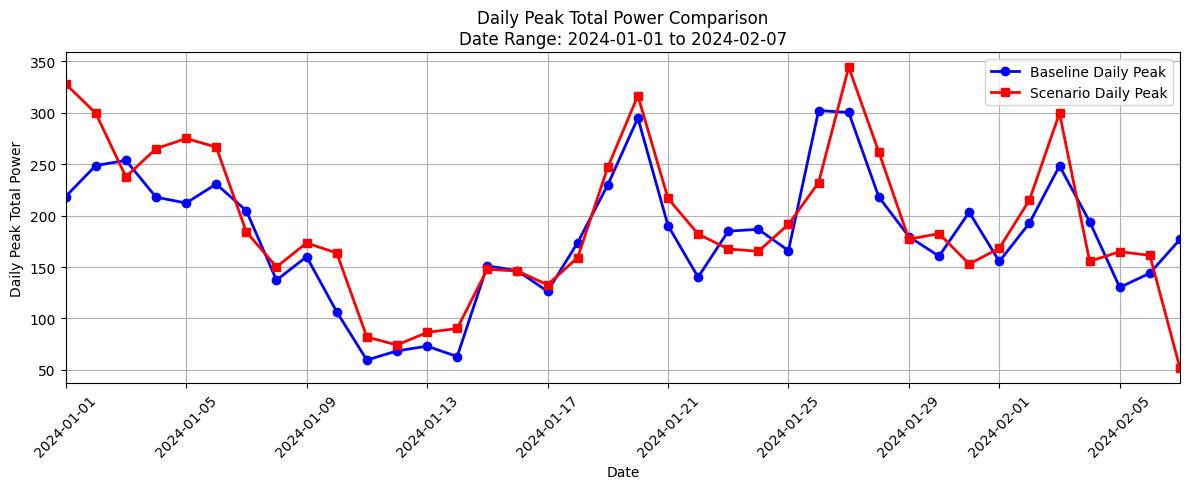

Average Waiting Time: Baseline = 0.02, Scenario = 0.00
EVs Left (%): Baseline = 0.05%, Scenario = 0.00%



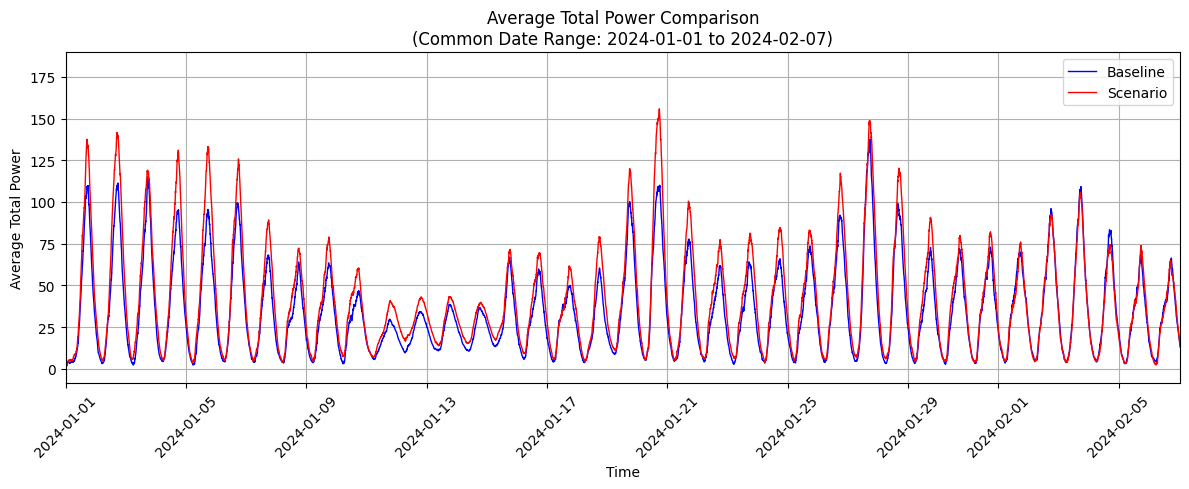


Comparing mcsim_sc_2 metrics with baseline:
=== Scenario Comparison ===
Scenario 2: Concentrated arrivals on a Friday before busy long weekend in July

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-06-21 00:00:00     0.323883
1 2024-06-21 00:05:00     0.323883
2 2024-06-21 00:10:00     0.323883
3 2024-06-21 00:15:00     0.482985
4 2024-06-21 00:20:00     0.430572

Average Daily Peak Power (over scenario range):
   Baseline = 299.53
   Scenario = 285.83



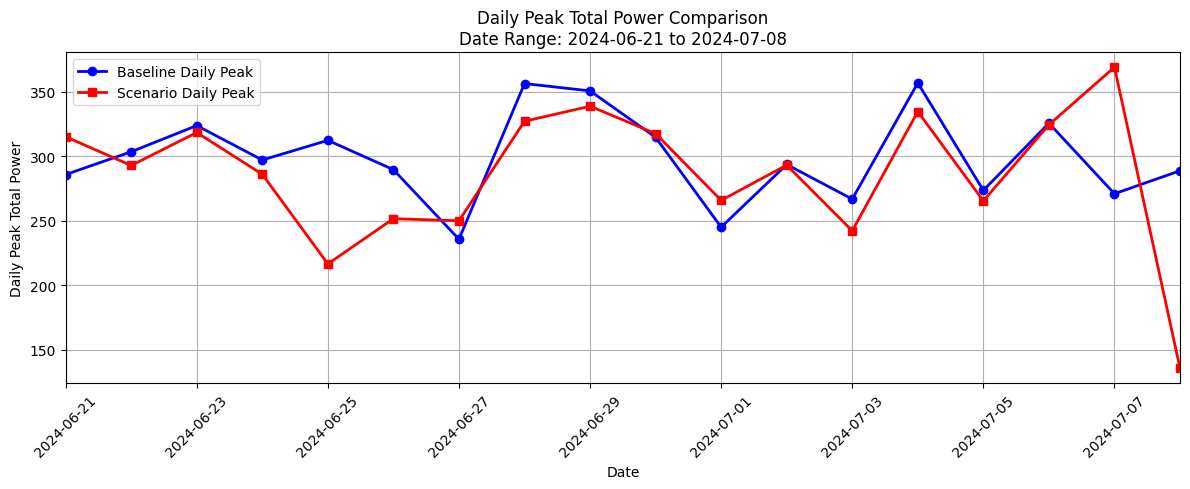

Average Waiting Time: Baseline = 0.02, Scenario = 0.04
EVs Left (%): Baseline = 0.05%, Scenario = 0.08%



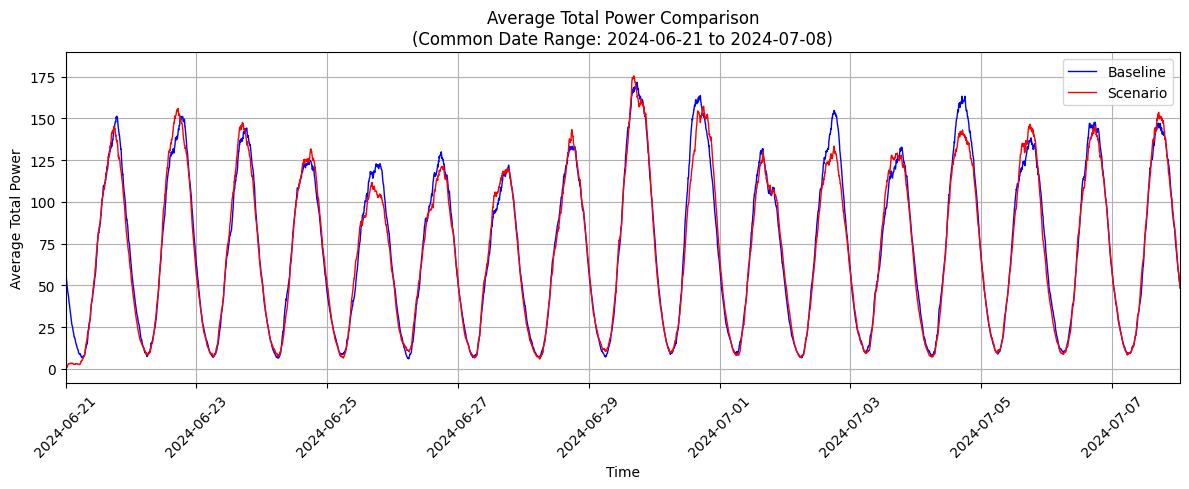


Comparing mcsim_sc_3 metrics with baseline:
=== Scenario Comparison ===
Scenario 3: EV rush on Dec weekend w/ concentrated arrivals and overnight visitors

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-12-13 00:00:00     0.837133
1 2024-12-13 00:05:00     0.837133
2 2024-12-13 00:10:00     0.742078
3 2024-12-13 00:15:00     0.742078
4 2024-12-13 00:20:00     1.015951

Average Daily Peak Power (over scenario range):
   Baseline = 225.16
   Scenario = 223.24



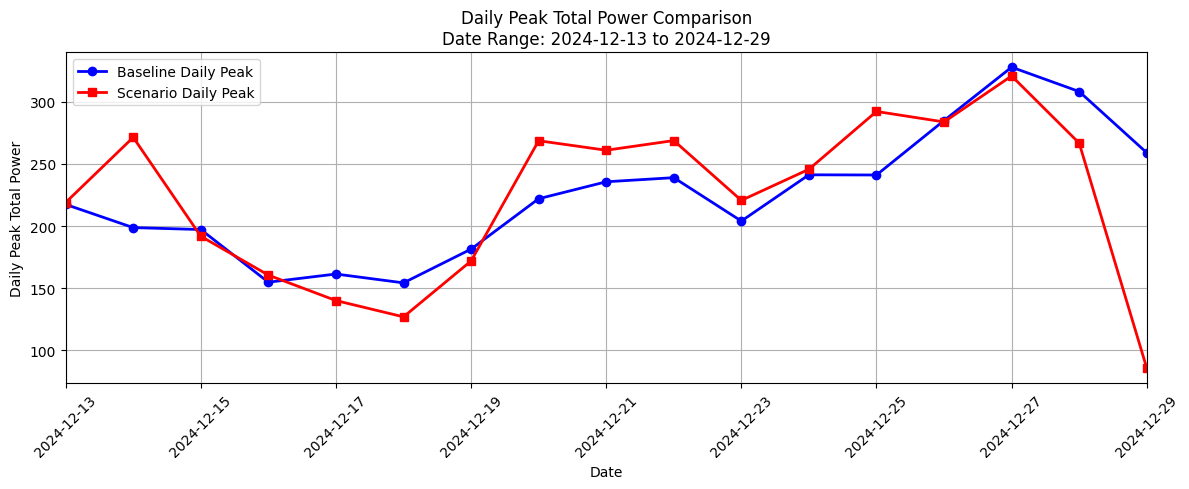

Average Waiting Time: Baseline = 0.02, Scenario = 0.01
EVs Left (%): Baseline = 0.05%, Scenario = 0.01%



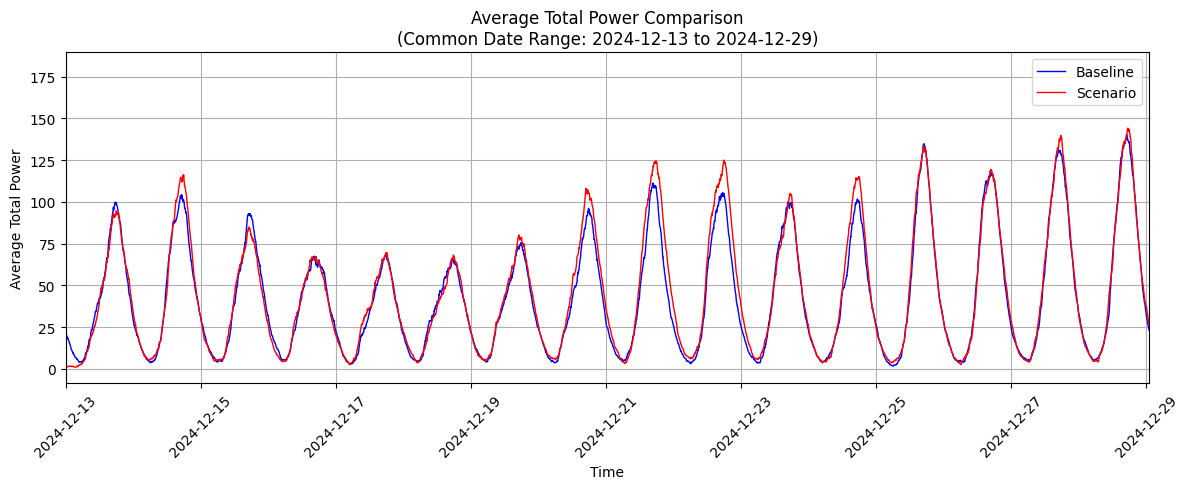


Comparing mcsim_sc_4 metrics with baseline:
=== Scenario Comparison ===
Scenario 4: Regular Jan weekend w/ downed CPs and power throttling

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-01-12 00:00:00     0.000000
1 2024-01-12 00:05:00     0.000000
2 2024-01-12 00:10:00     0.000000
3 2024-01-12 00:15:00     0.000000
4 2024-01-12 00:20:00     0.095935

Average Daily Peak Power (over scenario range):
   Baseline = 177.36
   Scenario = 159.65



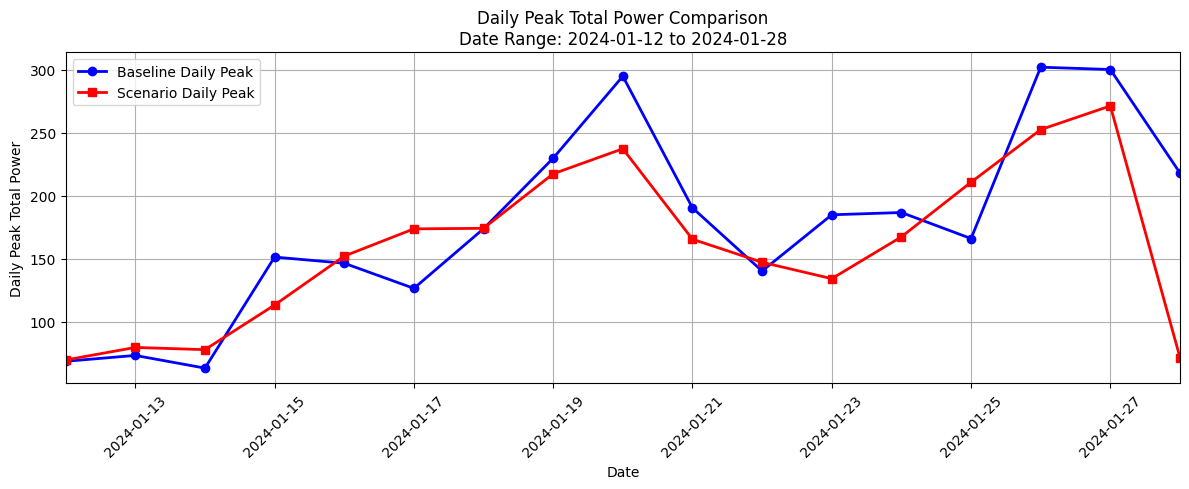

Average Waiting Time: Baseline = 0.02, Scenario = 0.02
EVs Left (%): Baseline = 0.05%, Scenario = 0.23%



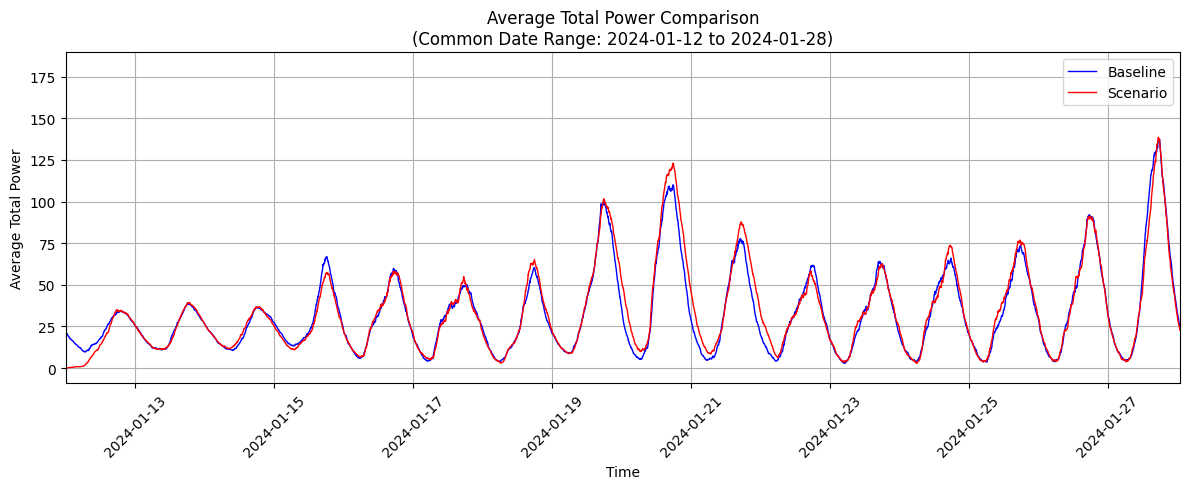


Comparing mcsim_sc_5 metrics with baseline:
=== Scenario Comparison ===
Scenario 5: Stat holiday peak traffic

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-05-10 00:00:00     0.606219
1 2024-05-10 00:05:00     0.606219
2 2024-05-10 00:10:00     0.606219
3 2024-05-10 00:15:00     0.842823
4 2024-05-10 00:20:00     1.280813

Average Daily Peak Power (over scenario range):
   Baseline = 239.86
   Scenario = 225.08



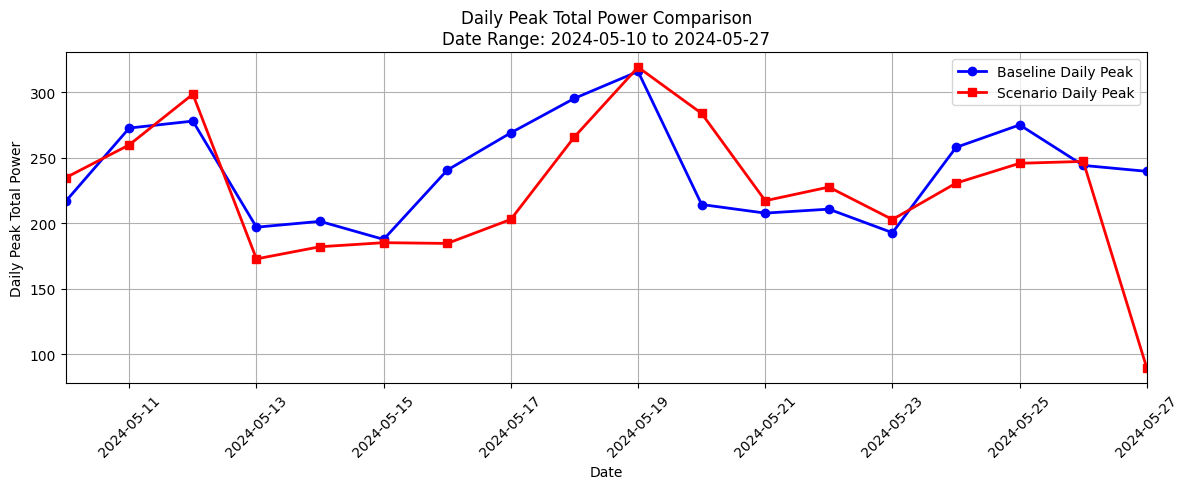

Average Waiting Time: Baseline = 0.02, Scenario = 0.02
EVs Left (%): Baseline = 0.05%, Scenario = 0.04%



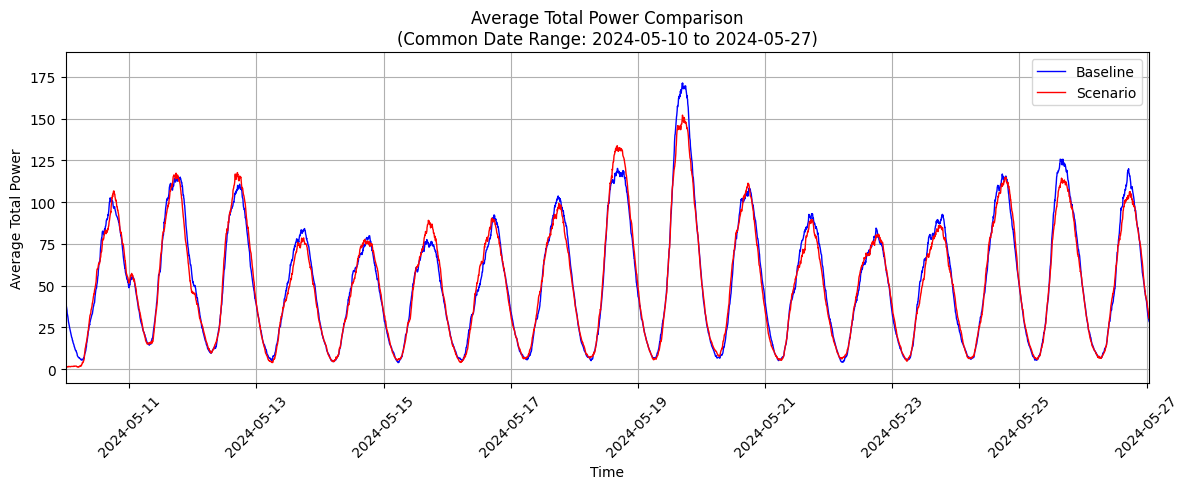


Comparing mcsim_sc_6 metrics with baseline:
=== Scenario Comparison ===
Scenario 6: Extreme cold snap (-30C) in February

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-01-25 00:00:00     0.235185
1 2024-01-25 00:05:00     0.235185
2 2024-01-25 00:10:00     0.235185
3 2024-01-25 00:15:00     0.235185
4 2024-01-25 00:20:00     0.439807

Average Daily Peak Power (over scenario range):
   Baseline = 200.00
   Scenario = 194.22



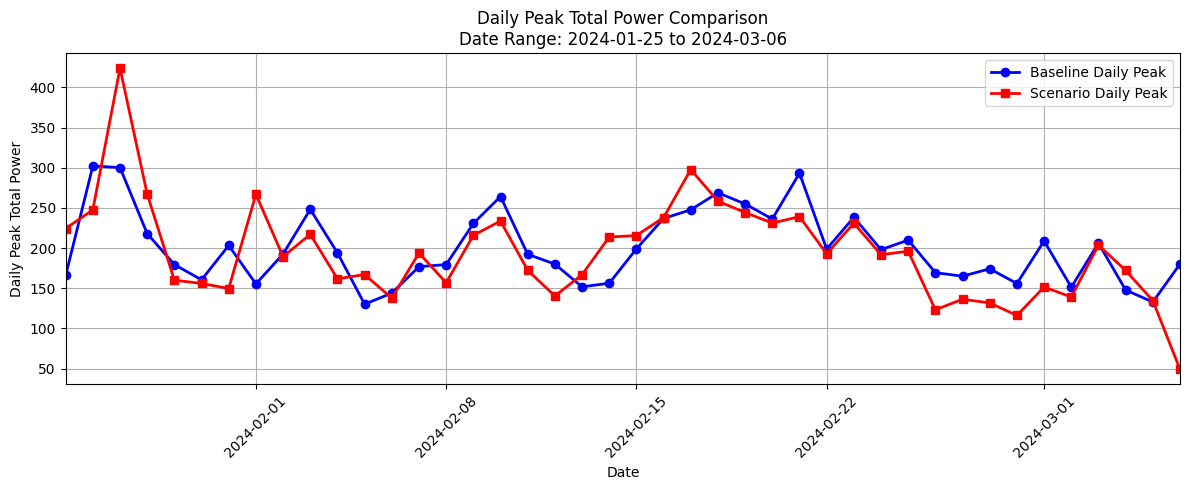

Average Waiting Time: Baseline = 0.02, Scenario = 0.06
EVs Left (%): Baseline = 0.05%, Scenario = 0.34%



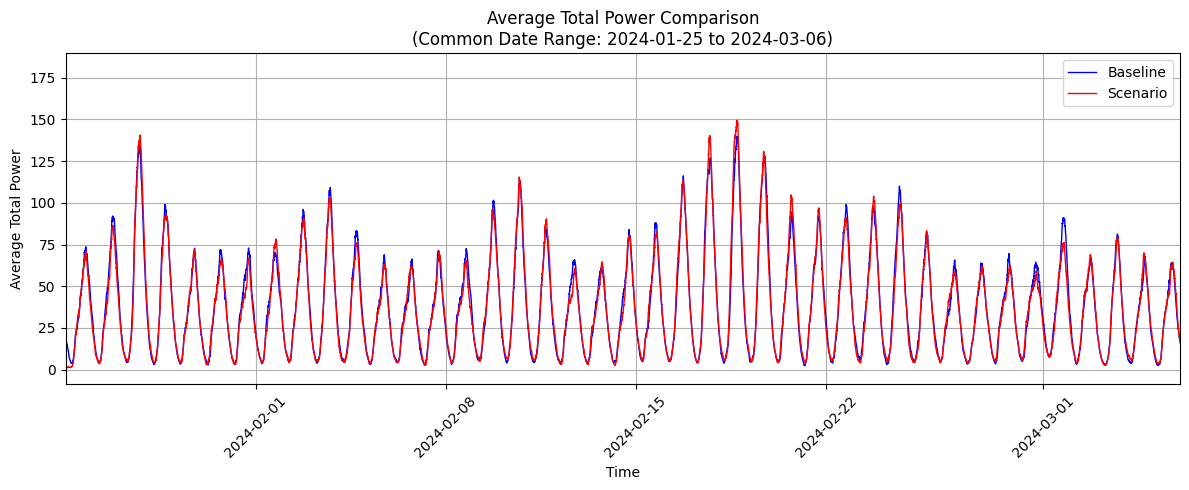


Comparing mcsim_sc_7 metrics with baseline:
=== Scenario Comparison ===
Scenario 7: Heat wave (35C+) in August

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-07-25 00:00:00     0.167760
1 2024-07-25 00:05:00     0.409422
2 2024-07-25 00:10:00     0.409422
3 2024-07-25 00:15:00     0.409422
4 2024-07-25 00:20:00     0.409422

Average Daily Peak Power (over scenario range):
   Baseline = 304.93
   Scenario = 240.21



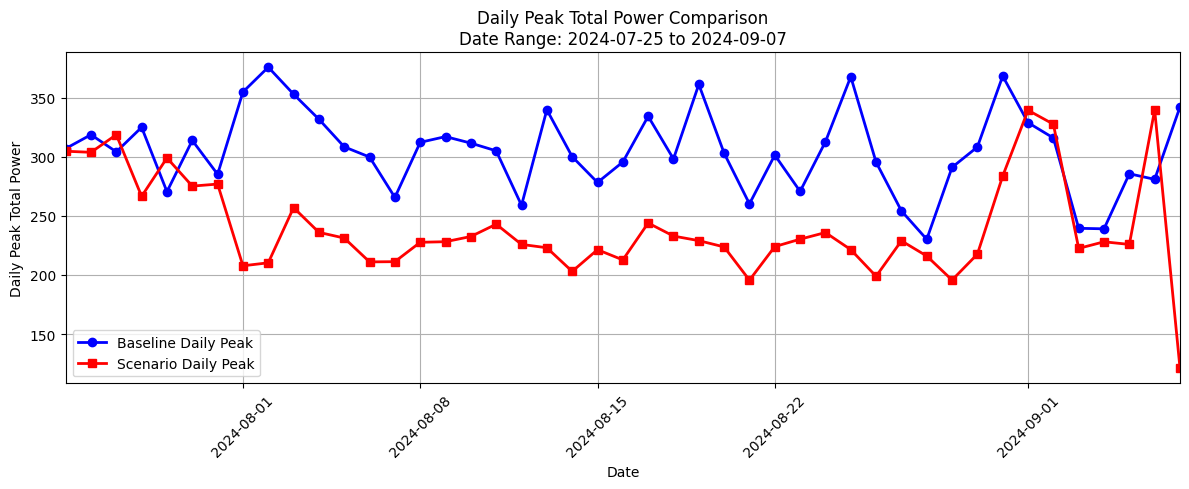

Average Waiting Time: Baseline = 0.02, Scenario = 0.46
EVs Left (%): Baseline = 0.05%, Scenario = 1.08%



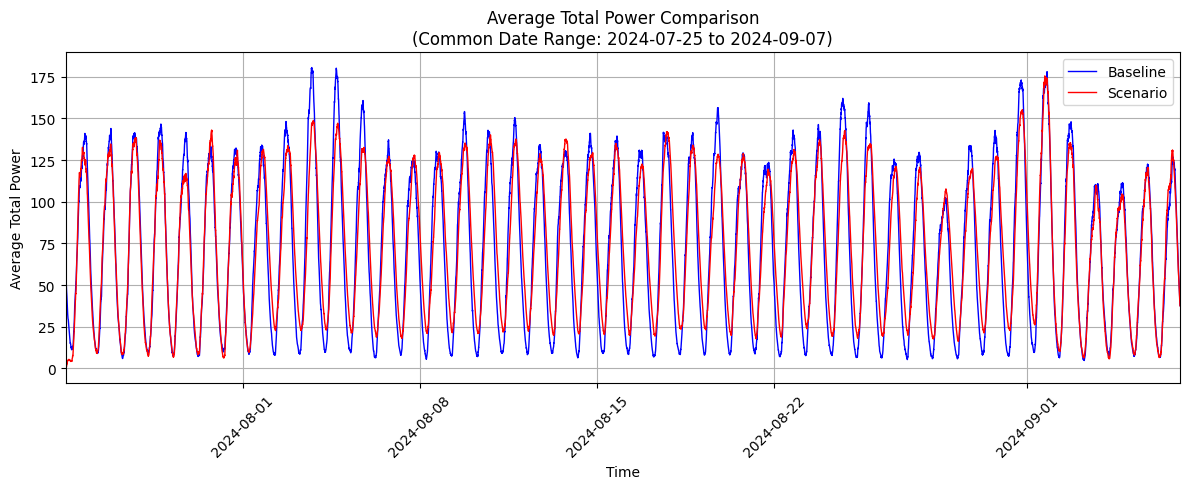


Comparing mcsim_sc_8 metrics with baseline:
=== Scenario Comparison ===
Scenario 8: Planned maintenance outage OR grid failure in November

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-10-25 00:00:00     0.000000
1 2024-10-25 00:05:00     0.000000
2 2024-10-25 00:10:00     0.000000
3 2024-10-25 00:15:00     0.152709
4 2024-10-25 00:20:00     0.354801

Average Daily Peak Power (over scenario range):
   Baseline = 184.17
   Scenario = 131.65



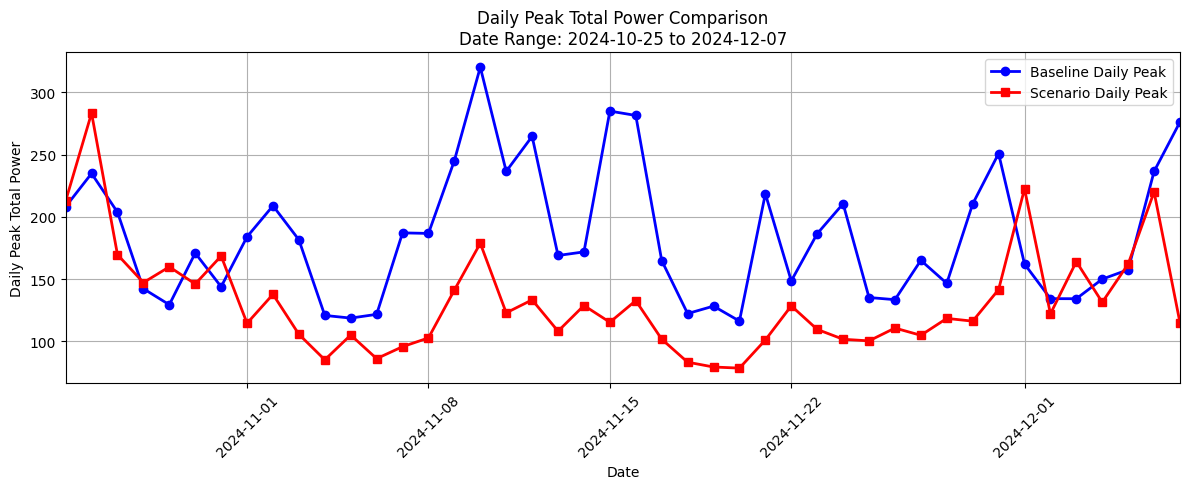

Average Waiting Time: Baseline = 0.02, Scenario = 0.42
EVs Left (%): Baseline = 0.05%, Scenario = 3.11%



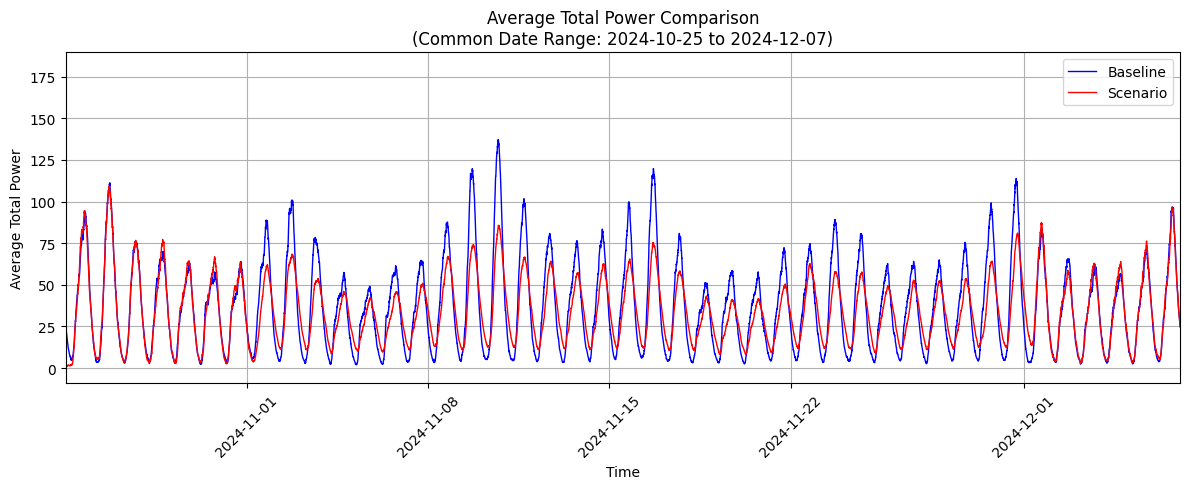


Comparing mcsim_sc_9 metrics with baseline:
=== Scenario Comparison ===
Scenario 9: Mass charger failures on busy weekend in July

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-06-21 00:00:00     0.527032
1 2024-06-21 00:05:00     0.527032
2 2024-06-21 00:10:00     0.527032
3 2024-06-21 00:15:00     0.527032
4 2024-06-21 00:20:00     0.527032

Average Daily Peak Power (over scenario range):
   Baseline = 299.53
   Scenario = 287.84



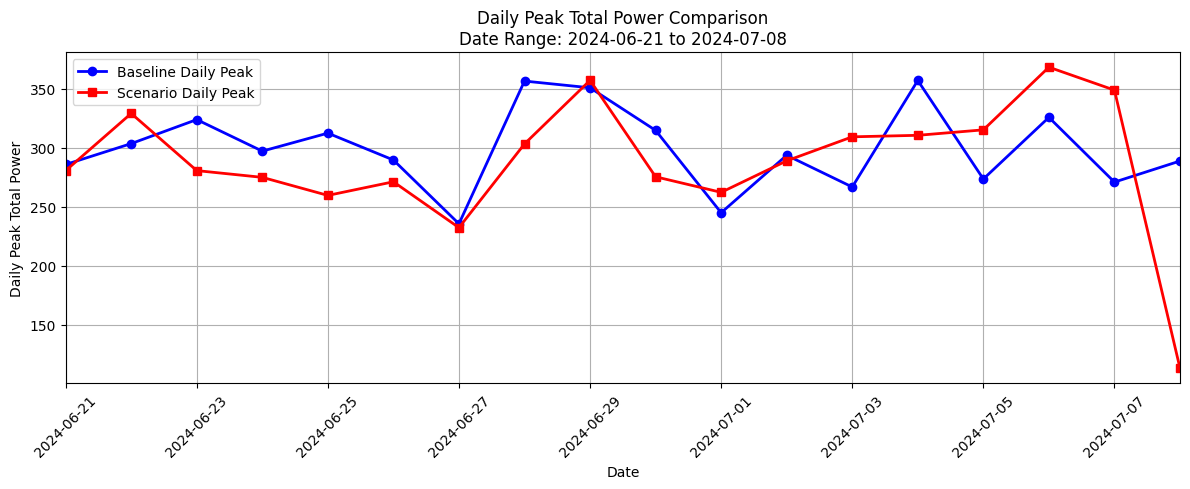

Average Waiting Time: Baseline = 0.02, Scenario = 0.31
EVs Left (%): Baseline = 0.05%, Scenario = 1.59%



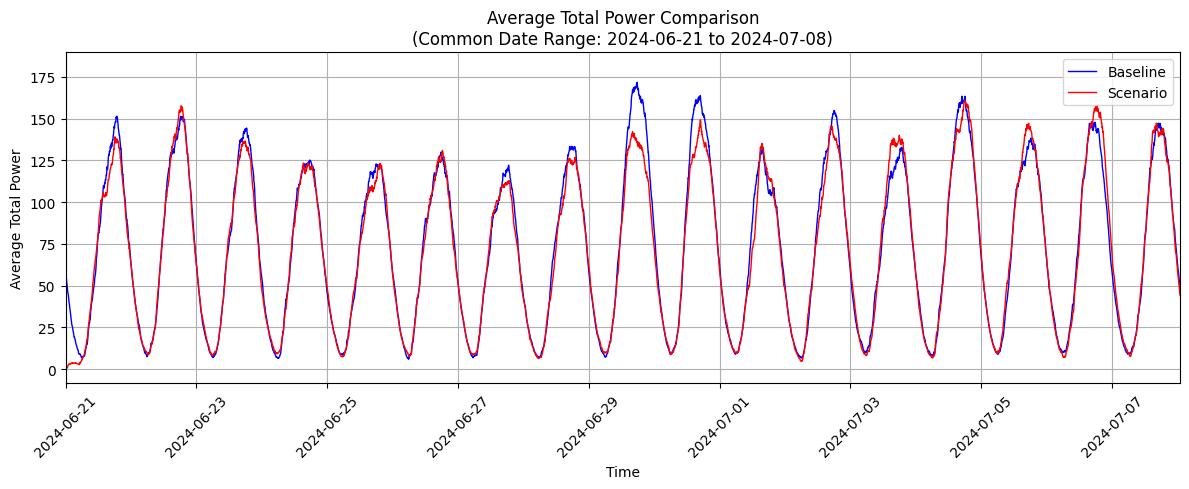


Comparing mcsim_sc_10 metrics with baseline:
=== Scenario Comparison ===
Scenario 10: Event day trippers on June weekend

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-05-25 00:00:00     0.000000
1 2024-05-25 00:05:00     0.000000
2 2024-05-25 00:10:00     0.068101
3 2024-05-25 00:15:00     0.068101
4 2024-05-25 00:20:00     0.824093

Average Daily Peak Power (over scenario range):
   Baseline = 250.01
   Scenario = 235.18



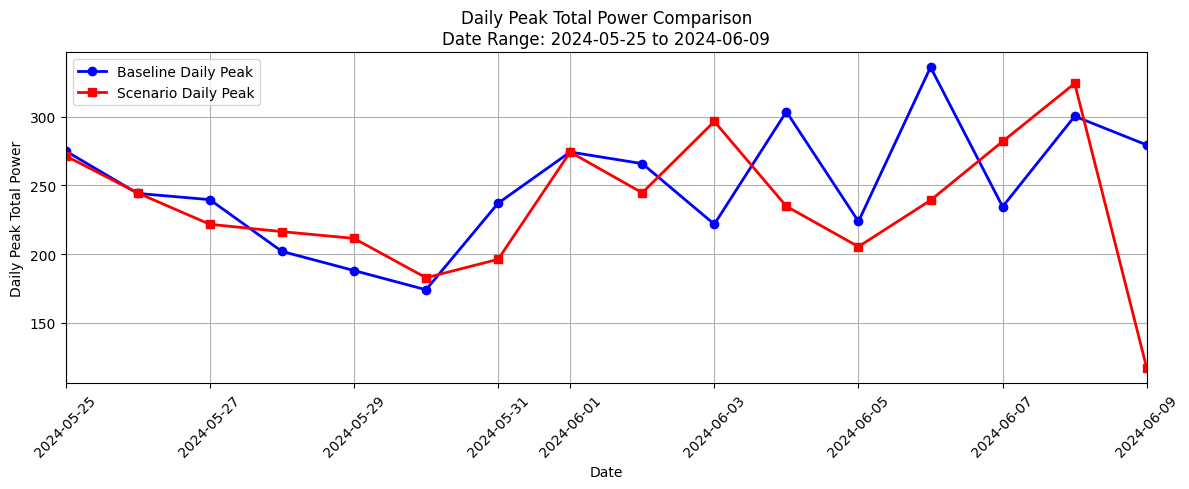

Average Waiting Time: Baseline = 0.02, Scenario = 0.01
EVs Left (%): Baseline = 0.05%, Scenario = 0.02%



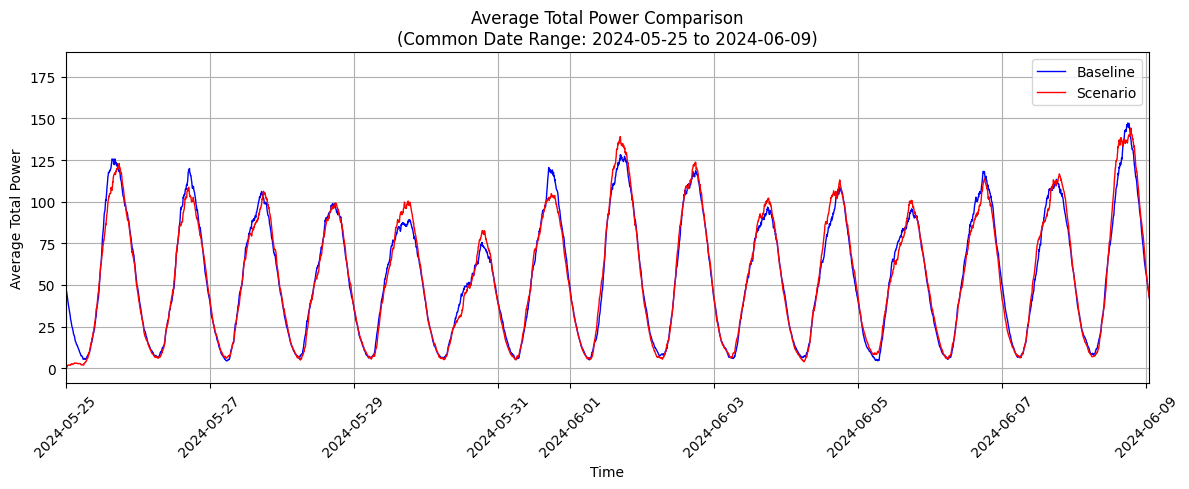


Comparing mcsim_sc_11 metrics with baseline:
=== Scenario Comparison ===
Scenario 11: Charging price increase (shift to slow chargers)

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.240862
1 2024-01-01 00:05:00     0.732340
2 2024-01-01 00:10:00     0.938823
3 2024-01-01 00:15:00     0.938823
4 2024-01-01 00:20:00     1.310591

Average Daily Peak Power (over scenario range):
   Baseline = 229.59
   Scenario = 225.79



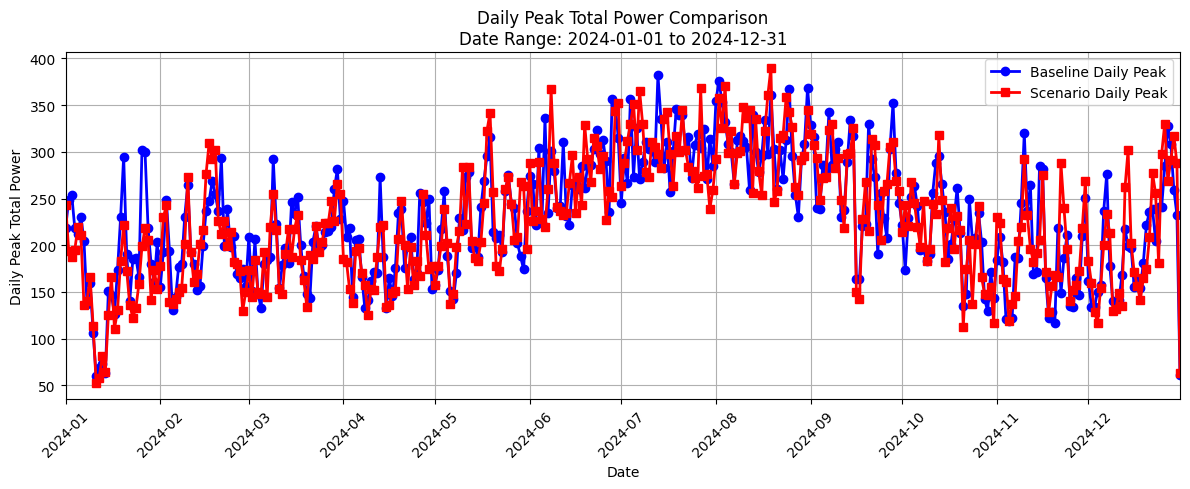

Average Waiting Time: Baseline = 0.02, Scenario = 0.02
EVs Left (%): Baseline = 0.05%, Scenario = 0.04%



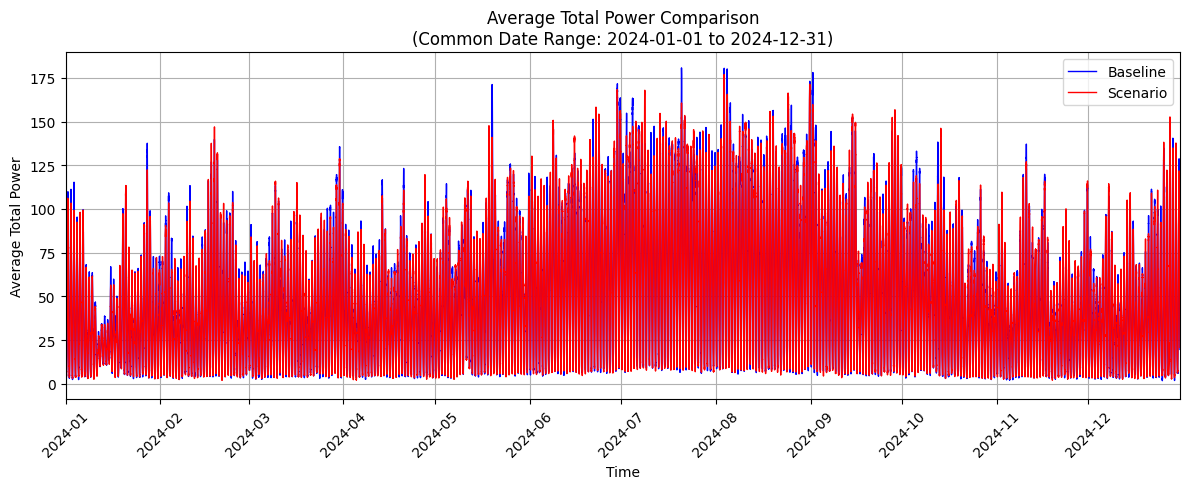


Comparing mcsim_sc_12 metrics with baseline:
=== Scenario Comparison ===
Scenario 12: Discounted fast charging

Average Power (first few rows):
Baseline:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.501768
1 2024-01-01 00:05:00     0.736873
2 2024-01-01 00:10:00     0.736873
3 2024-01-01 00:15:00     0.979636
4 2024-01-01 00:20:00     1.114913
Scenario:
            TimeStamp  Total Power
0 2024-01-01 00:00:00     0.000000
1 2024-01-01 00:05:00     0.531118
2 2024-01-01 00:10:00     1.362652
3 2024-01-01 00:15:00     1.362652
4 2024-01-01 00:20:00     1.362652

Average Daily Peak Power (over scenario range):
   Baseline = 180.25
   Scenario = 195.58



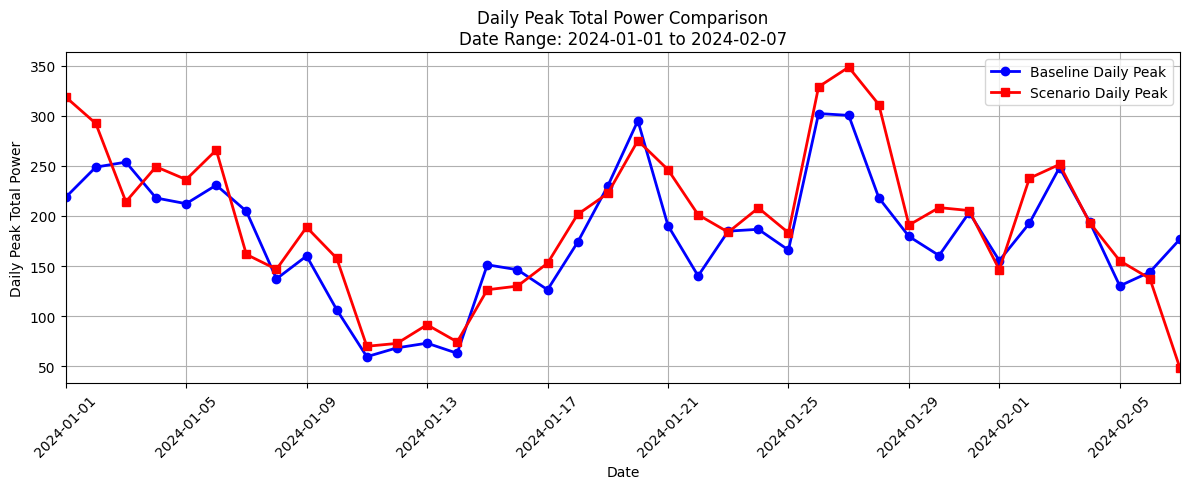

Average Waiting Time: Baseline = 0.02, Scenario = 0.02
EVs Left (%): Baseline = 0.05%, Scenario = 0.01%



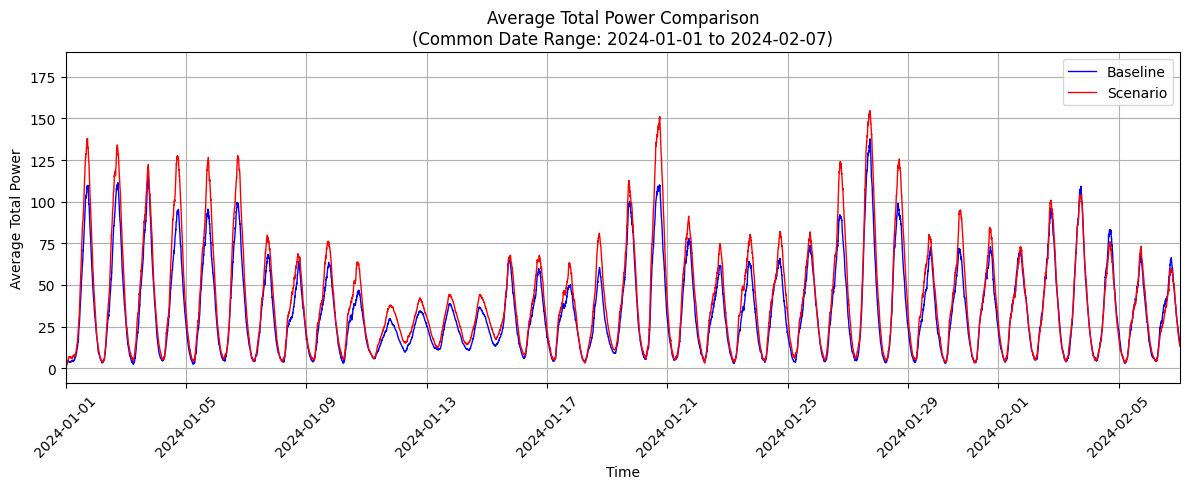

In [61]:
baseline_metrics = scenario_metrics.get('mcsim_sc_0')
i=1
for sim_name, m in scenario_metrics.items():
    if sim_name == 'mcsim_sc_0':
        continue
    print(f"\nComparing {sim_name} metrics with baseline:")
    compare_simulation_metrics(baseline_metrics, m, scenarios, i)
    i += 1


In [ ]:
# Plotting functions for load profiles
def plot_load_profiles(sim_obj, metric='Total Power'):
    """
    Plot load profiles for all simulation runs in sim_obj.
    
    Instead of plotting an average curve, this function overlays each simulation's 
    load profile using very thin, semi-transparent lines so that you can see the distribution.
    
    Parameters:
      sim_obj: An instance of MonteCarloSimulator.
      metric (str): The metric column to plot (default 'Total Power').
    """
    plt.figure(figsize=(12,6))
    
    # Iterate over each simulation in the MonteCarloSimulator instance.
    for sim in sim_obj.simulations:
        if hasattr(sim, 'result_df'):
            df = sim.result_df.copy()
            df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
            plt.plot(df['TimeStamp'], df[metric], color='gray', linewidth=0.5, alpha=0.5)
    
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.title(f"Load Profile Distribution ({metric})")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_zoomed_load_profiles(sim_obj, zoom_ranges, metric='Total Power'):
    """
    Plot zoomed load profiles for a set of date ranges.
    
    For each tuple (start_date, end_date) in zoom_ranges, this function creates
    a separate plot of load profiles (using thin lines) restricted to that period.
    
    Parameters:
      sim_obj: An instance of MonteCarloSimulator.
      zoom_ranges (list of tuples): Each tuple is (start_date, end_date). Dates
                                    may be strings or pd.Timestamp objects.
      metric (str): The metric column to plot (default 'Total Power').
    """
    for z_start, z_end in zoom_ranges:
        z_start = pd.to_datetime(z_start)
        z_end = pd.to_datetime(z_end)
        plt.figure(figsize=(12,6))
        for sim in sim_obj.simulations:
            if hasattr(sim, 'result_df'):
                df = sim.result_df.copy()
                df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
                # Filter for the zoom period.
                mask = (df['TimeStamp'] >= z_start) & (df['TimeStamp'] <= z_end)
                df_zoom = df[mask]
                plt.plot(df_zoom['TimeStamp'], df_zoom[metric], color='gray', linewidth=0.5, alpha=0.5)
        plt.xlabel("Time")
        plt.ylabel(metric)
        plt.title(f"Zoomed Load Profile Distribution ({metric})\nFrom {z_start.date()} to {z_end.date()}")
        plt.xticks(rotation=45)
        plt.xlim([z_start, z_end])
        plt.grid(True)
        plt.tight_layout()
        plt.show()


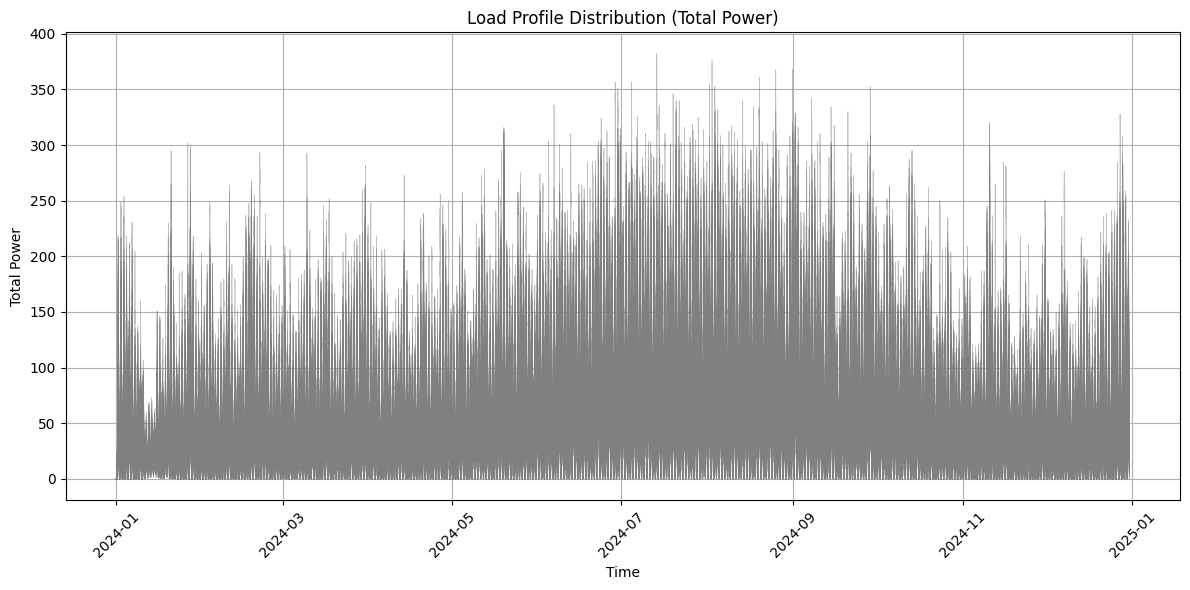

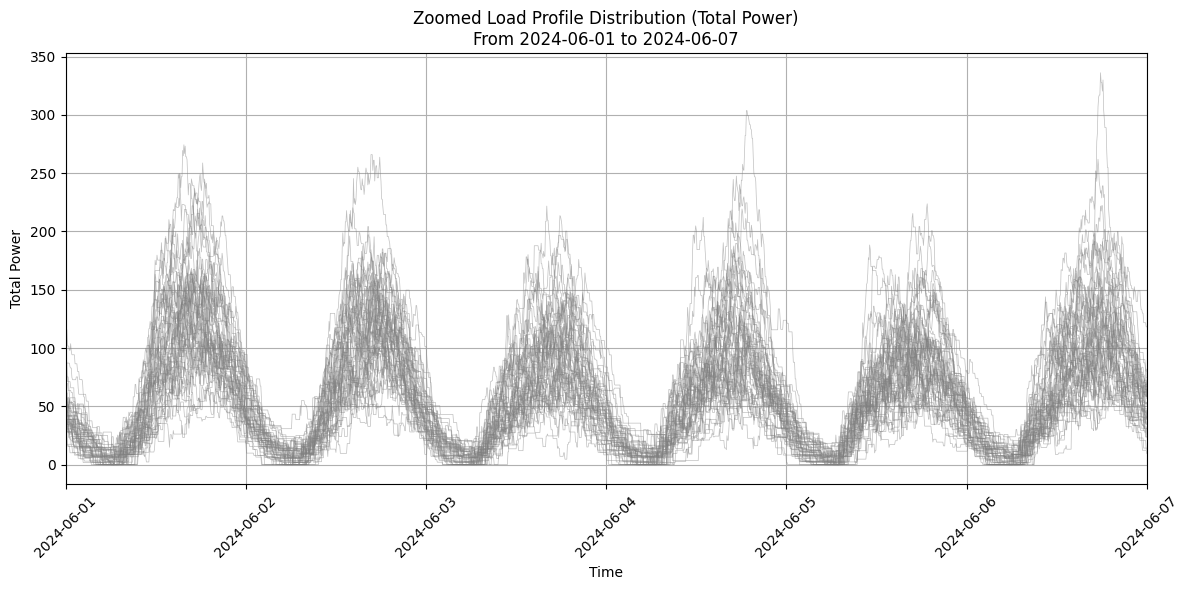

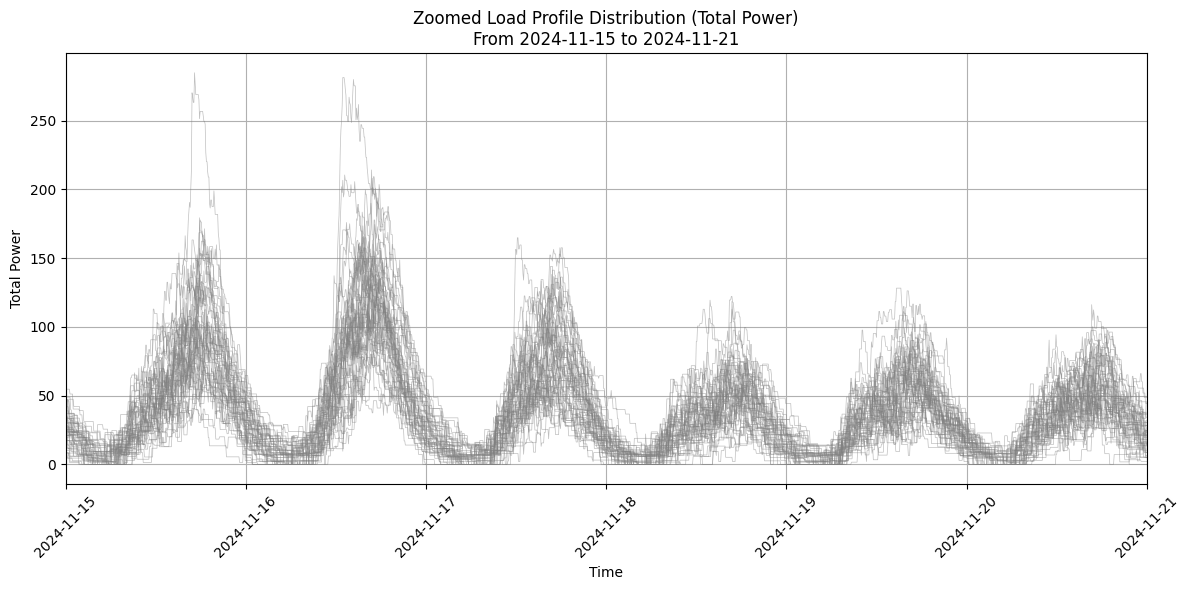

In [64]:
# For example, choose scenario 'mcsim_sc_3':
sim_obj = scenario_simulations.get('mcsim_sc_0')
if sim_obj is not None:
    # Plot all simulation curves (load profile distribution).
    plot_load_profiles(sim_obj, metric='Total Power')
    
    # Define a list of date ranges to zoom in on.
    # For example, if you wish to inspect two weeks:
    zoom_ranges = [('2024-06-01', '2024-06-07'), ('2024-11-15', '2024-11-21')]
    plot_zoomed_load_profiles(sim_obj, zoom_ranges, metric='Total Power')
else:
    print("Simulation object for scenario 'mcsim_sc_3' not found.")

## Scenario Analysis (IN TESTING)

Broad code structure:

I. Define lists & variables
  1. All scenario combinations
  2. Simulation time ranges
  3. Number of runs

II. Initiate loop

  1. Clear previous scenario simulation object from memory (try to keep my computer from being overloaded)
  2. Load current scenario from dataframe
  3. Initialize MCS w/ scenario parameters
  4. Run MCS for desired number of runs
  5. Load & calculate key metrics
  6. Calculate significance of scenario (save into list, where its index corresponds with the scenario number, which won't be cleared from memory)
  7. Save outputs (& maybe simulation object) to disc
  8. Loop back to 1

III. Present the most significant scenarios

In [23]:
import itertools

In [42]:
simulation_periods = [
    ("2023-12-15", "2024-01-15"),
    ("2024-06-27", "2024-09-03"),
]
start, end = simulation_periods[0]

vvd = [None, {'x_total': 0.9, 'y_density': 0.9, 'start_date': start, 'end_date': end}]
evp = [None, {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': start, 'end_date': end}]
t = [None, {'temp_delta': 5.0, 'start_date': start, 'end_date': end}]
cp = [None, {'reduction_factor': 0.78, 'start_date': start, 'end_date': end}]
pt = [None, {'throttle_value': 0.3, 'start_date': start, 'end_date': end}]
vtr = [None, {'ratio': [0.9, 0.1], 'start_date': start, 'end_date': end}]
soc = [None, {'soc_clip': 0.3, 'start_date': start, 'end_date': end}]
clp = [None, {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': start, 'end_date': end}]
vars_lists = {
    'vvd': vvd,
    'evp': evp,
    't':   t,
    'cp':  cp,
    'pt':  pt,
    'vtr': vtr,
    'soc': soc,
    'clp': clp
}


In [ ]:
# I. Define lists & variables
# a. All scenario combinations (8 binary variables)

# Generate all 2⁸ combinations of 0/1:
bit_combos = list(itertools.product([0,1], repeat=len(vars_lists)))

# Build a DataFrame where each row is the merged dict of active extremes:
"""
scenario_dicts = []
for bits in bit_combos:
    params = {}
    for bit, var_list in zip(bits, scenario_lists):
        if bit == 1:
            params.update(var_list[1])
    scenario_dicts.append(params)
    """

scenario_df = pd.DataFrame(bit_combos, columns=vars_lists.keys())
for col, lst in vars_lists.items():
    scenario_df[col] = scenario_df[col].apply(lambda bit: lst[bit])

# Prepare storage for results
results = []

# II. Initiate loop
for idx, scenario in scenario_df.iterrows():
    print(f"Running scenario {idx + 1}/{len(scenario_df)}: {scenario.to_dict()}")

    # 1. Clear previous data (no special action in Python; reassign variables)
    # 2. Load current scenario from dataframe (we already have `scenario`)

    # 3. Initialize MCS w/ scenario parameters
    # Map scenario bits to your model parameters here
    
    if scenario['vvd'] is not None:
        modified_df = modify_recent_traffic_profiles(df1, 
                                                    months=13, 
                                                    start_date=start, 
                                                    end_date=end,
                                                    x_total=scenario['vvd']['x_total'],
                                                    y_density=scenario['vvd']['y_density'],
                                                    random_state=42)
    if scenario['t'] is not None:
        modified_temp_red_df = modify_temperatures_and_reductions(
            temp_red_df,
            start_date=start,
            end_date=end,
            temp_delta=scenario['t']['temp_delta']
        )

    mcsim = MonteCarloSimulator(
        df=df,
        level_pub=[0, 27],
        level_pri=[0, 26],
        sims=15,
        ev_pen=0.0038,
        charger_weights=CHARGER_WEIGHTS_A,
        rdf=temp_red_df,
        disable_tqdm=False,
        rel_err_thresh=0.01
    )
    
    # Set date ranges or other params
    mcsim.set_simulation_date_range(start_date=start, end_date=end)

    if pd.notnull(scenario['pt']):
        mcsim.set_power_throttle(**scenario['pt'])
    if pd.notnull(scenario['vtr']):
        mcsim.set_visit_ratio(**scenario['vtr'])
    if pd.notnull(scenario['soc']):
        mcsim.set_lower_soc(**scenario['soc'])
    if pd.notnull(scenario['cp']):
        mcsim.set_cp_reduction_range(**scenario['cp'])
    if pd.notnull(scenario['clp']):
        mcsim.set_charger_weights_override(**scenario['clp'])
    if pd.notnull(scenario['evp']):
        mcsim.adjust_ev_penetration(**scenario['evp'])

    # 4. Run MCS for desired number of runs
    avg_power, avg_ev_power, all_df, total_power = mcsim.run_simulations()

    # 5. Load & calculate key metrics
    metrics = mcsim.get_output_metrics()
    # e.g., peak power daily average
    peak_power = metrics['Peak Power']['Total Power'].mean() if not metrics['Peak Power'].empty else None
    average_power = metrics['Average Power']['Total Power'].mean() if not metrics['Average Power'].empty else None
    evs_left_pct = metrics['EVs Left']
    waiting_time = metrics['Waiting Time']


    # 6. Calculate significance of scenario (e.g., combined z-score)
    significance = peak_power * evs_left_pct * waiting_time * average_power# placeholder formula

    # Store results
    results.append({
        "scenario_idx": idx,
        **scenario.to_dict(),
        "peak_power_avg": peak_power,
        "average_power": average_power,
        "waiting_time": waiting_time,
        "evs_left_pct": evs_left_pct,
        "significance": significance
    })

    # 7. Save outputs (& maybe simulation object) to disk
    #timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    #with open(f"scenario_{idx}_sim.pkl", "wb") as f:
    #    pickle.dump(mcsim, f)
    results_df = pd.DataFrame(results)
    results_df.to_csv("scenario_analysis_results_2.csv", index=False)

# III. Present the most significant scenarios
results_df = pd.DataFrame(results)
top_scenarios = results_df.sort_values("significance", ascending=False).head(10)
import pprint
pprint.pprint(top_scenarios.to_dict(orient="records"))

Running scenario 1/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.23it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 2/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.24it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 3/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 4/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.12it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 5/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:10,  1.07s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 6/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 7/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.16it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 8/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:11,  1.19s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 9/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.31s/it]

Convergence achieved for Experience Score at simulation run 5.


Simulations:  93%|█████████▎| 14/15 [00:17<00:01,  1.37s/it]

Convergence achieved for Total Power at simulation run 14.


Running scenario 10/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:09,  1.06it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 11/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.14it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 12/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.22s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 13/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.14it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 14/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:07<00:14,  1.41s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 15/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:09,  1.02it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 16/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 17/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 18/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 19/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:12,  1.30s/it]

Convergence achieved for Experience Score at simulation run 5.


Convergence achieved for Total Power at simulation run 15.


Running scenario 20/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:12,  1.23s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 21/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.12s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 22/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Convergence achieved for Total Power at simulation run 5.
Convergence achieved for Experience Score at simulation run 5.


Running scenario 23/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.18it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 24/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.17s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 25/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.14s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 26/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 27/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.14s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 28/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.13s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 29/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.11it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 30/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.31s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 31/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.10it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 32/256: {'vvd': None, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.05s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 33/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.02s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 34/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.12it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 35/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.28s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 36/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.20s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 37/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.00s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 38/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.07it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 39/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.11s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 40/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.24s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 41/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 42/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.37s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 43/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 44/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.11it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 45/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:10,  1.00s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 46/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.12it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 47/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:09,  1.02it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 48/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:07<00:13,  1.38s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 49/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.03it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 50/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.10it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 51/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.07s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 52/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.09s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 53/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.22s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 54/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.11it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 55/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.06s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 56/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:12,  1.21s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 57/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 58/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:07<00:15,  1.51s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 59/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.05s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 60/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.20s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 61/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:09,  1.00it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 62/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.07it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 63/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:06<00:11,  1.19s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 64/256: {'vvd': None, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.12s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 65/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.10it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 66/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.32s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 67/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Convergence achieved for Experience Score at simulation run 5.


Simulations:  40%|████      | 6/15 [00:06<00:09,  1.07s/it]

Convergence achieved for Total Power at simulation run 6.


Running scenario 68/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.08s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 69/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.13it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 70/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.23it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 71/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:10,  1.08s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 72/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.22it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 73/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:15,  1.53s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 74/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.10s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 75/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.39s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 76/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.03s/it]

Convergence achieved for Total Power at simulation run 5.
Convergence achieved for Experience Score at simulation run 5.


Running scenario 77/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.12it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 78/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.26s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 79/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:07<00:13,  1.36s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 80/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 81/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 82/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.13it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 83/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 84/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.17s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 85/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.05s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 86/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.05it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 87/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 88/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.20s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 89/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.13s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 90/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.09it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 91/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.20s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 92/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.08it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 93/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.09s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 94/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.09it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 95/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.06s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 96/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

Convergence achieved for Experience Score at simulation run 5.


Simulations:  60%|██████    | 9/15 [00:09<00:05,  1.10it/s]

Convergence achieved for Total Power at simulation run 9.


Running scenario 97/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.13s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 98/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:12,  1.23s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 99/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:11,  1.17s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 100/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:15,  1.58s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 101/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.03s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 102/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.05s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 103/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.18s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 104/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.10it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 105/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:09,  1.02it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 106/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 107/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.07s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 108/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.11s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 109/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.10it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 110/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.06it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 111/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:10,  1.02s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 112/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.17it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 113/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:11,  1.19s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 114/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.28s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 115/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.18it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 116/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:07<00:15,  1.57s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 117/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.01it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 118/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.13s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 119/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:09,  1.02it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 120/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.14it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 121/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.10it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 122/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.02s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 123/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:09,  1.01it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 124/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:12,  1.21s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 125/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.18s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 126/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.03s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 127/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.16s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 128/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.18s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 129/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime.date(2024, 1, 4), datetime.date(2024, 1, 5), datetime.date(2024, 1, 6), datetime.date(2024, 1, 7), datetime.da

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 130/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.14s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 131/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime.date(2024, 1, 4), datetime.date(2024, 1, 5)

Simulations:  33%|███▎      | 5/15 [00:04<00:10,  1.05s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 132/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1,

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.14it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 133/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime.date(2024, 1, 4), datetime.date(2024, 1

Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.35s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 134/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024

Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.02s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 135/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.09it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 136/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.

Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.09s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 137/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime.date(2024, 1, 4), datetime.date(2024,

Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.06s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 138/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(20

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.11it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 139/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), dateti

Simulations:  33%|███▎      | 5/15 [00:06<00:14,  1.45s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 140/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetim

Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.02s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 141/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), da

Simulations:  33%|███▎      | 5/15 [00:05<00:13,  1.31s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 142/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), dat

Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.10s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 143/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 144/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12,

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.11s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 145/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime.date(2024, 1, 4), datetime.date(20

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.10s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 146/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date

Simulations:  33%|███▎      | 5/15 [00:06<00:15,  1.57s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 147/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), dat

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.20s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 148/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), date

Simulations:  33%|███▎      | 5/15 [00:05<00:12,  1.24s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 149/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2),

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.14s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 150/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), 

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.11it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 151/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.22s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 152/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.13it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 153/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.21it/s]

Convergence achieved for Experience Score at simulation run 5.


Convergence achieved for Total Power at simulation run 15.


Running scenario 154/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29)

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.23it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 155/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.13it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 156/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.23it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 157/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.15it/s]

Convergence achieved for Total Power at simulation run 5.
Convergence achieved for Experience Score at simulation run 5.


Running scenario 158/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.20it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 159/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), 

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.20it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 160/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datet

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.20it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 161/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime.date(2024, 1, 4), datetime.date(2024, 1, 

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.17it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 162/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.24it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 163/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.d

Simulations:  33%|███▎      | 5/15 [00:03<00:07,  1.27it/s]

Convergence achieved for Experience Score at simulation run 5.


Simulations:  60%|██████    | 9/15 [00:07<00:05,  1.15it/s]

Convergence achieved for Peak Power at simulation run 9.


Simulations:  87%|████████▋ | 13/15 [00:10<00:01,  1.22it/s]

Convergence achieved for Total Power at simulation run 13.


Running scenario 164/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.da

Simulations:  33%|███▎      | 5/15 [00:04<00:08,  1.17it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 165/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), dateti

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.09it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 166/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetim

Simulations:  33%|███▎      | 5/15 [00:05<00:10,  1.09s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 167/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.09it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 168/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27)

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.27s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 169/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), date

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.11s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 170/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datet

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.19s/it]

Convergence achieved for Experience Score at simulation run 5.


Simulations:  40%|████      | 6/15 [00:06<00:10,  1.12s/it]

Convergence achieved for Total Power at simulation run 6.


Running scenario 171/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.12s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 172/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 2

Simulations:  33%|███▎      | 5/15 [00:06<00:11,  1.20s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 173/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(20

Simulations:  33%|███▎      | 5/15 [00:08<00:17,  1.72s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 174/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 1

Simulations:  33%|███▎      | 5/15 [00:08<00:17,  1.71s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 175/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetim

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.70s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 176/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.dat

Simulations:  33%|███▎      | 5/15 [00:07<00:15,  1.57s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 177/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), d

Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.38s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 178/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), da

Simulations:  33%|███▎      | 5/15 [00:07<00:15,  1.51s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 179/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(202

Simulations:  33%|███▎      | 5/15 [00:05<00:12,  1.23s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 180/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12

Simulations:  33%|███▎      | 5/15 [00:06<00:15,  1.51s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 181/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date

Simulations:  33%|███▎      | 5/15 [00:07<00:13,  1.39s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 182/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.22s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 183/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), date

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.24s/it]

Convergence achieved for Peak Power at simulation run 5.
Convergence achieved for Experience Score at simulation run 5.


Running scenario 184/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.

Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.38s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 185/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.da

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.62s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 186/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(20

Simulations:  33%|███▎      | 5/15 [00:08<00:15,  1.59s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 187/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), da

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.70s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 188/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetim

Simulations:  33%|███▎      | 5/15 [00:08<00:17,  1.74s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 189/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28)

Simulations:  33%|███▎      | 5/15 [00:07<00:13,  1.35s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 190/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), dat

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.24s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 191/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023

Simulations:  33%|███▎      | 5/15 [00:07<00:16,  1.62s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 192/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12,

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.21s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 193/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetim

Simulations:  33%|███▎      | 5/15 [00:07<00:14,  1.48s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 194/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), dateti

Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.40s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 195/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024, 1

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 196/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28

Simulations:  33%|███▎      | 5/15 [00:06<00:14,  1.46s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 197/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(202

Simulations:  33%|███▎      | 5/15 [00:06<00:14,  1.44s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 198/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12

Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.36s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 199/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime

Simulations:  33%|███▎      | 5/15 [00:05<00:11,  1.13s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 200/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date

Simulations:  33%|███▎      | 5/15 [00:07<00:16,  1.62s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 201/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.21s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 202/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 

Simulations:  33%|███▎      | 5/15 [00:07<00:12,  1.28s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 203/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), dateti

Simulations:  33%|███▎      | 5/15 [00:09<00:17,  1.79s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 204/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.da

Simulations:  33%|███▎      | 5/15 [00:06<00:14,  1.43s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 205/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), da

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.63s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 206/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetim

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.23s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 207/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12

Simulations:  33%|███▎      | 5/15 [00:06<00:11,  1.19s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 208/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23)

Simulations:  33%|███▎      | 5/15 [00:07<00:13,  1.37s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 209/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.dat

Simulations:  33%|███▎      | 5/15 [00:07<00:13,  1.34s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 210/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(202

Simulations:  33%|███▎      | 5/15 [00:06<00:12,  1.23s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 211/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), dat

Simulations:  33%|███▎      | 5/15 [00:07<00:13,  1.34s/it]

Convergence achieved for Experience Score at simulation run 5.


Simulations:  40%|████      | 6/15 [00:08<00:12,  1.36s/it]

Convergence achieved for Total Power at simulation run 6.


Running scenario 212/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 213/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29),

Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.32s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 214/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), date

Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.38s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 215/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023,

Simulations:  33%|███▎      | 5/15 [00:06<00:15,  1.52s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 216/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 

Simulations:  33%|███▎      | 5/15 [00:06<00:14,  1.40s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 217/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29

Simulations:  33%|███▎      | 5/15 [00:07<00:14,  1.49s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 218/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), da

Simulations:  33%|███▎      | 5/15 [00:08<00:17,  1.72s/it]

Convergence achieved for Peak Power at simulation run 5.
Convergence achieved for Experience Score at simulation run 5.


Running scenario 219/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(202

Simulations:  33%|███▎      | 5/15 [00:07<00:15,  1.55s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 220/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12

Simulations:  33%|███▎      | 5/15 [00:06<00:15,  1.53s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 221/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date

Simulations:  33%|███▎      | 5/15 [00:08<00:17,  1.74s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 222/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023

Simulations:  33%|███▎      | 5/15 [00:08<00:15,  1.56s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 223/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), date

Simulations:  33%|███▎      | 5/15 [00:07<00:16,  1.68s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 224/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.

Simulations:  33%|███▎      | 5/15 [00:08<00:15,  1.53s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 225/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023, 12, 31), datetime.date(2024,

Simulations:  33%|███▎      | 5/15 [00:08<00:17,  1.72s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 226/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.61s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 227/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.d

Simulations:  33%|███▎      | 5/15 [00:07<00:15,  1.58s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 228/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2

Simulations:  33%|███▎      | 5/15 [00:08<00:15,  1.51s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 229/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), dateti

Simulations:  33%|███▎      | 5/15 [00:06<00:13,  1.35s/it]

Convergence achieved for Experience Score at simulation run 5.


Simulations:  47%|████▋     | 7/15 [00:09<00:11,  1.49s/it]

Convergence achieved for Total Power at simulation run 7.


Running scenario 230/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.da

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.65s/it]

Convergence achieved for Experience Score at simulation run 5.


Simulations:  60%|██████    | 9/15 [00:13<00:08,  1.40s/it]

Convergence achieved for Total Power at simulation run 9.


Running scenario 231/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27

Simulations:  33%|███▎      | 5/15 [00:09<00:18,  1.86s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 232/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), da

Simulations:  33%|███▎      | 5/15 [00:07<00:14,  1.46s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 233/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), date

Simulations:  33%|███▎      | 5/15 [00:07<00:14,  1.41s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 234/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.

Simulations:  33%|███▎      | 5/15 [00:08<00:17,  1.70s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 235/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 

Simulations:  33%|███▎      | 5/15 [00:07<00:14,  1.47s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 236/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), 

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 237/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 

Simulations:  33%|███▎      | 5/15 [00:07<00:14,  1.42s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 238/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 2

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.70s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 239/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.da

Simulations:  33%|███▎      | 5/15 [00:10<00:20,  2.03s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 240/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(20

Simulations:  33%|███▎      | 5/15 [00:09<00:18,  1.84s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 241/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), d

Simulations:  33%|███▎      | 5/15 [00:09<00:18,  1.86s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 242/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), dateti

Simulations:  33%|███▎      | 5/15 [00:09<00:19,  1.96s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 243/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 1

Simulations:  33%|███▎      | 5/15 [00:09<00:20,  2.05s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 244/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23

Simulations:  33%|███▎      | 5/15 [00:09<00:19,  1.95s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 245/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(202

Simulations:  33%|███▎      | 5/15 [00:10<00:20,  2.09s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 246/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12

Simulations:  33%|███▎      | 5/15 [00:09<00:19,  1.95s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 247/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime

Simulations:  33%|███▎      | 5/15 [00:08<00:16,  1.63s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 248/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date

Simulations:  33%|███▎      | 5/15 [00:09<00:19,  1.96s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 249/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2

Simulations:  33%|███▎      | 5/15 [00:09<00:19,  1.91s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 250/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 

Simulations:  33%|███▎      | 5/15 [00:08<00:13,  1.38s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 251/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), dateti

Simulations:  33%|███▎      | 5/15 [00:07<00:13,  1.31s/it]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 252/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': None, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.da

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.01it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 253/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), da

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.09it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 254/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetim

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.04it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 255/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12

Simulations:  33%|███▎      | 5/15 [00:05<00:09,  1.02it/s]

Convergence achieved for Experience Score at simulation run 5.


Running scenario 256/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18)

Simulations:  33%|███▎      | 5/15 [00:04<00:09,  1.01it/s]

Convergence achieved for Experience Score at simulation run 5.


[{'average_power': 39.54322705109127,
  'clp': None,
  'cp': {'end_date': '2024-01-15',
         'reduction_factor': 0.78,
         'start_date': '2023-12-15'},
  'evp': {'end_date': '2024-01-15',
          'method': 'normal',
          'start_date': '2023-12-15',
          'std': 0.003,
          'target_penetration': 0.01},
  'evs_left_pct': 0.132749236691889,
  'peak_power_avg': 139.21611280434652,
  'pt': {'end_date': '2024-01-15',
         'start_date': '2023-12-15',
         'throttle_value': 0.3},
  'scenario_idx': 222,
  'significance': 110.25503815988438,
  'soc': {'end_date': '2024-01-15',
          'soc_clip': 0.3,
          'start_date': '2023-12-15'},
  't': None,
  'vtr': {'end_date': '2024-01-15',
          'ratio': [0.9, 0.1],
          'start_date': '2023-12-15'},
  'vvd': {'end_date': '2024-01-15',
          'start_date': '2023-12-15',
          'x_total': 0.9,
          'y_density': 0.9},
  'waiting_time': 0.15087066329921575},
 {'average_power': 39.38432535598295,
 

In [49]:
scenario_indices = [222,78,110,206,230,6,239,142,207,15,150,174,204,181,103,76,143,238,175,79]

In [50]:
# I. Define lists & variables
# a. All scenario combinations (8 binary variables)

# Generate all 2⁸ combinations of 0/1:
bit_combos = list(itertools.product([0,1], repeat=len(vars_lists)))

# Build a DataFrame where each row is the merged dict of active extremes:
"""
scenario_dicts = []
for bits in bit_combos:
    params = {}
    for bit, var_list in zip(bits, scenario_lists):
        if bit == 1:
            params.update(var_list[1])
    scenario_dicts.append(params)
    """

scenario_df = pd.DataFrame(bit_combos, columns=vars_lists.keys())
for col, lst in vars_lists.items():
    scenario_df[col] = scenario_df[col].apply(lambda bit: lst[bit])

# Prepare storage for results
results = []

#⁠— If you only want to run a subset of scenarios:
#scenario_indices = [222,78,110,206,230,6,239,142,207,15,150,174,204,181,103,76,143,238,175,79]

# II. Initiate loop (filtered)
for idx in scenario_indices:
    scenario = scenario_df.loc[idx]
    print(f"Running scenario {idx + 1}/{len(scenario_df)}: {scenario.to_dict()}")

    # 1. Reset any previous modifications as needed
    # 2. Load current scenario…

    if scenario['vvd'] is not None:
        modified_df = modify_recent_traffic_profiles(
            df1, months=13, start_date=start, end_date=end,
            x_total=scenario['vvd']['x_total'],
            y_density=scenario['vvd']['y_density'],
            random_state=42
        )
    if scenario['t'] is not None:
        modified_temp_red_df = modify_temperatures_and_reductions(
            temp_red_df, start_date=start, end_date=end,
            temp_delta=scenario['t']['temp_delta']
        )

    mcsim = MonteCarloSimulator(
        df=df,
        level_pub=[0, 27],
        level_pri=[0, 26],
        sims=50,
        ev_pen=0.0038,
        charger_weights=CHARGER_WEIGHTS_A,
        rdf=temp_red_df,
        disable_tqdm=False,
        rel_err_thresh=0.01
    )
    mcsim.set_simulation_date_range(start_date=start, end_date=end)

    if scenario['pt'] is not None:
        mcsim.set_power_throttle(**scenario['pt'])
    if scenario['vtr'] is not None:
        mcsim.set_visit_ratio(**scenario['vtr'])
    if scenario['soc'] is not None:
        mcsim.set_lower_soc(**scenario['soc'])
    if scenario['cp'] is not None:
        mcsim.set_cp_reduction_range(**scenario['cp'])
    if scenario['clp'] is not None:
        mcsim.set_charger_weights_override(**scenario['clp'])
    if scenario['evp'] is not None:
        mcsim.adjust_ev_penetration(**scenario['evp'])

    # 4. Run MCS
    avg_power, avg_ev_power, all_df, total_power = mcsim.run_simulations()

    # 5. Extract metrics
    metrics = mcsim.get_output_metrics()
    peak_power    = metrics['Peak Power']['Total Power'].mean()     if not metrics['Peak Power'].empty else None
    average_power = metrics['Average Power']['Total Power'].mean()  if not metrics['Average Power'].empty else None
    evs_left_pct  = metrics['EVs Left']
    waiting_time  = metrics['Waiting Time']

    # 6. Compute significance
    significance = peak_power * evs_left_pct * waiting_time * average_power

    # 7. Store results
    results.append({
        "scenario_idx": idx,
        **scenario.to_dict(),
        "peak_power_avg": peak_power,
        "average_power": average_power,
        "waiting_time": waiting_time,
        "evs_left_pct": evs_left_pct,
        "significance": significance
    })

    # 8. Persist intermediate CSV
    pd.DataFrame(results).to_csv("scenario_analysis_results_2.csv", index=False)

# III. Show top 10
results_df    = pd.DataFrame(results)
top_scenarios = results_df.sort_values("significance", ascending=False).head(10)
import pprint
pprint.pprint(top_scenarios.to_dict(orient="records"))

Running scenario 223/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), date

Running scenario 79/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Running scenario 111/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Running scenario 207/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12

Running scenario 231/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27

Running scenario 7/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22


Running scenario 240/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(20

Running scenario 143/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2023

Running scenario 208/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23)

Running scenario 16/256: {'vvd': None, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22


Running scenario 151/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), datetime.date(2023, 12, 30), datetime.date(2

Running scenario 175/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetim

Running scenario 205/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12, 27), datetime.date(2023, 12, 28), datetime.date(2023, 12, 29), da

Running scenario 182/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': {'reduction_factor': 0.78, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023

Running scenario 104/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': None, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Running scenario 77/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': None, 'clp': None}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


Running scenario 144/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 26), datetime.date(2023, 12,

Running scenario 239/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': None}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.da

Running scenario 176/256: {'vvd': {'x_total': 0.9, 'y_density': 0.9, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'evp': None, 't': {'temp_delta': 5.0, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
No candidate days met thresholds. Using all days as fallback.
Days to modify (in recent data): [datetime.date(2023, 12, 15), datetime.date(2023, 12, 16), datetime.date(2023, 12, 17), datetime.date(2023, 12, 18), datetime.date(2023, 12, 19), datetime.date(2023, 12, 20), datetime.date(2023, 12, 21), datetime.date(2023, 12, 22), datetime.date(2023, 12, 23), datetime.date(2023, 12, 24), datetime.dat

Running scenario 80/256: {'vvd': None, 'evp': {'target_penetration': 0.01, 'method': 'normal', 'std': 0.003, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 't': None, 'cp': None, 'pt': {'throttle_value': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'vtr': {'ratio': [0.9, 0.1], 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'soc': {'soc_clip': 0.3, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}, 'clp': {'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}, 'start_date': '2023-12-15', 'end_date': '2024-01-15'}}
Simulation date range set to: 2024-01-01 to 2024-01-22
Adjusted EV In values for 360 rows between 2023-12-15 and 2024-01-15.


[{'average_power': 39.06879697656171,
  'clp': {'end_date': '2024-01-15',
          'start_date': '2023-12-15',
          'weights': {'Level 1': 0.9, 'Level 2': 0.3, 'Level 3': 0.1}},
  'cp': None,
  'evp': {'end_date': '2024-01-15',
          'method': 'normal',
          'start_date': '2023-12-15',
          'std': 0.003,
          'target_penetration': 0.01},
  'evs_left_pct': 0.05277259072826176,
  'peak_power_avg': 148.04260334442395,
  'pt': {'end_date': '2024-01-15',
         'start_date': '2023-12-15',
         'throttle_value': 0.3},
  'scenario_idx': 79,
  'significance': 65.51857916770669,
  'soc': {'end_date': '2024-01-15',
          'soc_clip': 0.3,
          'start_date': '2023-12-15'},
  't': None,
  'vtr': {'end_date': '2024-01-15',
          'ratio': [0.9, 0.1],
          'start_date': '2023-12-15'},
  'vvd': None,
  'waiting_time': 0.21465415702042973},
 {'average_power': 39.7145908986467,
  'clp': None,
  'cp': None,
  'evp': {'end_date': '2024-01-15',
          'met

In [29]:
scenario_results_1 = pd.read_csv("scenario_analysis_results_1.csv")
scenario_results_2 = pd.read_csv("scenario_analysis_results_2.csv")

In [61]:
scenario_results_1.head()

scenario_idx  vvd  evp    t   cp   pt  \
0             0  NaN  NaN  NaN  NaN  NaN   
1             1  NaN  NaN  NaN  NaN  NaN   
2             2  NaN  NaN  NaN  NaN  NaN   
3             3  NaN  NaN  NaN  NaN  NaN   
4             4  NaN  NaN  NaN  NaN  NaN   

                                                 vtr  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  {'ratio': [0.9, 0.1], 'start_date': '2023-12-1...   

                                                 soc  \
0                                                NaN   
1                                                NaN   
2  {'soc_clip': 0.3, 'start_date': '2023-12-15', ...   
3  {'soc_clip': 0.3, 'start_date': '2023-12-15', ...   
4                                                NaN   

                                                 clp  peak_power_avg  \
0                                                NaN      132.104598   
1  {'weights': {'Level 1': 0.9, 'Level 2': 0.3, '...      132.932709   
2                                                NaN      153.085854   
3  {'weights': {'Level 1': 0.9, 'Level 2': 0.3, '...      142.237866   
4                                                NaN      144.178316   

   average_power  waiting_time  evs_left_pct  significance  sig no wait  \
0      31.006689           0.0           0.0           0.0          0.0   
1      30.010163           0.0           0.0           0.0          0.0   
2      37.726807           0.0           0.0           0.0          0.0   
3      34.733066           0.0           0.0           0.0          0.0   
4      33.940489           0.0           0.0           0.0          0.0   

    sig powers  
0  4096.126115  
1  3989.332328  
2  5775.440511  
3  4940.357191  
4  4893.482529

In [150]:
# Assume scenario_results_1 is already in your workspace
df = scenario_results_1.copy()

# Define the metrics and their weights
weights = {
    'peak_power_avg': 1.0,
    'average_power':  1.0,
    'waiting_time':   1.0,
    'evs_left_pct':   1.0
}

# Min–max scale each column into [0,1]
for col in weights:
    mn, mx = df[col].min(), df[col].max()
    df[f"{col}_scaled"] = (df[col] - mn) / (mx - mn)

# Compute the weighted sum
df['norm_significance'] = sum(
    df[f"{col}_scaled"] * weight
    for col, weight in weights.items()
)

# (Optionally) drop the intermediate scaled columns
df.drop(columns=[f"{c}_scaled" for c in weights], inplace=True)

# Replace the original DataFrame if you like
scenario_results_1 = df

# Inspect
print(scenario_results_1[['norm_significance']].head())
print(scenario_results_1[['norm_significance']].max())


   norm_significance
0           0.707889
1           0.647293
2           1.531671
3           1.141228
4           1.113064
norm_significance    3.202405
dtype: float64


In [96]:
import pandas as pd

# Assume scenario_results_1 is already in your workspace
df = scenario_results_1.copy()

# Define the key metrics to include in the product
metrics = ['peak_power_avg', 'average_power', 'waiting_time', 'evs_left_pct']

# 1) Min–max scale each metric into [0,1]
for m in metrics:
    mn, mx = df[m].min(), df[m].max()
    df[f"{m}_scaled"] = (df[m] - mn) / (mx - mn)

# 2) Compute the product across all scaled metrics
scaled_cols = [f"{m}_scaled" for m in metrics]
df['prod_significance'] = df[scaled_cols].prod(axis=1)

# 3) (Optional) Drop the intermediate scaled columns
df.drop(columns=scaled_cols, inplace=True)

# 4) Replace the original DataFrame if desired
scenario_results_1 = df

# Inspect the new variable
print(scenario_results_1[['prod_significance']].head())


   prod_significance
0                0.0
1                0.0
2                0.0
3                0.0
4                0.0


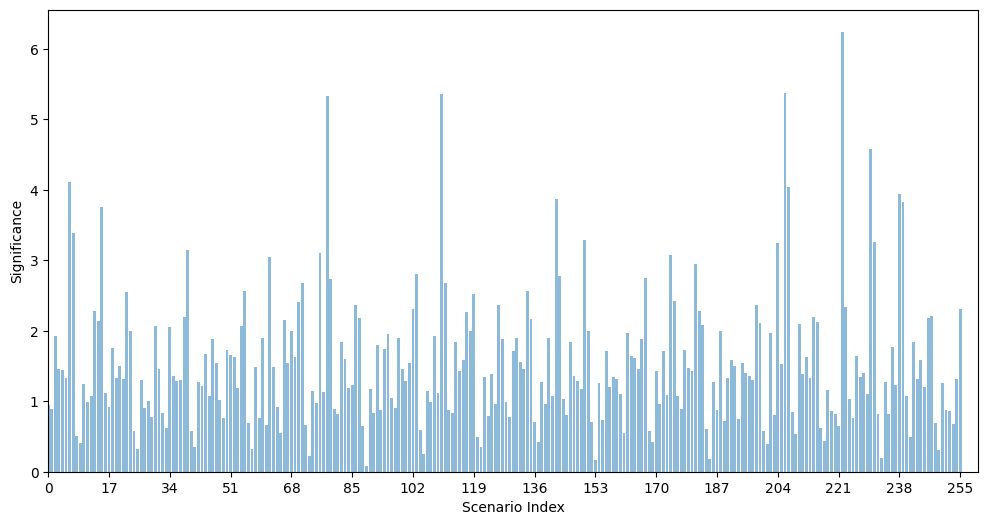

In [98]:
plt.figure(figsize=(12,6))
plt.bar(scenario_results_1['scenario_idx'], scenario_results_1['norm_significance'], label='Scenario 1', alpha=0.5)
plt.xlabel('Scenario Index')
plt.ylabel('Significance')
plt.xlim(0, 260)
plt.xticks(np.linspace(0, 255, 16))
plt.show()

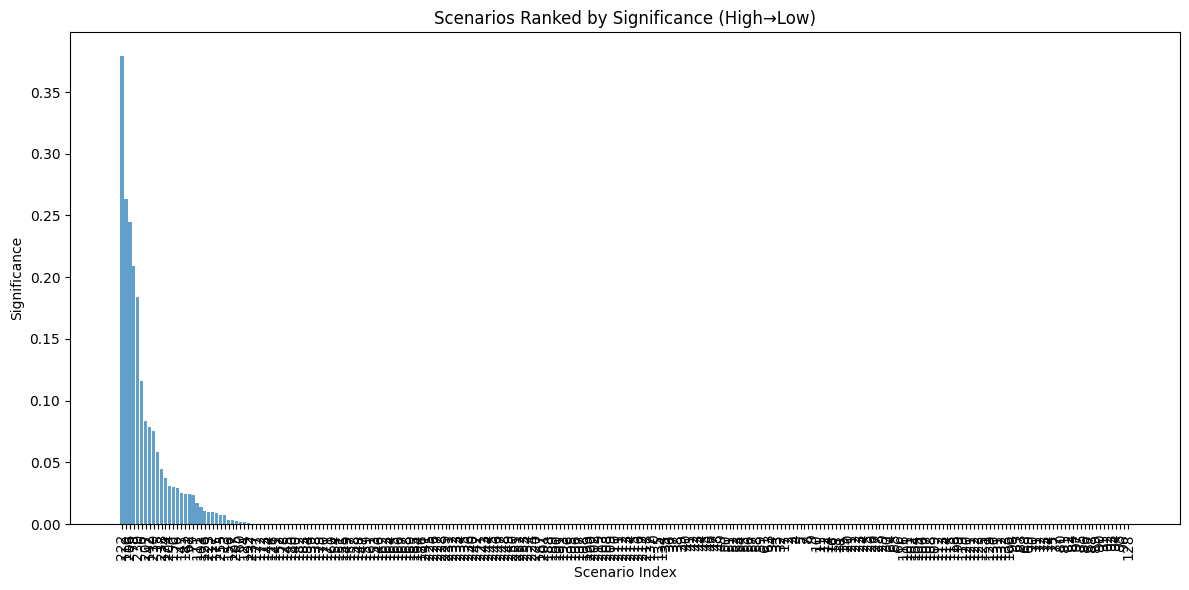

In [99]:
# sort descending
sr = scenario_results_1.sort_values('prod_significance', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(
    sr['scenario_idx'].astype(str),   # use string so plt treats them as categorical
    sr['prod_significance'],
    alpha=0.7
)
plt.xlabel('Scenario Index')
plt.ylabel('Significance')
plt.title('Scenarios Ranked by Significance (High→Low)')
plt.xticks(rotation=90)              # rotate if too crowded
plt.tight_layout()
plt.show()


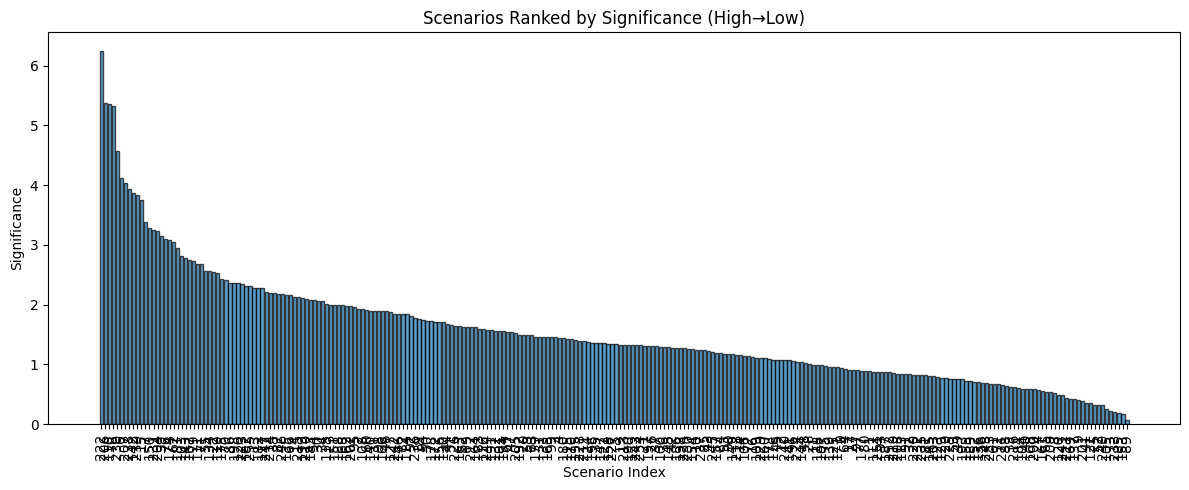

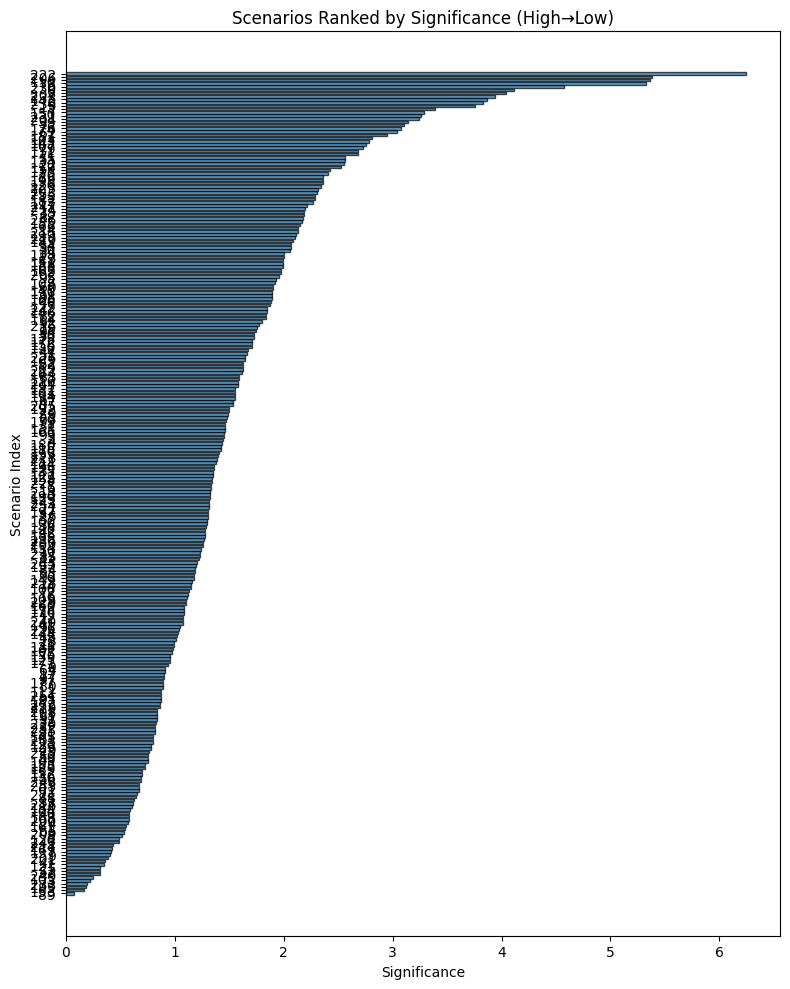

In [101]:
import matplotlib.pyplot as plt

# 1) Filter out zero‐significance runs
df_nonzero = scenario_results_1[scenario_results_1['norm_significance'] > 0]

# 2) Sort descending for vertical, ascending for horizontal (so highest is at the top)
sr_desc = df_nonzero.sort_values('norm_significance', ascending=False)
sr_asc  = df_nonzero.sort_values('norm_significance', ascending=True)

# --- Vertical Bar Chart ---
plt.figure(figsize=(12, 5))
plt.bar(
    sr_desc['scenario_idx'].astype(str),
    sr_desc['norm_significance'],
    alpha=0.7,
    color='tab:blue',
    edgecolor='k'
)
plt.xlabel('Scenario Index')
plt.ylabel('Significance')
plt.title('Scenarios Ranked by Significance (High→Low)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Horizontal Bar Chart ---
plt.figure(figsize=(8, 10))
plt.barh(
    sr_asc['scenario_idx'].astype(str),
    sr_asc['norm_significance'],
    alpha=0.7,
    color='tab:blue',
    edgecolor='k'
)
plt.ylabel('Scenario Index')
plt.xlabel('Significance')
plt.title('Scenarios Ranked by Significance (High→Low)')
plt.tight_layout()
plt.show()


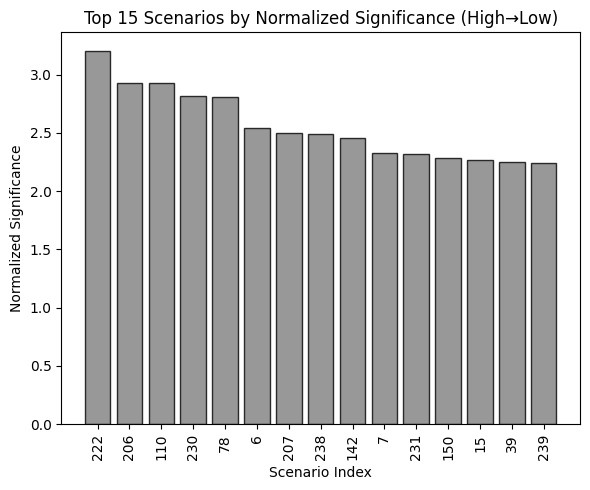

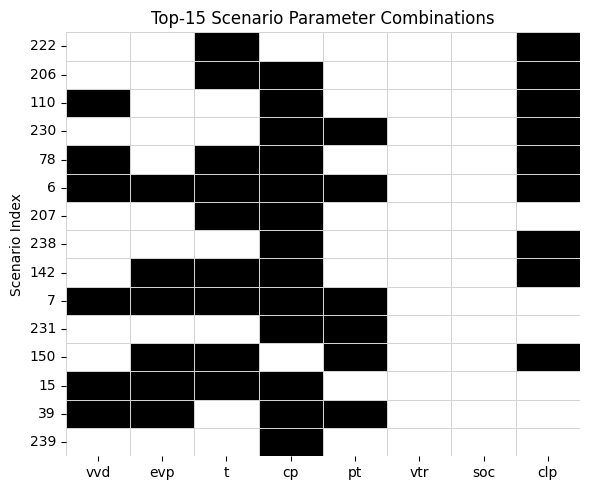

In [160]:
# 1) Filter out zero‐significance runs
df_nonzero = scenario_results_1[scenario_results_1['norm_significance'] > 0]

# 2) Sort descending and take the top 15
sr_desc = df_nonzero.sort_values('norm_significance', ascending=False).head(15)

# 3) Prepare for horizontal by sorting those 15 in ascending order
sr_asc_top15 = sr_desc.sort_values('norm_significance', ascending=True)

# --- Vertical Bar Chart of Top 15 ---
plt.figure(figsize=(6, 5))
plt.bar(
    sr_desc['scenario_idx'].astype(str),
    sr_desc['norm_significance'],
    alpha=0.8,
    color='tab:grey',
    edgecolor='k'
)
plt.xlabel('Scenario Index')
plt.ylabel('Normalized Significance')
plt.title('Top 15 Scenarios by Normalized Significance (High→Low)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

import seaborn as sns
# 1) pick out top-15 by norm_significance
df = scenario_results_1.copy()
top15 = (
    df[df['norm_significance'] > 0]
    .nlargest(15, 'norm_significance')
    .reset_index(drop=True)
)

# 2) build a flags DataFrame
params = ['vvd','evp','t','cp','pt','vtr','soc','clp']
flags = top15[params].notnull().astype(int)
flags.index = top15['scenario_idx'].astype(str)  # label rows by scenario_idx

# 3) plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    flags,
    cmap='Greys_r',        # dark = 1, light = 0
    cbar=False,
    linewidths=0.5,
    linecolor='lightgray'
)
plt.xticks(
    ticks=np.arange(len(params)) + 0.5,
    labels=params,
    rotation=0,
    ha='center'
)
plt.ylabel('Scenario Index')
plt.title('Top-15 Scenario Parameter Combinations')
plt.tight_layout()
plt.show()


In [159]:
means = scenario_results_1.groupby(scenario_results_1['vtr'].notnull().astype(int))['norm_significance'].mean()
print("Mean norm_sig with vtr=0:", means.loc[0])
print("Mean norm_sig with vtr=1:", means.loc[1])


Mean norm_sig with vtr=0: 0.8072499509674883
Mean norm_sig with vtr=1: 1.4478705073187261


vvd_flag    0.017974
evp_flag    0.069062
t_flag     -0.041203
cp_flag    -0.162758
pt_flag    -0.108964
vtr_flag    0.536627
soc_flag    0.504269
clp_flag   -0.191934
Name: norm_significance, dtype: float64


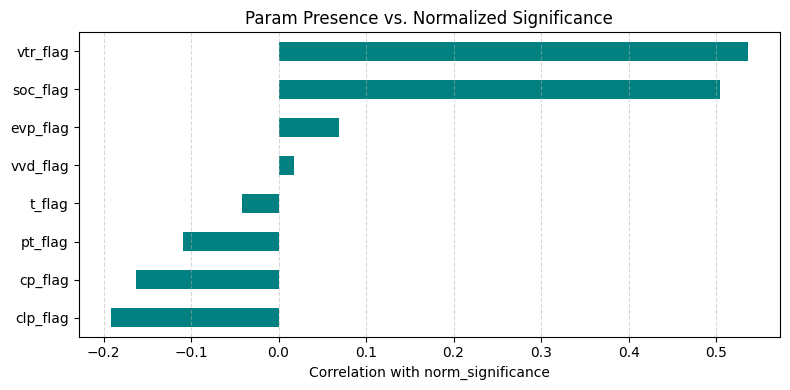

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# assume scenario_results_1 is your DataFrame
df = scenario_results_1.copy()

# 1) Build binary “flag” columns: 1 if that scenario param is present, 0 if NaN
params = ['vvd','evp','t','cp','pt','vtr','soc','clp']
for p in params:
    df[p + '_flag'] = df[p].notnull().astype(int)

# 2) Pick out only the norm_significance and those flags
cols = ['norm_significance'] + [p + '_flag' for p in params]
sub = df[cols]

# 3) Compute the Pearson correlation matrix
corr = sub.corr()

# 4) Pull out just the correlations with norm_significance
corr_with_norm = corr['norm_significance'].drop('norm_significance')
print(corr_with_norm)

# 5) (Optional) Visualize as a bar chart
plt.figure(figsize=(8,4))
corr_with_norm.sort_values().plot(kind='barh', color='teal')
plt.xlabel('Correlation with norm_significance')
plt.title('Param Presence vs. Normalized Significance')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


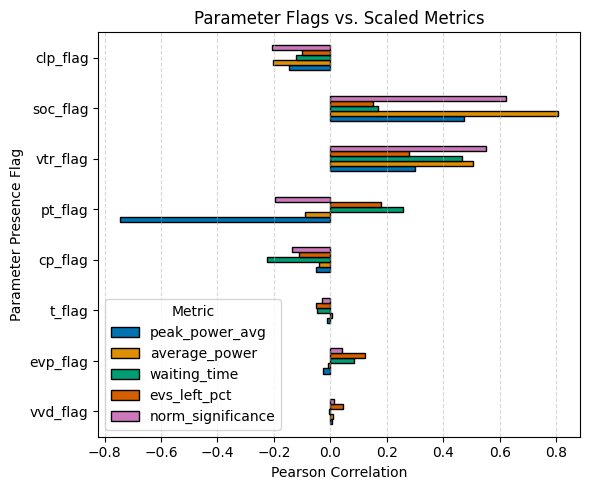

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# assume scenario_results_1 is loaded

df = scenario_results_1.copy()

# 1) build the flags
params = ['vvd','evp','t','cp','pt','vtr','soc','clp']
for p in params:
    df[p+'_flag'] = df[p].notnull().astype(int)

# 2) scale your metrics
metrics = ['peak_power_avg','average_power','waiting_time','evs_left_pct','norm_significance']
for m in metrics:
    mn, mx = df[m].min(), df[m].max()
    df[m+'_scaled'] = (df[m] - mn)/(mx - mn)

# 3) get the correlations
flags = [p+'_flag' for p in params]
scales= [m+'_scaled' for m in metrics]
corr = df[flags+scales].corr().loc[flags, scales]
corr.columns = metrics

# 4) plot
palette = sns.color_palette("colorblind", n_colors=len(metrics))
ax = corr.plot.barh(
    figsize=(6,5),
    color=palette,
    edgecolor='k',
)

ax.set_xlabel('Pearson Correlation')
ax.set_ylabel('Parameter Presence Flag')
ax.set_title('Parameter Flags vs. Scaled Metrics')
ax.legend(title='Metric', loc='lower left')
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [158]:
# after you’ve built corr_flags_metrics that includes norm_significance
print("vtr correlation:", corr.loc['vtr_flag','norm_significance'])
print("soc correlation:", corr.loc['soc_flag','norm_significance'])

vtr correlation: 0.552890396242
soc correlation: 0.6210076044083018


In [133]:
# round to 3 decimals
table = corr.round(3)

# 1) Save as CSV
table.to_csv("corr_flags_metrics.csv", index=True)

# 2) Or copy to clipboard (then in Excel: Ctrl+V)
table.to_clipboard(sep='\t', index=True)
print("Correlation table copied to clipboard. Paste into Excel.")


Correlation table copied to clipboard. Paste into Excel.


#### Smaller Run with chosen scenarios

In [161]:
# Assume scenario_results_1 is already in your workspace
df = scenario_results_2.copy()

# Define the metrics and their weights
weights = {
    'peak_power_avg': 1.0,
    'average_power':  1.0,
    'waiting_time':   1.0,
    'evs_left_pct':   1.0
}

# Min–max scale each column into [0,1]
for col in weights:
    mn, mx = df[col].min(), df[col].max()
    df[f"{col}_scaled"] = (df[col] - mn) / (mx - mn)

# Compute the weighted sum
df['norm_significance'] = sum(
    df[f"{col}_scaled"] * weight
    for col, weight in weights.items()
)

# (Optionally) drop the intermediate scaled columns
df.drop(columns=[f"{c}_scaled" for c in weights], inplace=True)

# Replace the original DataFrame if you like
scenario_results_2 = df

# Inspect
print(scenario_results_2[['norm_significance']].head())
print(scenario_results_2[['norm_significance']].max())


   norm_significance
0           1.422104
1           2.369523
2           3.152109
3           1.860161
4           1.992743
norm_significance    3.152109
dtype: float64


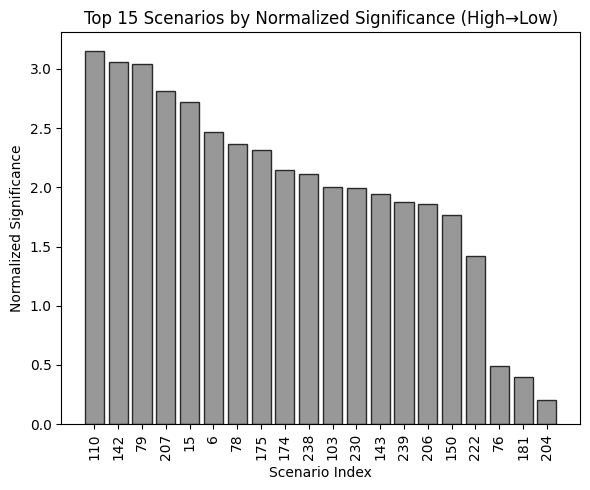

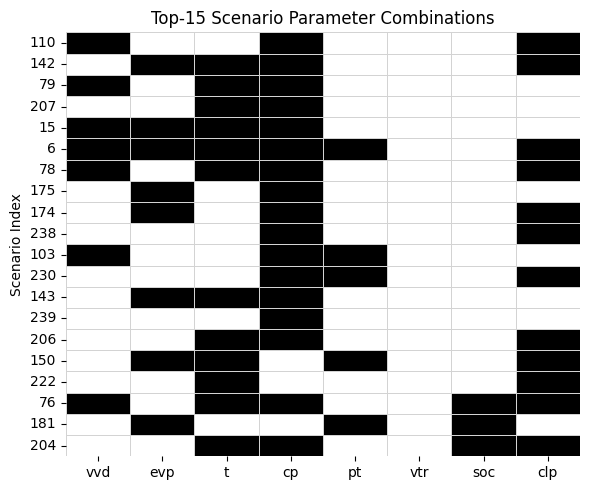

In [165]:
# 1) Filter out zero‐significance runs
df_nonzero_2 = scenario_results_2[scenario_results_2['norm_significance'] > 0]

# 2) Sort descending and take the top 15
sr_desc_2 = df_nonzero_2.sort_values('norm_significance', ascending=False).head(20)

# 3) Prepare for horizontal by sorting those 15 in ascending order
sr_asc_top15_2 = sr_desc_2.sort_values('norm_significance', ascending=True)

# --- Vertical Bar Chart of Top 15 ---
plt.figure(figsize=(6, 5))
plt.bar(
    sr_desc_2['scenario_idx'].astype(str),
    sr_desc_2['norm_significance'],
    alpha=0.8,
    color='tab:grey',
    edgecolor='k'
)
plt.xlabel('Scenario Index')
plt.ylabel('Normalized Significance')
plt.title('Top 15 Scenarios by Normalized Significance (High→Low)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

import seaborn as sns
# 1) pick out top-15 by norm_significance
df = scenario_results_2.copy()
top15 = (
    df[df['norm_significance'] > 0]
    .nlargest(20, 'norm_significance')
    .reset_index(drop=True)
)

# 2) build a flags DataFrame
params = ['vvd','evp','t','cp','pt','vtr','soc','clp']
flags = top15[params].notnull().astype(int)
flags.index = top15['scenario_idx'].astype(str)  # label rows by scenario_idx

# 3) plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    flags,
    cmap='Greys_r',        # dark = 1, light = 0
    cbar=False,
    linewidths=0.5,
    linecolor='lightgray'
)
plt.xticks(
    ticks=np.arange(len(params)) + 0.5,
    labels=params,
    rotation=0,
    ha='center'
)
plt.ylabel('Scenario Index')
plt.title('Top-15 Scenario Parameter Combinations')
plt.tight_layout()
plt.show()


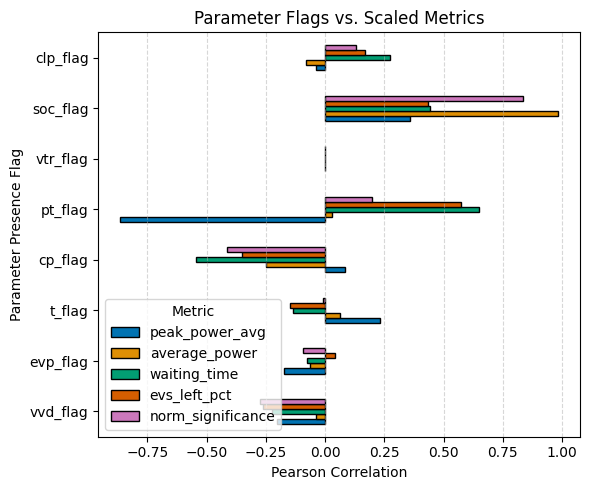

In [166]:
df = scenario_results_2.copy()

# 1) build the flags
params = ['vvd','evp','t','cp','pt','vtr','soc','clp']
for p in params:
    df[p+'_flag'] = df[p].notnull().astype(int)

# 2) scale your metrics
metrics = ['peak_power_avg','average_power','waiting_time','evs_left_pct','norm_significance']
for m in metrics:
    mn, mx = df[m].min(), df[m].max()
    df[m+'_scaled'] = (df[m] - mn)/(mx - mn)

# 3) get the correlations
flags = [p+'_flag' for p in params]
scales= [m+'_scaled' for m in metrics]
corr = df[flags+scales].corr().loc[flags, scales]
corr.columns = metrics

# 4) plot
palette = sns.color_palette("colorblind", n_colors=len(metrics))
ax = corr.plot.barh(
    figsize=(6,5),
    color=palette,
    edgecolor='k',
)

ax.set_xlabel('Pearson Correlation')
ax.set_ylabel('Parameter Presence Flag')
ax.set_title('Parameter Flags vs. Scaled Metrics')
ax.legend(title='Metric', loc='lower left')
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## For Reference / Testing

#### Single Simulations

You can run a single (non-Monte Carlo) simulation if desired by using the code below:

In [ ]:
sim = EVChargingSimulation(df, 0.0038, level_pub=[0,27], level_pri=[0,26],
                           charger_weights=CHARGER_WEIGHTS_A, chg_red_df=temp_red_df, log=False) # Initialize

### Set scenario parameters if desired

#sim.adjust_ev_penetration(modify_start='2024-01-1', modify_end='2024-01-10',
#                          target_penetration=0.01, method='normal', std=0.02, random_state=42)
#sim.set_power_throttle(start_date='2024-01-12', end_date='2024-01-14', throttle_value=0.5)
#sim.set_visit_ratio(start_date='2024-01-12', end_date='2024-01-14', ratio=[0.5, 0.5])
#sim.set_charger_weights_override(start_date='2024-01-12', end_date='2024-01-14', 
#                                 weights={'Level 1': 0.5, 'Level 2': 0.5, 'Level 3': 0.5})
#sim.set_lower_soc(start_date='2024-01-12', end_date='2024-01-14', soc_clip=0.3)
#sim.set_cp_reduction_range(start_date='2024-01-01', end_date='2024-01-01', reduction_factor=0.78)

# Run simulation
result_df = sim.charging_profile()

Here are some examples of plots that can be created for the single simulation:

In [ ]:
# Plot port usage over time
sim.plot_port_usage('Level 1','both')
sim.plot_port_usage('Level 2','public')

In [ ]:
# Plot queue lengths over time
plt.plot(result_df['TimeStamp'],sim.queue_lengths['Day'], label='Day Queue Length', color='blue', linewidth=0.3)
plt.plot(result_df['TimeStamp'],sim.queue_lengths['Overnight'], label='Overnight Queue Length', color='red', linewidth=0.3)
plt.xlabel('Time Interval')
plt.ylabel('Queue Length')

In [ ]:
# Plot zoomed-in load profile (e.g., first month)

months_to_show = 1
start_date = result_df['TimeStamp'].min()
end_date = start_date + pd.DateOffset(months=months_to_show)
filtered_df = result_df[(result_df['TimeStamp'] >= start_date) & (result_df['TimeStamp'] < end_date)]

# Plot the filtered data
plt.figure(figsize=(20, 8))
plt.plot(filtered_df['TimeStamp'], filtered_df['Total Power'], label='Total Power', linewidth=0.5)
plt.plot(filtered_df['TimeStamp'], filtered_df['Total Power'].rolling(window=288).mean(), label='Daily Average', linewidth=1)
plt.xlabel('TimeStamp')
plt.ylabel('Total Power (kW)')
plt.title(f'EV Charging Profile (First {months_to_show} Months)')
plt.legend()
plt.show()

### Monte Carlo Simulations

Following are a variety of plots that can be created from Monte Carlo simulations:

In [ ]:
# Convergence plots for the 4 key metrics (Average Power, Peak Power, EVs Left, Waiting Time)
mcsim.plot_convergence()

In [ ]:
# Port usage over time for chosen run in MC sim, by charger level and with specified buffer intervals
mcsim.plot_simulation_port_usage_vs_queue(sim_index=0, charger_level='Level 2', buffer_intervals=288)

In [ ]:
# Average aggregate port usage timeseries across all MC runs, by charger level
mcsim.plot_aggregated_port_usage(charger_level='Level 1', access='both')
mcsim.plot_aggregated_port_usage(charger_level='Level 2', access='both')

If desired, the simulator object can be saved for future analysis:

In [ ]:
def save_simulation_object(sim_object, folder_path, filename):
    """
    Save the entire simulation object (e.g., a MonteCarloSimulator instance) to a file.
    
    Parameters:
      sim_object: The simulation object to be saved.
      folder_path (str): Path to the folder where the file should be saved.
      filename (str): The name of the file (default 'simulation_object.pkl').
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'wb') as f:
        pickle.dump(sim_object, f)
    print(f"Simulation object saved to {file_path}")

In [ ]:
save_simulation_object(mcsim, folder_path='Monte Carlo Convergence Tests', filename='MCS_0.01_100-runs.pkl')

##### A selection of examples for possible non built-in plotting functions:

In [ ]:
# Plot weekday vs Weekend Load Profiles
def day_end_profiles(all_simulations_df):
    # Assuming self.result_df contains the data with the 'TimeStamp', 'DayOfWeek', and 'Total Power'
    # Replace 'result_df' with your actual DataFrame variable name
    result_df = all_simulations_df.copy()
    result_df['TimeStamp'] = pd.to_datetime(result_df['TimeStamp'])
    result_df['DayOfWeek'] = result_df['TimeStamp'].dt.dayofweek  # Monday=0, Sunday=6
    result_df['HourOfDay'] = result_df['TimeStamp'].dt.hour + result_df['TimeStamp'].dt.minute / 60

    # Separate the data into weekdays (Mon-Thu) and weekends (Fri-Sun)
    weekday_df = result_df[result_df['DayOfWeek'].isin([0, 1, 2, 3])]
    weekend_df = result_df[result_df['DayOfWeek'].isin([4, 5, 6])]

    # Calculate the average daily load profile for weekdays and weekends
    average_weekday_load_profile = weekday_df.groupby('HourOfDay')['Total Power'].mean()
    average_weekend_load_profile = weekend_df.groupby('HourOfDay')['Total Power'].mean()

    # Plotting the weekday vs weekend load profiles
    plt.figure(figsize=(10, 6))
    plt.plot(
        average_weekend_load_profile.index,
        average_weekend_load_profile.values,
        label='Weekend (Fri, Sat, Sun)',
        linewidth=2,
        color='#F2CD00'
    )
    plt.plot(
        average_weekday_load_profile.index,
        average_weekday_load_profile.values,
        label='Weekday (Mon, Tue, Wed, Thu)',
        linewidth=2,
        color='#275D38'
    )


    # Customize the plot
    plt.title('Average Daily Load Profiles for Weekdays vs Weekends', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Average Total Power (kW)', fontsize=14)
    plt.xticks([0,4,8,12,16,20,24], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(0,24)
    plt.ylim(0,55)
    plt.legend(fontsize=12, title_fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Save the figure in high resolution
    #plt.savefig('average_daily_load_profiles_weekday_vs_weekend_best-case.png', dpi=300)

    # Display the plot
    plt.show()

In [ ]:
# Plot average total power over the year with rolling average
def plot_avg_total_power(avg_total_power):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.rcParams['font.size'] = '16'
    ax.set_title("Total power consumption over the year")
    ax.set_xlim(pd.Timestamp('2024-01-01 00:00:00'), pd.Timestamp('2025-01-01 00:00:00'))
    ax.plot(avg_total_power['TimeStamp'], avg_total_power['Total Power'], 'b', linewidth=0.1, label='power')
    ax.plot(avg_total_power['TimeStamp'], avg_total_power['Total Power'].rolling(window=288).mean(), 'r', linewidth=1, label='avg')
    ax.set_ylabel('Power (kW)')
    fig.tight_layout()
    ax.legend()

In [ ]:
# Plot average daily load profile with 75th percentile shading
def dailyloadprofile(all_simulations_df):
    # Calculate average daily load profile
    dfcopy = all_simulations_df.copy()
    dfcopy['HourOfDay'] = dfcopy['TimeStamp'].dt.hour + dfcopy['TimeStamp'].dt.minute / 60
    average_daily_load_profile = dfcopy.groupby('HourOfDay')['Total Power'].mean()
    percentiles_25 = dfcopy.groupby('HourOfDay')['Total Power'].quantile(0.25)
    percentiles_75 = dfcopy.groupby('HourOfDay')['Total Power'].quantile(0.75)

    # Plotting the average daily load profile
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.plot(average_daily_load_profile.index, average_daily_load_profile, label='Average Daily Load Profile')

    # Add shading for the 75th percentile range
    ax.fill_between(
        average_daily_load_profile.index,
        percentiles_25,
        percentiles_75,
        color='gray',
        alpha=0.5,
        label='75th Percentile Range'
    )

In [ ]:
# Plot histogram of total power values across all simulations
def plot_total_power_histogram(all_total_power, bin_width=0.2):
    # Filter out zero values
    filtered_total_power = [value for value in all_total_power if value != 0]

    min_power = min(filtered_total_power)
    max_power = max(filtered_total_power)
    num_bins = int(np.ceil((max_power - min_power) / bin_width))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(filtered_total_power, bins=num_bins, edgecolor='black')
    ax.set_title('Histogram of Total Power Across All Simulations')
    ax.set_xlabel('Total Power (kW)')
    ax.set_ylabel('Frequency')
    fig.show()